<a href="https://colab.research.google.com/github/phyosandarwin/sc4001_proj/blob/main/image_caption_lstm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download dataset from kaggle
!pip install kaggle
!mkdir ~/.kaggle

!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed7be3.jpg  
  inflating: Images/2852982055_8112d0

In [2]:
!pip install keras keras-preprocessing tensorflow nltk pydot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00


In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model, Sequence
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Embedding, Dropout, concatenate, Attention, Bidirectional, add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
from sklearn.model_selection import train_test_split

# metrics such as BLEU
from nltk.translate.bleu_score import sentence_bleu


import pickle
import re
import numpy as np
import cv2
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from textwrap import wrap
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [6]:
captions_path = 'captions.txt'
data = pd.read_csv(captions_path)
print(data.shape)
data.head(10)

(40455, 2)


image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [7]:
# rename col of image to image_id
data.rename(columns={'image':'img_id'}, inplace=True)
print(data.shape)
data.head(10)

(40455, 2)


img_id  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

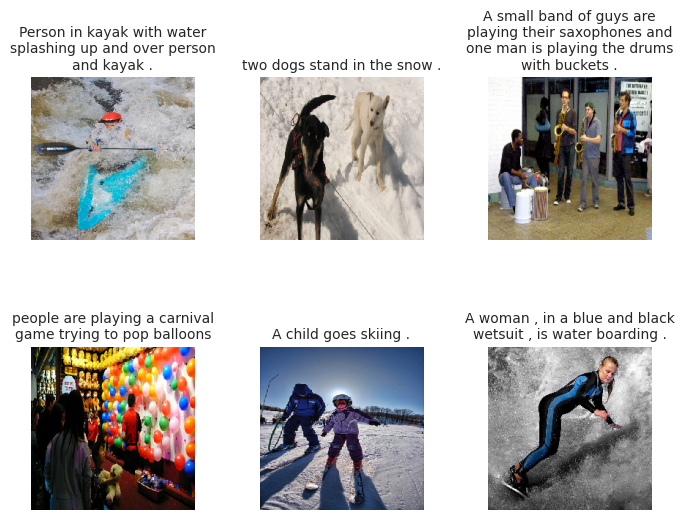

In [8]:
image_path = 'Images'
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0  # Normalise pixel values
    return img

# Function to display images with captions
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(8, 6))
    n = 0
    for i in range(6):
        n += 1
        plt.subplot(2, 3, n)
        plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjusted spacing
        image = readImage(f"{image_path}/{temp_df.img_id[i]}")
        plt.imshow(image)

        # Wrap captions to fit within the plot
        caption = "\n".join(wrap(temp_df.caption[i], 30))
        plt.title(caption, fontsize=10)
        plt.axis("off")

    plt.show()

# Sample usage
display_images(data.sample(6))

In [9]:
# clean the captions

def text_preprocessing(data):
    # Convert to lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())

    # Remove special characters, punctuation, and digits using regex
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"[^a-z\s]", "", x))

    # Remove extra spaces
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

    # filter out words with length 1 or less - less meaningful representations
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))

    # Add startseq and endseq tokens
    data['caption'] = "startseq " + data['caption'] + " endseq"

    return data

data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10] # show first 10 captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [10]:
# build vocabulary
all_words = " ".join(captions)
unique_words = list(set(all_words.split()))
vocab_size = len(unique_words) + 1
print(f"Vocabulary size: {vocab_size}")
unique_words[:10]

Vocabulary size: 8768


['skiers',
 'zipping',
 'aerobatic',
 'english',
 'maneuvers',
 'int',
 'snowstorm',
 'pee',
 'multicolored',
 'docking']

In [11]:
# Create word-to-index and index-to-word mappings
words_to_indices = {word: idx + 1 for idx, word in enumerate(unique_words)}  # index starts from 1
indices_to_words = {idx + 1: word for idx, word in enumerate(unique_words)}

# Add an entry for unknown words
words_to_indices["UNK"] = 0
indices_to_words[0] = "UNK"

In [12]:
# split in 80:10:10
train_data, remaining_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(remaining_data, test_size=0.5, random_state=42)

train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

train_data.shape, val_data.shape, test_data.shape

((32364, 2), (4045, 2), (4046, 2))

In [13]:
# Dictionary to hold captions by image ID
train_captions = {img_id: train_data[train_data['img_id'] == img_id]['caption'].tolist() for img_id in tqdm(train_data['img_id'].unique())}
test_captions = {img_id: test_data[test_data['img_id'] == img_id]['caption'].tolist() for img_id in tqdm(test_data['img_id'].unique())}
validation_captions = {img_id: val_data[val_data['img_id'] == img_id]['caption'].tolist() for img_id in tqdm(val_data['img_id'].unique())}

100%|██████████| 3351/3351 [00:02<00:00, 1439.62it/s]


In [14]:
# save train, test and validation captions
with open("train_captions.pkl", "wb" ) as pickle_f:
    pickle.dump(train_captions, pickle_f )
with open("validation_captions.pkl", "wb" ) as pickle_f:
    pickle.dump(validation_captions, pickle_f )
with open("test_captions.pkl", "wb" ) as pickle_f:
    pickle.dump(test_captions, pickle_f )

In [15]:
def encode_captions(captions, vocab_mapping):
    encoded_captions = {}
    for img_id, caption_list in captions.items():
        encoded_captions[img_id] = []
        for caption in caption_list:
            # Encode each caption using the words_to_indices mapping
            encoded_caption = [vocab_mapping.get(word, vocab_mapping["UNK"]) for word in caption.split()]
            encoded_captions[img_id].append(encoded_caption)
    return encoded_captions

# Assuming train_captions, test_captions, and validation_captions are dictionaries with img_id as keys
train_encoded_captions = encode_captions(train_captions, words_to_indices)
test_encoded_captions = encode_captions(test_captions, words_to_indices)
validation_encoded_captions = encode_captions(validation_captions, words_to_indices)

In [16]:
# Ensure all sequences are of fixed length
max_length = 15
train_encoded_captions = {img_id: pad_sequences(captions, maxlen=max_length, padding='post') for img_id, captions in train_encoded_captions.items()}
test_encoded_captions = {img_id: pad_sequences(captions, maxlen=max_length, padding='post') for img_id, captions in test_encoded_captions.items()}
validation_encoded_captions = {img_id: pad_sequences(captions, maxlen=max_length, padding='post') for img_id, captions in validation_encoded_captions.items()}

In [17]:
# Find the index for '<UNK>'
unk_index = words_to_indices.get('<UNK>', 0)

# Initialize a counter for <UNK> occurrences
unk_count = 0
total_words = 0

# Iterate through all captions in your dataset
for img_id, caption_list in train_encoded_captions.items():
    for caption in caption_list:
        # Count occurrences of <UNK> (0 or the index of <UNK>)
        unk_count += np.count_nonzero(caption == unk_index)
        total_words += len(caption)

print(f"Total number of words in train captions: {total_words}")
print(f"Total number of <UNK> tokens: {unk_count}")
print(f"Percentage of <UNK> tokens: {unk_count / total_words * 100:.2f}%")

Total number of words in train captions: 485460
Total number of <UNK> tokens: 132444
Percentage of <UNK> tokens: 27.28%


---

In [18]:
resnet50_model=ResNet50(include_top=False, weights='imagenet',pooling='avg',input_shape=(224,224,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [19]:
os.makedirs("Features/", exist_ok=True)

In [20]:
# Define function to extract features from images using ResNet50
def extract_features(captions, image_path, model):
    features = {}
    for img_id in tqdm(captions.keys(), desc="Extracting Features"):
        img_path_full = os.path.join(image_path, img_id)
        img = image.load_img(img_path_full, target_size=(224, 224))  # Resize to 224x224
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)  # Preprocess for ResNet50
        features[img_id] = model.predict(img_array).squeeze()  # Flatten the output
    return features

In [21]:
# Extract features for train, test, and validation datasets
train_features = extract_features(train_captions, image_path, resnet50_model)

Extracting Features:   0%|          | 0/8090 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


Extracting Features:   0%|          | 1/8090 [00:06<15:18:16,  6.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 3/8090 [00:06<4:04:31,  1.81s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 5/8090 [00:07<2:03:11,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   0%|          | 7/8090 [00:07<1:14:31,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 9/8090 [00:07<49:44,  2.71it/s]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 11/8090 [00:07<35:17,  3.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 13/8090 [00:07<26:21,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   0%|          | 15/8090 [00:07<20:33,  6.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   0%|          | 17/8090 [00:07<16:34,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   0%|          | 19/8090 [00:07<13:54,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   0%|          | 21/8090 [00:08<12:05, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   0%|          | 23/8090 [00:08<11:05, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 25/8090 [00:08<10:33, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 27/8090 [00:08<10:04, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 29/8090 [00:08<09:37, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 31/8090 [00:08<09:15, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   0%|          | 33/8090 [00:08<08:53, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 35/8090 [00:08<08:54, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 37/8090 [00:09<08:52, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 39/8090 [00:09<08:46, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 41/8090 [00:09<08:44, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 43/8090 [00:09<08:48, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|          | 45/8090 [00:09<09:03, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 47/8090 [00:09<08:54, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 49/8090 [00:09<08:48, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 51/8090 [00:10<08:45, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 53/8090 [00:10<08:51, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 55/8090 [00:10<08:43, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 57/8090 [00:10<08:32, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 59/8090 [00:10<08:41, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   1%|          | 61/8090 [00:10<08:53, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|          | 63/8090 [00:10<08:56, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 65/8090 [00:10<08:52, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 67/8090 [00:11<08:37, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   1%|          | 69/8090 [00:11<08:26, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 71/8090 [00:11<08:27, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 73/8090 [00:11<08:24, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 75/8090 [00:11<08:27, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 77/8090 [00:11<08:20, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 79/8090 [00:11<08:12, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 81/8090 [00:11<08:06, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 83/8090 [00:12<08:07, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 85/8090 [00:12<08:09, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 87/8090 [00:12<08:09, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 89/8090 [00:12<08:09, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 91/8090 [00:12<08:08, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 93/8090 [00:12<08:17, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 95/8090 [00:12<08:14, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 97/8090 [00:12<08:11, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 99/8090 [00:13<08:11, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|          | 101/8090 [00:13<08:19, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|▏         | 103/8090 [00:13<08:09, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|▏         | 105/8090 [00:13<08:07, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|▏         | 107/8090 [00:13<08:15, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   1%|▏         | 109/8090 [00:13<08:24, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|▏         | 111/8090 [00:13<08:14, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|▏         | 113/8090 [00:13<08:06, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|▏         | 115/8090 [00:14<08:03, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|▏         | 117/8090 [00:14<08:08, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|▏         | 119/8090 [00:14<08:09, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|▏         | 121/8090 [00:14<12:55, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 123/8090 [00:14<11:34, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 125/8090 [00:14<10:33, 12.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 127/8090 [00:14<09:50, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 129/8090 [00:15<09:23, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 131/8090 [00:15<09:03, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 133/8090 [00:15<08:51, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 135/8090 [00:15<08:39, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 137/8090 [00:15<08:51, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 139/8090 [00:15<08:41, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 141/8090 [00:15<08:24, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 143/8090 [00:15<08:14, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 145/8090 [00:16<08:24, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 147/8090 [00:16<08:22, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 149/8090 [00:16<08:14, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 151/8090 [00:16<08:13, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 153/8090 [00:16<08:13, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 155/8090 [00:16<08:08, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 157/8090 [00:16<08:06, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 159/8090 [00:16<08:09, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 161/8090 [00:17<08:10, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 163/8090 [00:17<08:06, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 165/8090 [00:17<08:09, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 167/8090 [00:17<08:11, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 169/8090 [00:17<08:24, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 171/8090 [00:17<08:27, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 173/8090 [00:17<08:31, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 175/8090 [00:18<08:37, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 177/8090 [00:18<08:30, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 179/8090 [00:18<08:23, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 181/8090 [00:18<08:21, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   2%|▏         | 183/8090 [00:18<08:33, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 185/8090 [00:18<08:35, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 187/8090 [00:18<08:23, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 189/8090 [00:18<08:18, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 191/8090 [00:19<08:14, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 193/8090 [00:19<08:37, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 195/8090 [00:19<08:30, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 197/8090 [00:19<08:41, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 199/8090 [00:19<08:31, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 201/8090 [00:19<08:21, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 203/8090 [00:19<08:15, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 205/8090 [00:19<08:17, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 207/8090 [00:20<08:15, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 209/8090 [00:20<08:13, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 211/8090 [00:20<08:08, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 213/8090 [00:20<08:09, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 215/8090 [00:20<08:05, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 217/8090 [00:20<08:14, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 219/8090 [00:20<08:15, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 221/8090 [00:20<08:15, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 223/8090 [00:21<08:20, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 225/8090 [00:21<08:15, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 227/8090 [00:21<08:32, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 229/8090 [00:21<08:34, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 231/8090 [00:21<08:33, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 233/8090 [00:21<08:34, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 235/8090 [00:21<08:30, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 237/8090 [00:21<08:25, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 239/8090 [00:22<08:27, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 241/8090 [00:22<08:29, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 243/8090 [00:22<08:42, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 245/8090 [00:22<08:42, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 247/8090 [00:22<08:40, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 249/8090 [00:22<08:35, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 251/8090 [00:22<08:39, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 253/8090 [00:23<08:41, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 255/8090 [00:23<08:52, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 257/8090 [00:23<08:43, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 259/8090 [00:23<08:51, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 261/8090 [00:23<08:48, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 263/8090 [00:23<08:49, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 265/8090 [00:23<08:49, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 267/8090 [00:23<08:38, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 269/8090 [00:24<08:33, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 271/8090 [00:24<08:29, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 273/8090 [00:24<08:21, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 275/8090 [00:24<08:14, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 277/8090 [00:24<08:34, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 279/8090 [00:24<08:24, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 281/8090 [00:24<08:17, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 283/8090 [00:24<08:13, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▎         | 285/8090 [00:25<08:08, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▎         | 287/8090 [00:25<08:07, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▎         | 289/8090 [00:25<08:17, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 291/8090 [00:25<08:16, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 293/8090 [00:25<08:26, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▎         | 295/8090 [00:25<08:16, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   4%|▎         | 297/8090 [00:25<08:08, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▎         | 299/8090 [00:26<08:01, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▎         | 301/8090 [00:26<08:03, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 303/8090 [00:26<08:01, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 305/8090 [00:26<07:59, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 307/8090 [00:26<08:01, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 309/8090 [00:26<08:00, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   4%|▍         | 311/8090 [00:26<07:55, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 313/8090 [00:26<08:00, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 315/8090 [00:26<07:59, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 317/8090 [00:27<08:00, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 319/8090 [00:27<07:58, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 321/8090 [00:27<07:59, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 323/8090 [00:27<07:57, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 325/8090 [00:27<08:05, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 327/8090 [00:27<08:05, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 329/8090 [00:27<08:03, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 331/8090 [00:27<08:01, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 333/8090 [00:28<07:59, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   4%|▍         | 335/8090 [00:28<07:52, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 337/8090 [00:28<07:59, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 339/8090 [00:28<08:01, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   4%|▍         | 341/8090 [00:28<08:10, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 343/8090 [00:28<08:07, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 345/8090 [00:28<08:03, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   4%|▍         | 347/8090 [00:28<07:59, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 349/8090 [00:29<08:04, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 351/8090 [00:29<08:05, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 353/8090 [00:29<08:08, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 355/8090 [00:29<08:01, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▍         | 357/8090 [00:29<08:17, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 359/8090 [00:29<08:07, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 361/8090 [00:29<08:14, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 363/8090 [00:30<08:19, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 365/8090 [00:30<08:19, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 367/8090 [00:30<08:15, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 369/8090 [00:30<08:12, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 371/8090 [00:30<08:10, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 373/8090 [00:30<08:17, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 375/8090 [00:30<08:12, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 377/8090 [00:30<08:09, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 379/8090 [00:31<08:02, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 381/8090 [00:31<08:05, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 383/8090 [00:31<08:03, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 385/8090 [00:31<08:10, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   5%|▍         | 387/8090 [00:31<08:16, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 389/8090 [00:31<08:23, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 391/8090 [00:31<08:15, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 393/8090 [00:31<08:07, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 395/8090 [00:32<08:01, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 397/8090 [00:32<08:01, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 399/8090 [00:32<08:01, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 401/8090 [00:32<08:02, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 403/8090 [00:32<08:03, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▌         | 405/8090 [00:32<08:01, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▌         | 407/8090 [00:32<07:53, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 409/8090 [00:32<08:02, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 411/8090 [00:33<08:01, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▌         | 413/8090 [00:33<07:58, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▌         | 415/8090 [00:33<07:56, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 417/8090 [00:33<07:57, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 419/8090 [00:33<07:55, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 421/8090 [00:33<08:04, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   5%|▌         | 423/8090 [00:33<08:05, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 425/8090 [00:33<08:16, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 427/8090 [00:34<08:10, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 429/8090 [00:34<08:13, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 431/8090 [00:34<08:27, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 433/8090 [00:34<08:38, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   5%|▌         | 435/8090 [00:34<08:43, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 437/8090 [00:34<08:43, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▌         | 439/8090 [00:34<08:29, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 441/8090 [00:34<08:24, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 443/8090 [00:35<08:40, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   6%|▌         | 445/8090 [00:35<08:46, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   6%|▌         | 447/8090 [00:35<08:55, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 449/8090 [00:35<08:57, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 451/8090 [00:35<08:59, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   6%|▌         | 453/8090 [00:35<08:49, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 455/8090 [00:35<08:39, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 457/8090 [00:36<08:35, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 459/8090 [00:36<08:35, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 461/8090 [00:36<08:32, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 463/8090 [00:36<08:28, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 465/8090 [00:36<08:22, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   6%|▌         | 467/8090 [00:36<08:10, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 469/8090 [00:36<08:08, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 471/8090 [00:37<08:03, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 473/8090 [00:37<08:01, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 475/8090 [00:37<07:57, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 477/8090 [00:37<07:54, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 479/8090 [00:37<07:51, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 481/8090 [00:37<07:57, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 483/8090 [00:37<08:00, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 485/8090 [00:37<08:00, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 487/8090 [00:38<07:58, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 489/8090 [00:38<07:57, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   6%|▌         | 491/8090 [00:38<07:54, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 493/8090 [00:38<07:55, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 495/8090 [00:38<07:59, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 497/8090 [00:38<07:59, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 499/8090 [00:38<07:57, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 501/8090 [00:38<07:51, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 503/8090 [00:39<07:50, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 505/8090 [00:39<07:55, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▋         | 507/8090 [00:39<07:52, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▋         | 509/8090 [00:39<07:52, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▋         | 511/8090 [00:39<07:59, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▋         | 513/8090 [00:39<08:10, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▋         | 515/8090 [00:39<08:07, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▋         | 517/8090 [00:39<08:09, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▋         | 519/8090 [00:40<08:05, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▋         | 521/8090 [00:40<08:07, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▋         | 523/8090 [00:40<07:59, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▋         | 525/8090 [00:40<08:01, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   7%|▋         | 527/8090 [00:40<08:10, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 529/8090 [00:40<08:16, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 531/8090 [00:40<08:10, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 533/8090 [00:40<08:08, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 535/8090 [00:41<08:01, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   7%|▋         | 537/8090 [00:41<07:53, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 539/8090 [00:41<07:51, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 541/8090 [00:41<07:55, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 543/8090 [00:41<08:03, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 545/8090 [00:41<08:05, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 547/8090 [00:41<08:02, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 549/8090 [00:41<07:57, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 551/8090 [00:42<07:54, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   7%|▋         | 553/8090 [00:42<08:04, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 555/8090 [00:42<08:04, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 557/8090 [00:42<08:05, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 559/8090 [00:42<08:04, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 561/8090 [00:42<08:02, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   7%|▋         | 563/8090 [00:42<07:51, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   7%|▋         | 565/8090 [00:42<07:57, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 567/8090 [00:43<07:57, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 569/8090 [00:43<07:54, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 571/8090 [00:43<07:56, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 573/8090 [00:43<07:58, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 575/8090 [00:43<08:01, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 577/8090 [00:43<08:12, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 579/8090 [00:43<08:09, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 581/8090 [00:44<08:08, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 583/8090 [00:44<08:04, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 585/8090 [00:44<07:53, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 587/8090 [00:44<07:46, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   7%|▋         | 589/8090 [00:44<08:00, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   7%|▋         | 591/8090 [00:44<08:08, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 593/8090 [00:44<08:04, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 595/8090 [00:44<07:57, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 597/8090 [00:45<07:56, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 599/8090 [00:45<07:51, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 601/8090 [00:45<07:54, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 603/8090 [00:45<07:56, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   7%|▋         | 605/8090 [00:45<08:03, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 607/8090 [00:45<08:15, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 609/8090 [00:45<08:04, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 611/8090 [00:45<07:54, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 613/8090 [00:46<08:01, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 615/8090 [00:46<08:00, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 617/8090 [00:46<07:59, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 619/8090 [00:46<07:54, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 621/8090 [00:46<07:55, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 623/8090 [00:46<07:59, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 625/8090 [00:46<08:09, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 627/8090 [00:46<08:16, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 629/8090 [00:47<08:06, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 631/8090 [00:47<08:02, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 633/8090 [00:47<08:02, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 635/8090 [00:47<07:59, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   8%|▊         | 637/8090 [00:47<08:23, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 639/8090 [00:47<08:28, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 641/8090 [00:47<08:26, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 643/8090 [00:48<08:23, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 645/8090 [00:48<08:12, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 647/8090 [00:48<08:04, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 649/8090 [00:48<08:11, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 651/8090 [00:48<08:14, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 653/8090 [00:48<08:24, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 655/8090 [00:48<08:13, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 657/8090 [00:48<08:19, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 659/8090 [00:49<08:11, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   8%|▊         | 661/8090 [00:49<08:41, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 663/8090 [00:49<08:35, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   8%|▊         | 665/8090 [00:49<08:36, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 667/8090 [00:49<08:30, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 669/8090 [00:49<08:13, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 671/8090 [00:49<08:05, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 673/8090 [00:50<08:00, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 675/8090 [00:50<07:58, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 677/8090 [00:50<07:53, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 679/8090 [00:50<07:49, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 681/8090 [00:50<07:46, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 683/8090 [00:50<07:42, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 685/8090 [00:50<07:43, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 687/8090 [00:50<07:50, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 689/8090 [00:51<07:51, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▊         | 691/8090 [00:51<07:49, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 693/8090 [00:51<07:44, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▊         | 695/8090 [00:51<07:45, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▊         | 697/8090 [00:51<08:00, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▊         | 699/8090 [00:51<07:58, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▊         | 701/8090 [00:51<07:57, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 703/8090 [00:51<08:04, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 705/8090 [00:52<08:00, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 707/8090 [00:52<07:56, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 709/8090 [00:52<07:58, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 711/8090 [00:52<07:58, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 713/8090 [00:52<08:02, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 715/8090 [00:52<07:55, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   9%|▉         | 717/8090 [00:52<07:43, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 719/8090 [00:52<07:41, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 721/8090 [00:53<07:49, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 723/8090 [00:53<07:50, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 725/8090 [00:53<07:48, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 727/8090 [00:53<07:48, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▉         | 729/8090 [00:53<07:54, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   9%|▉         | 731/8090 [00:53<07:52, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 733/8090 [00:53<07:52, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 735/8090 [00:53<07:50, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 737/8090 [00:54<07:54, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 739/8090 [00:54<07:49, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 741/8090 [00:54<07:46, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 743/8090 [00:54<07:44, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 745/8090 [00:54<07:58, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 747/8090 [00:54<08:03, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 749/8090 [00:54<08:01, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 751/8090 [00:55<08:01, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 753/8090 [00:55<08:00, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 755/8090 [00:55<07:57, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▉         | 757/8090 [00:55<08:01, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▉         | 759/8090 [00:55<08:07, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 761/8090 [00:55<08:07, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 763/8090 [00:55<08:03, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 765/8090 [00:55<07:59, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 767/8090 [00:56<07:55, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 769/8090 [00:56<08:02, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 771/8090 [00:56<07:55, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 773/8090 [00:56<07:54, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 775/8090 [00:56<07:59, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|▉         | 777/8090 [00:56<07:55, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  10%|▉         | 779/8090 [00:56<07:43, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 781/8090 [00:56<07:50, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 783/8090 [00:57<07:54, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 785/8090 [00:57<07:57, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|▉         | 787/8090 [00:57<08:05, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 789/8090 [00:57<07:58, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|▉         | 791/8090 [00:57<08:13, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|▉         | 793/8090 [00:57<08:18, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  10%|▉         | 795/8090 [00:57<08:28, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 797/8090 [00:58<08:20, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 799/8090 [00:58<08:08, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|▉         | 801/8090 [00:58<07:58, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|▉         | 803/8090 [00:58<07:52, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  10%|▉         | 805/8090 [00:58<08:02, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|▉         | 807/8090 [00:58<07:54, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 809/8090 [00:58<07:46, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 811/8090 [00:58<07:47, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|█         | 813/8090 [00:59<07:42, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  10%|█         | 815/8090 [00:59<07:38, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|█         | 817/8090 [00:59<07:44, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 819/8090 [00:59<07:45, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  10%|█         | 821/8090 [00:59<08:04, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|█         | 823/8090 [00:59<08:08, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|█         | 825/8090 [00:59<08:07, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|█         | 827/8090 [01:00<07:59, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|█         | 829/8090 [01:00<08:09, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 831/8090 [01:00<08:05, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  10%|█         | 833/8090 [01:00<08:09, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  10%|█         | 835/8090 [01:00<08:30, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|█         | 837/8090 [01:00<08:18, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 839/8090 [01:00<08:06, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  10%|█         | 841/8090 [01:00<08:25, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|█         | 843/8090 [01:01<08:22, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  10%|█         | 845/8090 [01:01<08:25, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|█         | 847/8090 [01:01<08:22, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|█         | 849/8090 [01:01<08:36, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 851/8090 [01:01<08:31, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 853/8090 [01:01<08:23, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 855/8090 [01:01<08:21, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  11%|█         | 857/8090 [01:02<08:24, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 859/8090 [01:02<08:30, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 861/8090 [01:02<08:21, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 863/8090 [01:02<08:11, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 865/8090 [01:02<08:11, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 867/8090 [01:02<07:59, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 869/8090 [01:02<07:58, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 871/8090 [01:03<07:53, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 873/8090 [01:03<08:00, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 875/8090 [01:03<07:50, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 877/8090 [01:03<07:48, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 879/8090 [01:03<07:50, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 881/8090 [01:03<07:52, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 883/8090 [01:03<07:43, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 885/8090 [01:03<07:44, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 887/8090 [01:04<07:43, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 889/8090 [01:04<07:50, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 891/8090 [01:04<07:51, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 893/8090 [01:04<07:43, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 895/8090 [01:04<07:44, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█         | 897/8090 [01:04<07:40, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 899/8090 [01:04<07:37, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 901/8090 [01:04<07:42, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 903/8090 [01:05<07:44, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 905/8090 [01:05<07:47, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  11%|█         | 907/8090 [01:05<07:54, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 909/8090 [01:05<08:07, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  11%|█▏        | 911/8090 [01:05<08:03, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 913/8090 [01:05<08:01, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 915/8090 [01:05<07:51, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█▏        | 917/8090 [01:06<07:45, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█▏        | 919/8090 [01:06<07:38, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█▏        | 921/8090 [01:06<07:39, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█▏        | 923/8090 [01:06<07:35, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 925/8090 [01:06<07:42, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 927/8090 [01:06<07:40, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█▏        | 929/8090 [01:06<07:35, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 931/8090 [01:06<07:35, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 933/8090 [01:07<07:36, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 935/8090 [01:07<07:38, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 937/8090 [01:07<07:44, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 939/8090 [01:07<07:49, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 941/8090 [01:07<07:59, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 943/8090 [01:07<07:52, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 945/8090 [01:07<07:44, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 947/8090 [01:07<07:40, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 949/8090 [01:08<07:51, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 951/8090 [01:08<08:00, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 953/8090 [01:08<07:57, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  12%|█▏        | 955/8090 [01:08<08:07, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 957/8090 [01:08<08:06, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  12%|█▏        | 959/8090 [01:08<07:51, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 961/8090 [01:08<07:51, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 963/8090 [01:09<07:43, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 965/8090 [01:09<07:44, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 967/8090 [01:09<07:43, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 969/8090 [01:09<07:43, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 971/8090 [01:09<07:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 973/8090 [01:09<07:59, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 975/8090 [01:09<07:56, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 977/8090 [01:09<07:52, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 979/8090 [01:10<07:51, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 981/8090 [01:10<07:52, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 983/8090 [01:10<07:45, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 985/8090 [01:10<07:50, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 987/8090 [01:10<07:49, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 989/8090 [01:10<07:40, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 991/8090 [01:10<07:38, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 993/8090 [01:11<07:38, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 995/8090 [01:11<07:34, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 997/8090 [01:11<07:46, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 999/8090 [01:11<07:44, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 1001/8090 [01:11<07:44, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 1003/8090 [01:11<07:40, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  12%|█▏        | 1005/8090 [01:11<07:33, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 1007/8090 [01:11<07:27, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 1009/8090 [01:12<07:33, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 1011/8090 [01:12<07:29, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1013/8090 [01:12<07:35, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  13%|█▎        | 1015/8090 [01:12<07:39, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 1017/8090 [01:12<07:47, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1019/8090 [01:12<07:51, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1021/8090 [01:12<07:53, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1023/8090 [01:12<08:05, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1025/8090 [01:13<07:58, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1027/8090 [01:13<07:58, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1029/8090 [01:13<07:57, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 1031/8090 [01:13<07:57, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1033/8090 [01:13<08:01, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1035/8090 [01:13<08:05, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1037/8090 [01:13<08:16, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  13%|█▎        | 1039/8090 [01:14<08:20, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1041/8090 [01:14<08:23, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  13%|█▎        | 1043/8090 [01:14<08:18, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  13%|█▎        | 1045/8090 [01:14<08:24, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 1047/8090 [01:14<08:26, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 1049/8090 [01:14<08:24, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1051/8090 [01:14<08:17, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1053/8090 [01:15<08:06, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1055/8090 [01:15<08:00, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  13%|█▎        | 1057/8090 [01:15<08:09, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1059/8090 [01:15<08:08, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1061/8090 [01:15<08:03, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1063/8090 [01:15<07:51, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 1065/8090 [01:15<07:40, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 1067/8090 [01:16<07:31, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1069/8090 [01:16<07:29, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1071/8090 [01:16<07:24, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1073/8090 [01:16<07:26, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 1075/8090 [01:16<07:28, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1077/8090 [01:16<07:30, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  13%|█▎        | 1079/8090 [01:16<07:20, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1081/8090 [01:16<07:26, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 1083/8090 [01:17<07:27, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1085/8090 [01:17<07:25, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 1087/8090 [01:17<07:23, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 1089/8090 [01:17<07:21, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 1091/8090 [01:17<07:24, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▎        | 1093/8090 [01:17<07:33, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▎        | 1095/8090 [01:17<07:33, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▎        | 1097/8090 [01:17<07:33, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▎        | 1099/8090 [01:18<07:28, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▎        | 1101/8090 [01:18<07:21, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  14%|█▎        | 1103/8090 [01:18<07:16, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  14%|█▎        | 1105/8090 [01:18<07:31, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  14%|█▎        | 1107/8090 [01:18<07:40, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▎        | 1109/8090 [01:18<07:38, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▎        | 1111/8090 [01:18<07:44, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 1113/8090 [01:18<07:32, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1115/8090 [01:19<07:22, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1117/8090 [01:19<07:27, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 1119/8090 [01:19<07:30, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1121/8090 [01:19<07:33, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 1123/8090 [01:19<07:31, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 1125/8090 [01:19<07:29, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 1127/8090 [01:19<07:25, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  14%|█▍        | 1129/8090 [01:20<07:33, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 1131/8090 [01:20<07:40, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1133/8090 [01:20<07:40, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1135/8090 [01:20<07:35, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▍        | 1137/8090 [01:20<07:41, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 1139/8090 [01:20<07:38, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▍        | 1141/8090 [01:20<07:40, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 1143/8090 [01:20<07:41, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 1145/8090 [01:21<07:38, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1147/8090 [01:21<07:33, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1149/8090 [01:21<07:31, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 1151/8090 [01:21<07:27, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▍        | 1153/8090 [01:21<07:37, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1155/8090 [01:21<07:35, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 1157/8090 [01:21<07:28, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1159/8090 [01:21<07:22, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 1161/8090 [01:22<07:23, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 1163/8090 [01:22<07:20, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 1165/8090 [01:22<07:27, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  14%|█▍        | 1167/8090 [01:22<07:25, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1169/8090 [01:22<07:25, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 1171/8090 [01:22<07:24, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  14%|█▍        | 1173/8090 [01:22<07:20, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  15%|█▍        | 1175/8090 [01:22<07:13, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 1177/8090 [01:23<07:16, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 1179/8090 [01:23<07:17, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 1181/8090 [01:23<07:18, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▍        | 1183/8090 [01:23<07:20, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▍        | 1185/8090 [01:23<07:34, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 1187/8090 [01:23<07:31, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 1189/8090 [01:23<07:37, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▍        | 1191/8090 [01:24<07:39, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  15%|█▍        | 1193/8090 [01:24<07:48, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 1195/8090 [01:24<07:47, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 1197/8090 [01:24<07:52, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  15%|█▍        | 1199/8090 [01:24<07:47, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 1201/8090 [01:24<07:44, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 1203/8090 [01:24<07:36, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 1205/8090 [01:24<07:36, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 1207/8090 [01:25<07:34, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 1209/8090 [01:25<07:30, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  15%|█▍        | 1211/8090 [01:25<07:37, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  15%|█▍        | 1213/8090 [01:25<07:50, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 1215/8090 [01:25<07:52, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 1217/8090 [01:25<07:49, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 1219/8090 [01:25<07:46, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  15%|█▌        | 1221/8090 [01:26<07:41, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  15%|█▌        | 1223/8090 [01:26<07:40, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 1225/8090 [01:26<08:00, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 1227/8090 [01:26<07:57, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  15%|█▌        | 1229/8090 [01:26<08:03, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 1231/8090 [01:26<07:55, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 1233/8090 [01:26<07:49, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 1235/8090 [01:27<07:46, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 1237/8090 [01:27<07:57, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 1239/8090 [01:27<07:55, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 1241/8090 [01:27<07:54, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 1243/8090 [01:27<08:12, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 1245/8090 [01:27<08:13, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 1247/8090 [01:27<07:55, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 1249/8090 [01:28<07:57, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 1251/8090 [01:28<07:54, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 1253/8090 [01:28<07:45, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1255/8090 [01:28<07:34, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1257/8090 [01:28<07:42, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  16%|█▌        | 1259/8090 [01:28<07:29, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 1261/8090 [01:28<07:28, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1263/8090 [01:28<07:26, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1265/8090 [01:29<07:24, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1267/8090 [01:29<07:27, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1269/8090 [01:29<07:31, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 1271/8090 [01:29<07:23, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  16%|█▌        | 1273/8090 [01:29<07:35, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1275/8090 [01:29<07:31, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 1277/8090 [01:29<07:35, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1279/8090 [01:29<07:29, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1281/8090 [01:30<07:22, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 1283/8090 [01:30<07:13, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1285/8090 [01:30<07:19, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  16%|█▌        | 1287/8090 [01:30<07:30, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1289/8090 [01:30<07:42, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1291/8090 [01:30<07:34, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 1293/8090 [01:30<07:23, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 1295/8090 [01:31<07:20, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 1297/8090 [01:31<07:26, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  16%|█▌        | 1299/8090 [01:31<07:29, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1301/8090 [01:31<07:26, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 1303/8090 [01:31<07:26, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1305/8090 [01:31<07:24, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1307/8090 [01:31<07:19, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1309/8090 [01:31<07:22, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 1311/8090 [01:32<07:21, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 1313/8090 [01:32<07:24, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▋        | 1315/8090 [01:32<07:24, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▋        | 1317/8090 [01:32<07:19, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▋        | 1319/8090 [01:32<07:13, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▋        | 1321/8090 [01:32<07:23, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▋        | 1323/8090 [01:32<07:19, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▋        | 1325/8090 [01:33<07:21, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▋        | 1327/8090 [01:33<07:21, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▋        | 1329/8090 [01:33<07:16, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▋        | 1331/8090 [01:33<07:14, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▋        | 1333/8090 [01:33<07:23, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1335/8090 [01:33<07:26, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1337/8090 [01:33<07:21, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1339/8090 [01:33<07:20, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1341/8090 [01:34<07:10, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1343/8090 [01:34<07:05, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1345/8090 [01:34<07:08, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  17%|█▋        | 1347/8090 [01:34<07:09, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1349/8090 [01:34<07:25, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1351/8090 [01:34<07:26, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1353/8090 [01:34<07:20, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  17%|█▋        | 1355/8090 [01:34<07:13, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1357/8090 [01:35<07:15, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1359/8090 [01:35<07:17, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1361/8090 [01:35<07:23, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1363/8090 [01:35<07:23, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1365/8090 [01:35<07:19, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1367/8090 [01:35<07:12, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1369/8090 [01:35<07:16, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1371/8090 [01:35<07:14, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1373/8090 [01:36<07:16, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1375/8090 [01:36<07:15, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1377/8090 [01:36<07:08, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1379/8090 [01:36<07:06, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1381/8090 [01:36<07:16, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1383/8090 [01:36<07:14, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1385/8090 [01:36<07:12, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1387/8090 [01:37<07:07, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1389/8090 [01:37<07:02, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  17%|█▋        | 1391/8090 [01:37<06:53, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1393/8090 [01:37<07:04, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1395/8090 [01:37<07:05, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1397/8090 [01:37<07:13, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1399/8090 [01:37<07:09, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1401/8090 [01:37<07:05, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1403/8090 [01:38<06:58, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 1405/8090 [01:38<07:04, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  17%|█▋        | 1407/8090 [01:38<07:13, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  17%|█▋        | 1409/8090 [01:38<07:31, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  17%|█▋        | 1411/8090 [01:38<07:50, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 1413/8090 [01:38<07:41, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 1415/8090 [01:38<07:45, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1417/8090 [01:39<07:43, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1419/8090 [01:39<07:30, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 1421/8090 [01:39<07:30, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 1423/8090 [01:39<07:29, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 1425/8090 [01:39<07:31, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 1427/8090 [01:39<07:32, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 1429/8090 [01:39<07:33, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 1431/8090 [01:39<07:40, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1433/8090 [01:40<07:43, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  18%|█▊        | 1435/8090 [01:40<07:44, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1437/8090 [01:40<07:36, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1439/8090 [01:40<07:29, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 1441/8090 [01:40<07:42, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 1443/8090 [01:40<07:43, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 1445/8090 [01:40<07:46, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 1447/8090 [01:41<07:47, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 1449/8090 [01:41<08:00, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1451/8090 [01:41<07:47, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 1453/8090 [01:41<07:44, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 1455/8090 [01:41<07:37, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1457/8090 [01:41<07:28, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  18%|█▊        | 1459/8090 [01:41<07:23, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  18%|█▊        | 1461/8090 [01:42<07:10, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  18%|█▊        | 1463/8090 [01:42<07:07, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1465/8090 [01:42<07:09, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1467/8090 [01:42<07:06, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 1469/8090 [01:42<07:07, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 1471/8090 [01:42<07:16, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1473/8090 [01:42<07:15, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1475/8090 [01:42<07:11, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1477/8090 [01:43<07:16, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1479/8090 [01:43<07:13, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1481/8090 [01:43<07:08, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 1483/8090 [01:43<07:09, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 1485/8090 [01:43<07:09, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  18%|█▊        | 1487/8090 [01:43<07:05, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 1489/8090 [01:43<07:11, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 1491/8090 [01:43<07:12, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 1493/8090 [01:44<07:17, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 1495/8090 [01:44<07:12, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▊        | 1497/8090 [01:44<07:11, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▊        | 1499/8090 [01:44<07:09, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▊        | 1501/8090 [01:44<07:22, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▊        | 1503/8090 [01:44<07:25, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▊        | 1505/8090 [01:44<07:33, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▊        | 1507/8090 [01:45<07:22, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▊        | 1509/8090 [01:45<07:13, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▊        | 1511/8090 [01:45<07:10, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▊        | 1513/8090 [01:45<07:21, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  19%|█▊        | 1515/8090 [01:45<07:24, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 1517/8090 [01:45<07:17, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1519/8090 [01:45<07:08, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 1521/8090 [01:45<07:08, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1523/8090 [01:46<07:10, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1525/8090 [01:46<07:14, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1527/8090 [01:46<07:08, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1529/8090 [01:46<07:06, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 1531/8090 [01:46<07:07, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  19%|█▉        | 1533/8090 [01:46<07:05, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  19%|█▉        | 1535/8090 [01:46<06:56, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1537/8090 [01:46<06:57, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1539/8090 [01:47<06:59, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1541/8090 [01:47<06:58, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 1543/8090 [01:47<06:58, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 1545/8090 [01:47<06:57, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▉        | 1547/8090 [01:47<07:00, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1549/8090 [01:47<07:08, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 1551/8090 [01:47<07:11, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 1553/8090 [01:48<07:15, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1555/8090 [01:48<07:11, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 1557/8090 [01:48<07:02, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 1559/8090 [01:48<07:02, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1561/8090 [01:48<07:04, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1563/8090 [01:48<07:13, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 1565/8090 [01:48<07:10, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 1567/8090 [01:48<07:04, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 1569/8090 [01:49<06:58, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  19%|█▉        | 1571/8090 [01:49<06:58, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 1573/8090 [01:49<07:09, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 1575/8090 [01:49<07:05, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  19%|█▉        | 1577/8090 [01:49<07:23, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 1579/8090 [01:49<07:18, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 1581/8090 [01:49<07:07, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 1583/8090 [01:49<06:55, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 1585/8090 [01:50<06:59, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 1587/8090 [01:50<06:57, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 1589/8090 [01:50<07:00, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 1591/8090 [01:50<06:58, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 1593/8090 [01:50<06:57, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 1595/8090 [01:50<06:55, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 1597/8090 [01:50<07:02, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 1599/8090 [01:51<07:04, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 1601/8090 [01:51<07:03, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  20%|█▉        | 1603/8090 [01:51<07:09, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 1605/8090 [01:51<07:11, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 1607/8090 [01:51<07:05, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 1609/8090 [01:51<07:12, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  20%|█▉        | 1611/8090 [01:51<07:12, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 1613/8090 [01:51<07:24, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 1615/8090 [01:52<07:18, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 1617/8090 [01:52<07:15, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1619/8090 [01:52<07:14, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  20%|██        | 1621/8090 [01:52<07:22, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1623/8090 [01:52<07:21, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1625/8090 [01:52<07:28, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 1627/8090 [01:52<07:22, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 1629/8090 [01:53<07:31, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|██        | 1631/8090 [01:53<07:22, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1633/8090 [01:53<07:47, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  20%|██        | 1635/8090 [01:53<07:43, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  20%|██        | 1637/8090 [01:53<08:02, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1639/8090 [01:53<07:50, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 1641/8090 [01:53<07:35, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  20%|██        | 1643/8090 [01:54<07:34, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1645/8090 [01:54<07:28, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1647/8090 [01:54<07:22, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1649/8090 [01:54<07:22, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 1651/8090 [01:54<07:17, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|██        | 1653/8090 [01:54<07:12, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|██        | 1655/8090 [01:54<07:03, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 1657/8090 [01:55<07:03, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1659/8090 [01:55<07:04, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1661/8090 [01:55<07:08, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1663/8090 [01:55<07:06, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 1665/8090 [01:55<07:05, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 1667/8090 [01:55<07:03, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 1669/8090 [01:55<07:05, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1671/8090 [01:55<07:06, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1673/8090 [01:56<07:06, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1675/8090 [01:56<07:09, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1677/8090 [01:56<07:03, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 1679/8090 [01:56<06:55, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1681/8090 [01:56<07:01, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 1683/8090 [01:56<07:03, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1685/8090 [01:56<06:59, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1687/8090 [01:56<07:05, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1689/8090 [01:57<07:05, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  21%|██        | 1691/8090 [01:57<06:55, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1693/8090 [01:57<07:06, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1695/8090 [01:57<07:08, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 1697/8090 [01:57<07:07, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1699/8090 [01:57<06:55, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 1701/8090 [01:57<06:56, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1703/8090 [01:58<06:55, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1705/8090 [01:58<06:55, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1707/8090 [01:58<06:55, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1709/8090 [01:58<07:01, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 1711/8090 [01:58<06:58, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 1713/8090 [01:58<06:54, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1715/8090 [01:58<06:50, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1717/8090 [01:58<06:59, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 1719/8090 [01:59<06:54, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 1721/8090 [01:59<06:53, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 1723/8090 [01:59<06:55, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 1725/8090 [01:59<06:58, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██▏       | 1727/8090 [01:59<06:51, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██▏       | 1729/8090 [01:59<06:57, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██▏       | 1731/8090 [01:59<07:00, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 1733/8090 [02:00<07:03, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██▏       | 1735/8090 [02:00<07:00, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██▏       | 1737/8090 [02:00<06:54, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██▏       | 1739/8090 [02:00<06:46, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  22%|██▏       | 1741/8090 [02:00<06:57, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1743/8090 [02:00<07:07, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1745/8090 [02:00<07:02, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1747/8090 [02:00<06:56, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1749/8090 [02:01<06:48, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1751/8090 [02:01<06:40, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  22%|██▏       | 1753/8090 [02:01<06:55, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 1755/8090 [02:01<06:58, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1757/8090 [02:01<06:57, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1759/8090 [02:01<06:54, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1761/8090 [02:01<06:48, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1763/8090 [02:01<06:40, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1765/8090 [02:02<06:47, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 1767/8090 [02:02<06:50, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1769/8090 [02:02<06:53, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1771/8090 [02:02<06:51, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1773/8090 [02:02<06:50, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1775/8090 [02:02<06:49, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 1777/8090 [02:02<06:48, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 1779/8090 [02:03<06:53, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 1781/8090 [02:03<06:56, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 1783/8090 [02:03<06:58, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1785/8090 [02:03<06:54, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 1787/8090 [02:03<06:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1789/8090 [02:03<07:01, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  22%|██▏       | 1791/8090 [02:03<06:56, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1793/8090 [02:03<06:58, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1795/8090 [02:04<06:53, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1797/8090 [02:04<07:00, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1799/8090 [02:04<07:16, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1801/8090 [02:04<07:15, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  22%|██▏       | 1803/8090 [02:04<07:33, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1805/8090 [02:04<07:23, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1807/8090 [02:04<07:17, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1809/8090 [02:05<07:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  22%|██▏       | 1811/8090 [02:05<07:06, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  22%|██▏       | 1813/8090 [02:05<07:19, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 1815/8090 [02:05<07:19, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  22%|██▏       | 1817/8090 [02:05<07:28, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 1819/8090 [02:05<07:23, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1821/8090 [02:05<07:28, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1823/8090 [02:06<07:34, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 1825/8090 [02:06<07:36, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1827/8090 [02:06<07:29, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  23%|██▎       | 1829/8090 [02:06<07:21, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  23%|██▎       | 1831/8090 [02:06<07:22, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 1833/8090 [02:06<07:27, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 1835/8090 [02:06<07:14, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 1837/8090 [02:07<07:21, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1839/8090 [02:07<07:19, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 1841/8090 [02:07<07:18, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1843/8090 [02:07<07:15, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 1845/8090 [02:07<07:15, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1847/8090 [02:07<07:01, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1849/8090 [02:07<07:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1851/8090 [02:07<06:59, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1853/8090 [02:08<06:57, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1855/8090 [02:08<06:59, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1857/8090 [02:08<06:57, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  23%|██▎       | 1859/8090 [02:08<07:09, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1861/8090 [02:08<07:18, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1863/8090 [02:08<07:09, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1865/8090 [02:08<06:59, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1867/8090 [02:09<06:57, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1869/8090 [02:09<06:54, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1871/8090 [02:09<06:48, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1873/8090 [02:09<06:53, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1875/8090 [02:09<06:55, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1877/8090 [02:09<06:54, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1879/8090 [02:09<06:53, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1881/8090 [02:09<06:44, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 1883/8090 [02:10<06:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1885/8090 [02:10<06:51, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1887/8090 [02:10<06:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1889/8090 [02:10<06:51, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 1891/8090 [02:10<06:53, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 1893/8090 [02:10<06:46, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  23%|██▎       | 1895/8090 [02:10<06:36, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1897/8090 [02:11<06:38, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 1899/8090 [02:11<06:40, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 1901/8090 [02:11<06:46, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▎       | 1903/8090 [02:11<06:48, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▎       | 1905/8090 [02:11<06:45, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▎       | 1907/8090 [02:11<06:43, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▎       | 1909/8090 [02:11<06:44, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▎       | 1911/8090 [02:11<06:45, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▎       | 1913/8090 [02:12<06:46, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▎       | 1915/8090 [02:12<06:38, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▎       | 1917/8090 [02:12<06:37, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▎       | 1919/8090 [02:12<06:40, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▎       | 1921/8090 [02:12<06:44, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 1923/8090 [02:12<06:45, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 1925/8090 [02:12<06:45, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1927/8090 [02:13<06:41, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1929/8090 [02:13<06:36, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1931/8090 [02:13<06:33, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 1933/8090 [02:13<06:35, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 1935/8090 [02:13<06:42, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 1937/8090 [02:13<06:48, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1939/8090 [02:13<06:39, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1941/8090 [02:13<06:46, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 1943/8090 [02:14<06:53, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 1945/8090 [02:14<06:52, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 1947/8090 [02:14<06:53, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 1949/8090 [02:14<06:52, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 1951/8090 [02:14<06:56, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1953/8090 [02:14<06:54, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 1955/8090 [02:14<06:54, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 1957/8090 [02:15<06:53, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 1959/8090 [02:15<06:52, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 1961/8090 [02:15<06:47, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 1963/8090 [02:15<06:48, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 1965/8090 [02:15<06:50, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1967/8090 [02:15<06:48, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 1969/8090 [02:15<06:45, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 1971/8090 [02:15<06:43, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 1973/8090 [02:16<06:43, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 1975/8090 [02:16<06:42, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1977/8090 [02:16<06:39, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 1979/8090 [02:16<06:34, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 1981/8090 [02:16<06:41, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 1983/8090 [02:16<06:41, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 1985/8090 [02:16<06:49, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 1987/8090 [02:16<06:43, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 1989/8090 [02:17<06:43, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 1991/8090 [02:17<06:48, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▍       | 1993/8090 [02:17<06:56, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  25%|██▍       | 1995/8090 [02:17<06:58, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 1997/8090 [02:17<06:56, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 1999/8090 [02:17<06:50, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 2001/8090 [02:17<06:47, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 2003/8090 [02:18<06:42, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  25%|██▍       | 2005/8090 [02:18<06:54, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▍       | 2007/8090 [02:18<06:55, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 2009/8090 [02:18<06:51, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  25%|██▍       | 2011/8090 [02:18<07:01, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▍       | 2013/8090 [02:18<06:58, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 2015/8090 [02:18<07:03, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▍       | 2017/8090 [02:19<07:00, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  25%|██▍       | 2019/8090 [02:19<07:04, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 2021/8090 [02:19<07:04, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 2023/8090 [02:19<07:00, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 2025/8090 [02:19<06:59, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 2027/8090 [02:19<06:58, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▌       | 2029/8090 [02:19<07:01, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▌       | 2031/8090 [02:20<07:00, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 2033/8090 [02:20<07:03, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 2035/8090 [02:20<06:55, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 2037/8090 [02:20<06:48, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  25%|██▌       | 2039/8090 [02:20<06:49, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 2041/8090 [02:20<06:54, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 2043/8090 [02:20<06:52, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 2045/8090 [02:20<06:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 2047/8090 [02:21<06:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▌       | 2049/8090 [02:21<06:44, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▌       | 2051/8090 [02:21<06:40, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 2053/8090 [02:21<06:42, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 2055/8090 [02:21<06:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 2057/8090 [02:21<06:46, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 2059/8090 [02:21<06:41, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▌       | 2061/8090 [02:22<06:37, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 2063/8090 [02:22<06:31, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2065/8090 [02:22<06:35, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2067/8090 [02:22<06:38, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2069/8090 [02:22<06:38, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 2071/8090 [02:22<06:35, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 2073/8090 [02:22<06:30, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 2075/8090 [02:22<06:26, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2077/8090 [02:23<06:31, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 2079/8090 [02:23<06:34, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2081/8090 [02:23<06:32, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2083/8090 [02:23<06:40, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 2085/8090 [02:23<06:35, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 2087/8090 [02:23<06:33, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2089/8090 [02:23<06:32, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2091/8090 [02:23<06:31, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2093/8090 [02:24<06:36, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2095/8090 [02:24<06:39, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2097/8090 [02:24<06:39, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  26%|██▌       | 2099/8090 [02:24<06:37, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2101/8090 [02:24<06:45, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  26%|██▌       | 2103/8090 [02:24<06:48, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2105/8090 [02:24<06:42, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2107/8090 [02:25<06:39, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 2109/8090 [02:25<06:38, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2111/8090 [02:25<06:33, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 2113/8090 [02:25<06:42, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  26%|██▌       | 2115/8090 [02:25<06:43, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2117/8090 [02:25<06:41, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2119/8090 [02:25<06:33, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2121/8090 [02:25<06:38, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 2123/8090 [02:26<06:33, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 2125/8090 [02:26<06:37, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 2127/8090 [02:26<06:34, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  26%|██▋       | 2129/8090 [02:26<06:33, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 2131/8090 [02:26<06:51, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▋       | 2133/8090 [02:26<06:44, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▋       | 2135/8090 [02:26<06:36, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 2137/8090 [02:27<06:38, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 2139/8090 [02:27<06:46, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▋       | 2141/8090 [02:27<06:49, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 2143/8090 [02:27<06:49, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2145/8090 [02:27<06:39, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  27%|██▋       | 2147/8090 [02:27<06:30, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2149/8090 [02:28<11:07,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2151/8090 [02:28<09:46, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2153/8090 [02:28<08:56, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 2155/8090 [02:28<08:17, 11.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2157/8090 [02:28<07:49, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 2159/8090 [02:28<07:26, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2161/8090 [02:28<07:09, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2163/8090 [02:29<06:59, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2165/8090 [02:29<06:56, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 2167/8090 [02:29<06:50, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2169/8090 [02:29<06:42, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 2171/8090 [02:29<06:41, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2173/8090 [02:29<06:42, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2175/8090 [02:29<06:40, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  27%|██▋       | 2177/8090 [02:30<06:42, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  27%|██▋       | 2179/8090 [02:30<06:46, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2181/8090 [02:30<06:44, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2183/8090 [02:30<06:40, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2185/8090 [02:30<06:54, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2187/8090 [02:30<06:56, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2189/8090 [02:30<06:52, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2191/8090 [02:31<06:48, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2193/8090 [02:31<06:44, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2195/8090 [02:31<06:58, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  27%|██▋       | 2197/8090 [02:31<06:59, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2199/8090 [02:31<07:04, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2201/8090 [02:31<07:01, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2203/8090 [02:31<07:10, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2205/8090 [02:32<07:01, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 2207/8090 [02:32<06:56, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2209/8090 [02:32<06:59, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2211/8090 [02:32<07:06, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2213/8090 [02:32<07:08, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  27%|██▋       | 2215/8090 [02:32<07:06, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2217/8090 [02:32<07:20, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2219/8090 [02:33<07:02, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2221/8090 [02:33<06:53, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 2223/8090 [02:33<06:48, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2225/8090 [02:33<06:39, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2227/8090 [02:33<06:35, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  28%|██▊       | 2229/8090 [02:33<06:30, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2231/8090 [02:33<06:31, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2233/8090 [02:34<06:27, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 2235/8090 [02:34<06:29, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2237/8090 [02:34<06:24, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2239/8090 [02:34<06:28, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  28%|██▊       | 2241/8090 [02:34<06:31, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2243/8090 [02:34<06:25, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2245/8090 [02:34<06:19, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2247/8090 [02:34<06:22, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2249/8090 [02:35<06:16, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2251/8090 [02:35<06:37, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2253/8090 [02:35<06:30, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2255/8090 [02:35<06:28, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 2257/8090 [02:35<06:27, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2259/8090 [02:35<06:26, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2261/8090 [02:35<06:27, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 2263/8090 [02:35<06:33, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2265/8090 [02:36<06:34, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2267/8090 [02:36<06:33, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2269/8090 [02:36<06:28, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 2271/8090 [02:36<06:30, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2273/8090 [02:36<06:32, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2275/8090 [02:36<06:27, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2277/8090 [02:36<06:22, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2279/8090 [02:37<06:14, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2281/8090 [02:37<06:15, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2283/8090 [02:37<06:13, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2285/8090 [02:37<06:18, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  28%|██▊       | 2287/8090 [02:37<06:27, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  28%|██▊       | 2289/8090 [02:37<06:28, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2291/8090 [02:37<06:23, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2293/8090 [02:37<06:21, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 2295/8090 [02:38<06:21, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 2297/8090 [02:38<06:21, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 2299/8090 [02:38<06:27, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 2301/8090 [02:38<06:29, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  28%|██▊       | 2303/8090 [02:38<06:20, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 2305/8090 [02:38<06:18, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▊       | 2307/8090 [02:38<06:21, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▊       | 2309/8090 [02:39<06:28, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▊       | 2311/8090 [02:39<06:30, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▊       | 2313/8090 [02:39<06:24, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▊       | 2315/8090 [02:39<06:22, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  29%|██▊       | 2317/8090 [02:39<06:30, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▊       | 2319/8090 [02:39<06:35, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▊       | 2321/8090 [02:39<06:27, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▊       | 2323/8090 [02:39<06:23, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▊       | 2325/8090 [02:40<06:22, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2327/8090 [02:40<06:14, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2329/8090 [02:40<06:11, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 2331/8090 [02:40<06:14, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 2333/8090 [02:40<06:25, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2335/8090 [02:40<06:17, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2337/8090 [02:40<06:15, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2339/8090 [02:41<06:13, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2341/8090 [02:41<06:12, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 2343/8090 [02:41<06:16, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 2345/8090 [02:41<06:20, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 2347/8090 [02:41<06:17, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2349/8090 [02:41<06:17, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  29%|██▉       | 2351/8090 [02:41<06:15, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  29%|██▉       | 2353/8090 [02:41<06:29, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 2355/8090 [02:42<06:35, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2357/8090 [02:42<06:31, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 2359/8090 [02:42<06:23, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2361/8090 [02:42<06:17, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2363/8090 [02:42<06:11, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 2365/8090 [02:42<06:26, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 2367/8090 [02:42<06:22, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  29%|██▉       | 2369/8090 [02:43<06:32, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 2371/8090 [02:43<06:27, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 2373/8090 [02:43<06:35, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 2375/8090 [02:43<06:32, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 2377/8090 [02:43<06:34, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 2379/8090 [02:43<06:34, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  29%|██▉       | 2381/8090 [02:43<06:38, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 2383/8090 [02:44<06:38, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  29%|██▉       | 2385/8090 [02:44<06:44, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|██▉       | 2387/8090 [02:44<06:39, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|██▉       | 2389/8090 [02:44<07:06, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  30%|██▉       | 2391/8090 [02:44<07:13, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 2393/8090 [02:44<07:17, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 2395/8090 [02:44<07:05, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 2397/8090 [02:45<06:57, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 2399/8090 [02:45<06:52, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|██▉       | 2401/8090 [02:45<07:14, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  30%|██▉       | 2403/8090 [02:45<07:24, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 2405/8090 [02:45<07:17, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 2407/8090 [02:45<07:05, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 2409/8090 [02:45<06:57, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  30%|██▉       | 2411/8090 [02:46<06:48, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 2413/8090 [02:46<06:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|██▉       | 2415/8090 [02:46<06:25, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 2417/8090 [02:46<06:25, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 2419/8090 [02:46<06:27, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 2421/8090 [02:46<06:22, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|██▉       | 2423/8090 [02:46<06:18, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 2425/8090 [02:47<06:28, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 2427/8090 [02:47<06:28, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2429/8090 [02:47<06:21, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 2431/8090 [02:47<06:21, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2433/8090 [02:47<06:19, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  30%|███       | 2435/8090 [02:47<06:14, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 2437/8090 [02:47<06:25, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 2439/8090 [02:47<06:22, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|███       | 2441/8090 [02:48<06:19, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2443/8090 [02:48<06:20, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2445/8090 [02:48<06:15, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 2447/8090 [02:48<06:19, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2449/8090 [02:48<06:18, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2451/8090 [02:48<06:15, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2453/8090 [02:48<06:11, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2455/8090 [02:49<06:13, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 2457/8090 [02:49<06:21, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 2459/8090 [02:49<06:32, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|███       | 2461/8090 [02:49<06:30, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  30%|███       | 2463/8090 [02:49<06:36, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 2465/8090 [02:49<06:28, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 2467/8090 [02:49<06:19, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2469/8090 [02:50<06:20, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2471/8090 [02:50<06:16, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2473/8090 [02:50<06:13, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2475/8090 [02:50<06:12, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███       | 2477/8090 [02:50<06:24, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2479/8090 [02:50<06:27, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2481/8090 [02:50<06:20, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2483/8090 [02:50<06:13, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2485/8090 [02:51<06:10, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2487/8090 [02:51<06:08, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███       | 2489/8090 [02:51<06:14, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2491/8090 [02:51<06:12, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 2493/8090 [02:51<06:24, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  31%|███       | 2495/8090 [02:51<06:14, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███       | 2497/8090 [02:51<06:16, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 2499/8090 [02:52<06:18, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2501/8090 [02:52<06:11, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2503/8090 [02:52<06:26, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2505/8090 [02:52<06:24, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2507/8090 [02:52<06:18, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2509/8090 [02:52<06:14, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2511/8090 [02:52<06:05, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2513/8090 [02:52<06:00, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 2515/8090 [02:53<05:59, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2517/8090 [02:53<06:01, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  31%|███       | 2519/8090 [02:53<06:02, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███       | 2521/8090 [02:53<06:11, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███       | 2523/8090 [02:53<06:12, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2525/8090 [02:53<06:05, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 2527/8090 [02:53<06:03, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 2529/8090 [02:54<06:05, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███▏      | 2531/8090 [02:54<06:00, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 2533/8090 [02:54<06:03, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███▏      | 2535/8090 [02:54<06:04, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███▏      | 2537/8090 [02:54<06:08, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 2539/8090 [02:54<06:19, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███▏      | 2541/8090 [02:54<06:18, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███▏      | 2543/8090 [02:54<06:10, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███▏      | 2545/8090 [02:55<06:13, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███▏      | 2547/8090 [02:55<06:19, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2549/8090 [02:55<06:17, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2551/8090 [02:55<06:17, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2553/8090 [02:55<06:26, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 2555/8090 [02:55<06:21, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2557/8090 [02:55<06:25, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  32%|███▏      | 2559/8090 [02:56<06:27, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  32%|███▏      | 2561/8090 [02:56<06:38, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2563/8090 [02:56<06:49, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 2565/8090 [02:56<06:35, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2567/8090 [02:56<06:34, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2569/8090 [02:56<06:29, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  32%|███▏      | 2571/8090 [02:56<06:29, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2573/8090 [02:57<06:32, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  32%|███▏      | 2575/8090 [02:57<06:35, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  32%|███▏      | 2577/8090 [02:57<06:43, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2579/8090 [02:57<06:40, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2581/8090 [02:57<06:53, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2583/8090 [02:57<06:43, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2585/8090 [02:57<06:34, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2587/8090 [02:58<06:33, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2589/8090 [02:58<06:39, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2591/8090 [02:58<06:55, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2593/8090 [02:58<06:43, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2595/8090 [02:58<06:40, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2597/8090 [02:58<06:33, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2599/8090 [02:58<06:32, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2601/8090 [02:59<06:29, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2603/8090 [02:59<06:19, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2605/8090 [02:59<06:20, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  32%|███▏      | 2607/8090 [02:59<06:22, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2609/8090 [02:59<06:26, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2611/8090 [02:59<06:15, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2613/8090 [02:59<06:08, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2615/8090 [03:00<06:13, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2617/8090 [03:00<06:08, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2619/8090 [03:00<06:10, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2621/8090 [03:00<06:10, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 2623/8090 [03:00<06:17, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 2625/8090 [03:00<06:07, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 2627/8090 [03:00<05:58, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 2629/8090 [03:00<06:00, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2631/8090 [03:01<06:05, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2633/8090 [03:01<06:04, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2635/8090 [03:01<06:08, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2637/8090 [03:01<06:00, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2639/8090 [03:01<06:04, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2641/8090 [03:01<06:05, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2643/8090 [03:01<06:08, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2645/8090 [03:02<06:09, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 2647/8090 [03:02<06:01, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2649/8090 [03:02<06:05, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2651/8090 [03:02<06:06, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2653/8090 [03:02<06:05, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2655/8090 [03:02<05:59, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2657/8090 [03:02<06:01, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2659/8090 [03:02<06:02, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2661/8090 [03:03<06:01, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2663/8090 [03:03<05:56, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2665/8090 [03:03<06:06, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  33%|███▎      | 2667/8090 [03:03<06:15, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2669/8090 [03:03<06:11, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2671/8090 [03:03<06:01, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2673/8090 [03:03<05:59, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 2675/8090 [03:04<05:55, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2677/8090 [03:04<05:56, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2679/8090 [03:04<06:00, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 2681/8090 [03:04<06:04, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2683/8090 [03:04<06:08, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2685/8090 [03:04<06:01, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2687/8090 [03:04<06:00, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2689/8090 [03:05<06:05, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2691/8090 [03:05<06:07, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2693/8090 [03:05<06:02, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 2695/8090 [03:05<06:13, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 2697/8090 [03:05<06:16, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 2699/8090 [03:05<06:07, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 2701/8090 [03:05<06:04, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2703/8090 [03:05<06:04, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2705/8090 [03:06<05:59, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 2707/8090 [03:06<05:58, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 2709/8090 [03:06<05:52, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▎      | 2711/8090 [03:06<05:49, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▎      | 2713/8090 [03:06<05:54, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▎      | 2715/8090 [03:06<05:52, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▎      | 2717/8090 [03:06<05:49, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▎      | 2719/8090 [03:07<05:54, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▎      | 2721/8090 [03:07<05:49, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▎      | 2723/8090 [03:07<05:51, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▎      | 2725/8090 [03:07<05:57, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▎      | 2727/8090 [03:07<05:58, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▎      | 2729/8090 [03:07<05:59, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2731/8090 [03:07<06:01, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 2733/8090 [03:07<06:00, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 2735/8090 [03:08<06:05, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2737/8090 [03:08<06:04, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2739/8090 [03:08<06:11, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 2741/8090 [03:08<06:16, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 2743/8090 [03:08<06:19, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 2745/8090 [03:08<06:11, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 2747/8090 [03:08<06:11, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 2749/8090 [03:09<06:11, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2751/8090 [03:09<06:16, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2753/8090 [03:09<06:16, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2755/8090 [03:09<06:27, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 2757/8090 [03:09<06:16, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2759/8090 [03:09<06:10, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2761/8090 [03:09<06:12, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 2763/8090 [03:10<06:19, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2765/8090 [03:10<06:28, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2767/8090 [03:10<06:20, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2769/8090 [03:10<06:25, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2771/8090 [03:10<06:28, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2773/8090 [03:10<06:23, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  34%|███▍      | 2775/8090 [03:10<06:21, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 2777/8090 [03:11<06:27, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2779/8090 [03:11<06:24, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2781/8090 [03:11<06:26, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  34%|███▍      | 2783/8090 [03:11<06:36, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2785/8090 [03:11<06:35, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2787/8090 [03:11<06:30, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 2789/8090 [03:11<06:33, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 2791/8090 [03:12<06:23, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2793/8090 [03:12<06:15, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2795/8090 [03:12<06:03, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▍      | 2797/8090 [03:12<06:09, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▍      | 2799/8090 [03:12<06:10, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 2801/8090 [03:12<06:07, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 2803/8090 [03:12<06:03, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 2805/8090 [03:13<05:57, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2807/8090 [03:13<06:00, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2809/8090 [03:13<05:56, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2811/8090 [03:13<05:52, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▍      | 2813/8090 [03:13<05:56, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 2815/8090 [03:13<05:54, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  35%|███▍      | 2817/8090 [03:13<05:45, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2819/8090 [03:13<05:37, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2821/8090 [03:14<05:38, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 2823/8090 [03:14<05:48, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2825/8090 [03:14<05:44, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  35%|███▍      | 2827/8090 [03:14<05:51, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2829/8090 [03:14<05:58, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 2831/8090 [03:14<05:54, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▌      | 2833/8090 [03:14<05:57, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2835/8090 [03:15<05:53, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 2837/8090 [03:15<05:53, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2839/8090 [03:15<05:50, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2841/8090 [03:15<05:50, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2843/8090 [03:15<05:49, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 2845/8090 [03:15<05:52, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2847/8090 [03:15<05:47, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▌      | 2849/8090 [03:15<05:46, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 2851/8090 [03:16<05:45, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 2853/8090 [03:16<05:44, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 2855/8090 [03:16<05:44, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▌      | 2857/8090 [03:16<05:47, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2859/8090 [03:16<05:49, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2861/8090 [03:16<05:46, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 2863/8090 [03:16<05:44, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2865/8090 [03:17<05:47, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2867/8090 [03:17<05:53, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2869/8090 [03:17<05:53, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 2871/8090 [03:17<05:48, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2873/8090 [03:17<05:52, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  36%|███▌      | 2875/8090 [03:17<05:52, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 2877/8090 [03:17<05:52, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 2879/8090 [03:18<05:49, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2881/8090 [03:18<05:54, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2883/8090 [03:18<05:58, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2885/8090 [03:18<05:58, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 2887/8090 [03:18<05:56, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2889/8090 [03:18<06:01, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 2891/8090 [03:18<06:00, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2893/8090 [03:18<06:01, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2895/8090 [03:19<05:58, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2897/8090 [03:19<06:01, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  36%|███▌      | 2899/8090 [03:19<05:58, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2901/8090 [03:19<06:00, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 2903/8090 [03:19<05:56, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2905/8090 [03:19<06:00, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2907/8090 [03:19<06:01, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2909/8090 [03:20<06:10, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2911/8090 [03:20<06:08, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 2913/8090 [03:20<06:05, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2915/8090 [03:20<06:00, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2917/8090 [03:20<06:06, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▌      | 2919/8090 [03:20<06:03, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2921/8090 [03:20<06:00, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2923/8090 [03:21<05:55, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 2925/8090 [03:21<05:54, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 2927/8090 [03:21<05:54, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2929/8090 [03:21<05:56, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 2931/8090 [03:21<05:58, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▋      | 2933/8090 [03:21<05:56, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▋      | 2935/8090 [03:21<05:53, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▋      | 2937/8090 [03:22<06:07, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▋      | 2939/8090 [03:22<05:59, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▋      | 2941/8090 [03:22<05:58, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▋      | 2943/8090 [03:22<05:56, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▋      | 2945/8090 [03:22<05:56, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▋      | 2947/8090 [03:22<05:53, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▋      | 2949/8090 [03:22<05:56, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▋      | 2951/8090 [03:23<05:52, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2953/8090 [03:23<05:54, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  37%|███▋      | 2955/8090 [03:23<06:10, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 2957/8090 [03:23<06:02, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  37%|███▋      | 2959/8090 [03:23<06:10, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2961/8090 [03:23<06:00, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 2963/8090 [03:23<05:58, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2965/8090 [03:24<06:07, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 2967/8090 [03:24<06:05, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 2969/8090 [03:24<06:05, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2971/8090 [03:24<06:11, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 2973/8090 [03:24<06:07, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2975/8090 [03:24<06:08, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 2977/8090 [03:24<06:06, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 2979/8090 [03:25<05:57, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 2981/8090 [03:25<05:55, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2983/8090 [03:25<05:53, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 2985/8090 [03:25<05:48, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2987/8090 [03:25<05:49, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2989/8090 [03:25<05:47, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2991/8090 [03:25<05:43, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2993/8090 [03:25<05:46, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2995/8090 [03:26<05:51, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 2997/8090 [03:26<05:51, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 2999/8090 [03:26<05:41, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 3001/8090 [03:26<05:40, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 3003/8090 [03:26<05:43, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 3005/8090 [03:26<05:42, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 3007/8090 [03:26<05:39, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 3009/8090 [03:27<05:41, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  37%|███▋      | 3011/8090 [03:27<05:33, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 3013/8090 [03:27<05:37, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 3015/8090 [03:27<05:37, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 3017/8090 [03:27<05:37, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  37%|███▋      | 3019/8090 [03:27<05:37, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 3021/8090 [03:27<05:32, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 3023/8090 [03:27<05:29, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 3025/8090 [03:28<05:31, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 3027/8090 [03:28<05:36, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 3029/8090 [03:28<05:35, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 3031/8090 [03:28<05:46, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 3033/8090 [03:28<05:41, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3035/8090 [03:28<05:34, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3037/8090 [03:28<05:41, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3039/8090 [03:29<05:47, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3041/8090 [03:29<05:54, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3043/8090 [03:29<05:52, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3045/8090 [03:29<05:44, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  38%|███▊      | 3047/8090 [03:29<05:49, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3049/8090 [03:29<05:50, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3051/8090 [03:29<05:45, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 3053/8090 [03:30<05:55, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3055/8090 [03:30<05:49, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3057/8090 [03:30<05:44, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3059/8090 [03:30<05:47, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3061/8090 [03:30<05:45, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 3063/8090 [03:30<05:47, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 3065/8090 [03:30<05:44, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3067/8090 [03:30<05:44, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3069/8090 [03:31<05:45, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3071/8090 [03:31<05:45, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3073/8090 [03:31<05:48, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  38%|███▊      | 3075/8090 [03:31<05:45, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3077/8090 [03:31<05:41, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3079/8090 [03:31<05:36, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3081/8090 [03:31<05:30, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3083/8090 [03:32<05:26, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3085/8090 [03:32<05:27, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3087/8090 [03:32<05:28, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3089/8090 [03:32<05:27, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  38%|███▊      | 3091/8090 [03:32<05:36, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3093/8090 [03:32<05:42, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3095/8090 [03:32<05:40, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  38%|███▊      | 3097/8090 [03:33<05:45, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 3099/8090 [03:33<05:49, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3101/8090 [03:33<05:47, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3103/8090 [03:33<05:45, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3105/8090 [03:33<05:45, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  38%|███▊      | 3107/8090 [03:33<05:42, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3109/8090 [03:33<05:40, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 3111/8090 [03:33<05:36, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 3113/8090 [03:34<05:40, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▊      | 3115/8090 [03:34<05:36, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▊      | 3117/8090 [03:34<05:34, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▊      | 3119/8090 [03:34<05:31, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▊      | 3121/8090 [03:34<05:33, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▊      | 3123/8090 [03:34<05:40, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▊      | 3125/8090 [03:34<05:42, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▊      | 3127/8090 [03:35<05:47, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▊      | 3129/8090 [03:35<05:43, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  39%|███▊      | 3131/8090 [03:35<05:51, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▊      | 3133/8090 [03:35<05:57, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 3135/8090 [03:35<06:04, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 3137/8090 [03:35<06:11, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 3139/8090 [03:35<06:14, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 3141/8090 [03:36<06:16, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 3143/8090 [03:36<06:14, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 3145/8090 [03:36<06:04, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  39%|███▉      | 3147/8090 [03:36<06:05, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 3149/8090 [03:36<06:24, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3151/8090 [03:36<06:11, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 3153/8090 [03:37<06:06, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  39%|███▉      | 3155/8090 [03:37<05:54, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 3157/8090 [03:37<06:03, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 3159/8090 [03:37<05:56, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 3161/8090 [03:37<06:11, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3163/8090 [03:37<06:00, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3165/8090 [03:37<05:49, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3167/8090 [03:38<05:41, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 3169/8090 [03:38<05:42, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 3171/8090 [03:38<05:45, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 3173/8090 [03:38<05:51, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 3175/8090 [03:38<05:57, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3177/8090 [03:38<05:54, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3179/8090 [03:38<05:39, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3181/8090 [03:38<05:34, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 3183/8090 [03:39<05:35, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3185/8090 [03:39<05:35, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3187/8090 [03:39<05:36, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 3189/8090 [03:39<05:42, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  39%|███▉      | 3191/8090 [03:39<05:30, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 3193/8090 [03:39<05:24, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 3195/8090 [03:39<05:22, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 3197/8090 [03:40<05:24, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 3199/8090 [03:40<05:28, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 3201/8090 [03:40<05:30, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 3203/8090 [03:40<05:30, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 3205/8090 [03:40<05:29, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 3207/8090 [03:40<05:26, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 3209/8090 [03:40<05:29, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 3211/8090 [03:41<05:31, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 3213/8090 [03:41<05:29, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 3215/8090 [03:41<05:29, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 3217/8090 [03:41<05:33, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  40%|███▉      | 3219/8090 [03:41<05:39, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 3221/8090 [03:41<05:38, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 3223/8090 [03:41<05:32, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  40%|███▉      | 3225/8090 [03:41<05:25, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 3227/8090 [03:42<05:20, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 3229/8090 [03:42<05:26, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 3231/8090 [03:42<05:26, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 3233/8090 [03:42<05:29, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 3235/8090 [03:42<05:33, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  40%|████      | 3237/8090 [03:42<05:26, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  40%|████      | 3239/8090 [03:42<05:20, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 3241/8090 [03:43<05:22, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|████      | 3243/8090 [03:43<05:26, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 3245/8090 [03:43<05:27, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 3247/8090 [03:43<05:31, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 3249/8090 [03:43<05:28, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  40%|████      | 3251/8090 [03:43<05:25, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 3253/8090 [03:43<05:23, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 3255/8090 [03:43<05:18, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 3257/8090 [03:44<05:17, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 3259/8090 [03:44<05:32, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 3261/8090 [03:44<05:28, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 3263/8090 [03:44<05:24, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 3265/8090 [03:44<05:30, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 3267/8090 [03:44<05:26, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 3269/8090 [03:44<05:30, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 3271/8090 [03:45<05:33, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 3273/8090 [03:45<05:35, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 3275/8090 [03:45<05:34, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 3277/8090 [03:45<05:31, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 3279/8090 [03:45<05:32, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3281/8090 [03:45<05:25, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3283/8090 [03:45<05:22, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 3285/8090 [03:46<05:20, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 3287/8090 [03:46<05:22, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 3289/8090 [03:46<05:26, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3291/8090 [03:46<05:29, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  41%|████      | 3293/8090 [03:46<05:33, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3295/8090 [03:46<05:30, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 3297/8090 [03:46<05:22, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 3299/8090 [03:46<05:22, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3301/8090 [03:47<05:28, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3303/8090 [03:47<05:28, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 3305/8090 [03:47<05:23, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 3307/8090 [03:47<05:22, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 3309/8090 [03:47<05:18, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  41%|████      | 3311/8090 [03:47<05:14, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  41%|████      | 3313/8090 [03:47<05:20, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3315/8090 [03:48<05:28, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 3317/8090 [03:48<05:28, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 3319/8090 [03:48<05:25, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 3321/8090 [03:48<05:28, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3323/8090 [03:48<05:38, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3325/8090 [03:48<05:35, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 3327/8090 [03:48<05:30, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  41%|████      | 3329/8090 [03:49<05:34, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 3331/8090 [03:49<05:37, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 3333/8090 [03:49<05:43, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 3335/8090 [03:49<05:36, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  41%|████      | 3337/8090 [03:49<05:40, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████▏     | 3339/8090 [03:49<05:38, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████▏     | 3341/8090 [03:49<05:41, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████▏     | 3343/8090 [03:50<05:37, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 3345/8090 [03:50<05:39, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 3347/8090 [03:50<05:38, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  41%|████▏     | 3349/8090 [03:50<05:56, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████▏     | 3351/8090 [03:50<05:57, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████▏     | 3353/8090 [03:50<05:54, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 3355/8090 [03:50<05:43, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████▏     | 3357/8090 [03:51<05:32, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3359/8090 [03:51<05:27, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3361/8090 [03:51<05:27, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3363/8090 [03:51<05:31, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3365/8090 [03:51<05:29, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3367/8090 [03:51<05:27, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3369/8090 [03:51<05:22, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  42%|████▏     | 3371/8090 [03:52<05:20, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3373/8090 [03:52<05:17, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3375/8090 [03:52<05:19, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 3377/8090 [03:52<05:24, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 3379/8090 [03:52<05:21, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3381/8090 [03:52<05:16, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 3383/8090 [03:52<05:11, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3385/8090 [03:52<05:16, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 3387/8090 [03:53<05:20, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3389/8090 [03:53<05:20, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3391/8090 [03:53<05:18, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3393/8090 [03:53<05:18, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3395/8090 [03:53<05:17, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3397/8090 [03:53<05:14, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3399/8090 [03:53<05:11, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3401/8090 [03:54<05:12, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  42%|████▏     | 3403/8090 [03:54<05:14, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3405/8090 [03:54<05:14, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3407/8090 [03:54<05:10, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  42%|████▏     | 3409/8090 [03:54<05:19, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3411/8090 [03:54<05:21, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3413/8090 [03:54<05:14, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3415/8090 [03:55<05:19, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  42%|████▏     | 3417/8090 [03:55<05:14, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3419/8090 [03:55<05:13, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 3421/8090 [03:55<05:13, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  42%|████▏     | 3423/8090 [03:55<05:19, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3425/8090 [03:55<05:23, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3427/8090 [03:55<05:15, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  42%|████▏     | 3429/8090 [03:55<05:14, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 3431/8090 [03:56<05:09, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 3433/8090 [03:56<05:19, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  42%|████▏     | 3435/8090 [03:56<05:32, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  42%|████▏     | 3437/8090 [03:56<05:40, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3439/8090 [03:56<05:33, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 3441/8090 [03:56<05:22, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3443/8090 [03:56<05:14, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3445/8090 [03:57<05:16, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3447/8090 [03:57<05:16, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3449/8090 [03:57<05:20, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3451/8090 [03:57<05:26, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  43%|████▎     | 3453/8090 [03:57<05:31, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 3455/8090 [03:57<05:28, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3457/8090 [03:57<05:25, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3459/8090 [03:58<05:26, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3461/8090 [03:58<05:21, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3463/8090 [03:58<05:21, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3465/8090 [03:58<05:24, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3467/8090 [03:58<05:27, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3469/8090 [03:58<05:24, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3471/8090 [03:58<05:18, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3473/8090 [03:59<05:13, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3475/8090 [03:59<05:10, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  43%|████▎     | 3477/8090 [03:59<05:07, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3479/8090 [03:59<05:05, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3481/8090 [03:59<05:12, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3483/8090 [03:59<05:11, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3485/8090 [03:59<05:12, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3487/8090 [03:59<05:10, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3489/8090 [04:00<05:12, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3491/8090 [04:00<05:09, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3493/8090 [04:00<05:11, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3495/8090 [04:00<05:13, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3497/8090 [04:00<05:22, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 3499/8090 [04:00<05:13, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3501/8090 [04:00<05:13, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3503/8090 [04:01<05:11, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3505/8090 [04:01<05:10, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3507/8090 [04:01<05:18, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  43%|████▎     | 3509/8090 [04:01<05:20, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  43%|████▎     | 3511/8090 [04:01<05:24, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 3513/8090 [04:01<05:23, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  43%|████▎     | 3515/8090 [04:01<05:21, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  43%|████▎     | 3517/8090 [04:02<05:23, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 3519/8090 [04:02<05:26, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  44%|████▎     | 3521/8090 [04:02<05:27, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▎     | 3523/8090 [04:02<05:44, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  44%|████▎     | 3525/8090 [04:02<05:43, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▎     | 3527/8090 [04:02<05:48, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  44%|████▎     | 3529/8090 [04:02<05:43, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▎     | 3531/8090 [04:03<05:51, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 3533/8090 [04:03<05:51, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▎     | 3535/8090 [04:03<05:54, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 3537/8090 [04:03<05:40, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 3539/8090 [04:03<05:46, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3541/8090 [04:03<05:45, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3543/8090 [04:04<05:29, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3545/8090 [04:04<05:24, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3547/8090 [04:04<05:24, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3549/8090 [04:04<05:19, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3551/8090 [04:04<05:14, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3553/8090 [04:04<05:11, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3555/8090 [04:04<05:03, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3557/8090 [04:04<05:06, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3559/8090 [04:05<05:07, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3561/8090 [04:05<05:11, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3563/8090 [04:05<05:04, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3565/8090 [04:05<05:08, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  44%|████▍     | 3567/8090 [04:05<05:19, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3569/8090 [04:05<05:16, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3571/8090 [04:05<05:09, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3573/8090 [04:06<05:02, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3575/8090 [04:06<05:10, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▍     | 3577/8090 [04:06<05:06, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3579/8090 [04:06<05:07, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  44%|████▍     | 3581/8090 [04:06<05:15, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3583/8090 [04:06<05:11, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 3585/8090 [04:06<05:05, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3587/8090 [04:07<05:02, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3589/8090 [04:07<05:07, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3591/8090 [04:07<05:01, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 3593/8090 [04:07<05:05, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3595/8090 [04:07<05:11, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▍     | 3597/8090 [04:07<05:06, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 3599/8090 [04:07<04:59, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3601/8090 [04:07<05:03, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3603/8090 [04:08<04:59, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3605/8090 [04:08<05:00, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 3607/8090 [04:08<05:05, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3609/8090 [04:08<05:03, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▍     | 3611/8090 [04:08<05:04, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3613/8090 [04:08<05:01, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3615/8090 [04:08<04:58, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3617/8090 [04:09<04:57, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 3619/8090 [04:09<05:02, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 3621/8090 [04:09<05:02, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 3623/8090 [04:09<05:06, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 3625/8090 [04:09<05:09, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 3627/8090 [04:09<05:09, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 3629/8090 [04:09<05:09, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 3631/8090 [04:10<05:07, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3633/8090 [04:10<05:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 3635/8090 [04:10<05:01, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 3637/8090 [04:10<05:04, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  45%|████▍     | 3639/8090 [04:10<05:08, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3641/8090 [04:10<05:07, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 3643/8090 [04:10<05:02, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 3645/8090 [04:10<05:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▌     | 3647/8090 [04:11<04:58, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 3649/8090 [04:11<04:59, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3651/8090 [04:11<05:02, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3653/8090 [04:11<05:00, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 3655/8090 [04:11<04:58, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▌     | 3657/8090 [04:11<04:54, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▌     | 3659/8090 [04:11<04:51, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3661/8090 [04:12<04:48, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 3663/8090 [04:12<04:59, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3665/8090 [04:12<04:55, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3667/8090 [04:12<04:54, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3669/8090 [04:12<04:56, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  45%|████▌     | 3671/8090 [04:12<04:56, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3673/8090 [04:12<04:57, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3675/8090 [04:12<04:54, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 3677/8090 [04:13<04:57, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 3679/8090 [04:13<04:54, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  46%|████▌     | 3681/8090 [04:13<04:55, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 3683/8090 [04:13<04:51, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  46%|████▌     | 3685/8090 [04:13<04:56, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 3687/8090 [04:13<05:02, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 3689/8090 [04:13<05:12, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 3691/8090 [04:14<05:03, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  46%|████▌     | 3693/8090 [04:14<05:02, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3695/8090 [04:14<04:57, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 3697/8090 [04:14<05:09, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  46%|████▌     | 3699/8090 [04:14<05:12, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3701/8090 [04:14<05:12, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3703/8090 [04:14<05:06, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3705/8090 [04:15<05:15, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  46%|████▌     | 3707/8090 [04:15<05:19, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 3709/8090 [04:15<05:15, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3711/8090 [04:15<05:12, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  46%|████▌     | 3713/8090 [04:15<05:24, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 3715/8090 [04:15<05:19, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 3717/8090 [04:15<05:11, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3719/8090 [04:16<05:02, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3721/8090 [04:16<05:04, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3723/8090 [04:16<05:13, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 3725/8090 [04:16<05:21, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 3727/8090 [04:16<05:24, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 3729/8090 [04:16<05:13, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  46%|████▌     | 3731/8090 [04:16<05:00, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3733/8090 [04:17<04:58, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 3735/8090 [04:17<04:55, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 3737/8090 [04:17<04:57, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 3739/8090 [04:17<04:53, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  46%|████▌     | 3741/8090 [04:17<05:02, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  46%|████▋     | 3743/8090 [04:17<04:58, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 3745/8090 [04:17<04:54, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▋     | 3747/8090 [04:17<04:47, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 3749/8090 [04:18<04:48, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 3751/8090 [04:18<04:47, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▋     | 3753/8090 [04:18<04:49, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▋     | 3755/8090 [04:18<04:45, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▋     | 3757/8090 [04:18<04:51, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 3759/8090 [04:18<04:50, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  46%|████▋     | 3761/8090 [04:18<04:49, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3763/8090 [04:19<04:50, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3765/8090 [04:19<04:46, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3767/8090 [04:19<04:44, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 3769/8090 [04:19<04:43, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 3771/8090 [04:19<04:47, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3773/8090 [04:19<04:48, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3775/8090 [04:19<04:49, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3777/8090 [04:19<04:52, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3779/8090 [04:20<04:48, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3781/8090 [04:20<04:49, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3783/8090 [04:20<04:52, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  47%|████▋     | 3785/8090 [04:20<05:02, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3787/8090 [04:20<05:02, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3789/8090 [04:20<04:56, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 3791/8090 [04:20<04:50, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3793/8090 [04:21<04:48, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 3795/8090 [04:21<04:48, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3797/8090 [04:21<04:51, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3799/8090 [04:21<04:48, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  47%|████▋     | 3801/8090 [04:21<04:52, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3803/8090 [04:21<04:46, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3805/8090 [04:21<04:55, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3807/8090 [04:22<04:51, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3809/8090 [04:22<04:53, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3811/8090 [04:22<04:50, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3813/8090 [04:22<04:51, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3815/8090 [04:22<04:47, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3817/8090 [04:22<04:54, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 3819/8090 [04:22<05:01, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3821/8090 [04:23<04:57, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  47%|████▋     | 3823/8090 [04:23<05:09, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3825/8090 [04:23<05:20, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3827/8090 [04:23<05:10, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 3829/8090 [04:23<05:08, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 3831/8090 [04:23<05:01, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 3833/8090 [04:23<04:53, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3835/8090 [04:23<04:51, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 3837/8090 [04:24<04:48, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 3839/8090 [04:24<04:44, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 3841/8090 [04:24<04:52, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  48%|████▊     | 3843/8090 [04:24<05:03, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3845/8090 [04:24<05:05, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3847/8090 [04:24<05:01, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3849/8090 [04:24<04:50, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3851/8090 [04:25<04:52, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3853/8090 [04:25<04:58, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3855/8090 [04:25<04:54, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3857/8090 [04:25<04:52, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3859/8090 [04:25<04:50, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  48%|████▊     | 3861/8090 [04:25<04:45, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  48%|████▊     | 3863/8090 [04:25<04:38, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3865/8090 [04:26<04:41, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 3867/8090 [04:26<04:50, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3869/8090 [04:26<04:50, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3871/8090 [04:26<04:49, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3873/8090 [04:26<04:42, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  48%|████▊     | 3875/8090 [04:26<04:39, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 3877/8090 [04:26<04:44, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  48%|████▊     | 3879/8090 [04:27<04:56, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3881/8090 [04:27<04:50, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3883/8090 [04:27<04:51, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3885/8090 [04:27<04:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3887/8090 [04:27<04:52, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 3889/8090 [04:27<04:53, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 3891/8090 [04:27<04:52, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 3893/8090 [04:27<04:52, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3895/8090 [04:28<05:00, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3897/8090 [04:28<04:55, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3899/8090 [04:28<04:49, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  48%|████▊     | 3901/8090 [04:28<04:53, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3903/8090 [04:28<04:57, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3905/8090 [04:28<04:58, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 3907/8090 [04:28<04:54, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3909/8090 [04:29<04:54, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  48%|████▊     | 3911/8090 [04:29<04:59, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 3913/8090 [04:29<05:09, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 3915/8090 [04:29<05:13, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 3917/8090 [04:29<05:09, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3919/8090 [04:29<05:00, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 3921/8090 [04:30<04:53, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  48%|████▊     | 3923/8090 [04:30<04:50, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 3925/8090 [04:30<04:48, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▊     | 3927/8090 [04:30<04:44, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  49%|████▊     | 3929/8090 [04:30<04:49, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 3931/8090 [04:30<04:47, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▊     | 3933/8090 [04:30<04:50, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▊     | 3935/8090 [04:30<04:51, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▊     | 3937/8090 [04:31<04:58, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  49%|████▊     | 3939/8090 [04:31<04:56, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 3941/8090 [04:31<05:00, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  49%|████▊     | 3943/8090 [04:31<04:56, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 3945/8090 [04:31<04:50, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▉     | 3947/8090 [04:31<04:39, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 3949/8090 [04:31<04:36, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3951/8090 [04:32<04:38, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3953/8090 [04:32<04:41, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3955/8090 [04:32<04:42, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 3957/8090 [04:32<04:39, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 3959/8090 [04:32<04:40, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 3961/8090 [04:32<04:42, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  49%|████▉     | 3963/8090 [04:32<04:41, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 3965/8090 [04:33<04:53, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3967/8090 [04:33<04:48, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 3969/8090 [04:33<04:46, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 3971/8090 [04:33<04:41, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  49%|████▉     | 3973/8090 [04:33<04:49, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3975/8090 [04:33<04:54, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3977/8090 [04:33<04:51, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 3979/8090 [04:34<04:44, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3981/8090 [04:34<04:43, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▉     | 3983/8090 [04:34<04:39, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3985/8090 [04:34<04:35, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3987/8090 [04:34<04:40, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 3989/8090 [04:34<04:41, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3991/8090 [04:34<04:46, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 3993/8090 [04:34<04:44, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 3995/8090 [04:35<04:38, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 3997/8090 [04:35<04:44, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 3999/8090 [04:35<04:52, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  49%|████▉     | 4001/8090 [04:35<04:59, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 4003/8090 [04:35<04:55, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|████▉     | 4005/8090 [04:35<04:54, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 4007/8090 [04:35<04:47, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 4009/8090 [04:36<04:42, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|████▉     | 4011/8090 [04:36<04:38, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 4013/8090 [04:36<04:41, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|████▉     | 4015/8090 [04:36<04:40, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|████▉     | 4017/8090 [04:36<04:44, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  50%|████▉     | 4019/8090 [04:36<04:32, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 4021/8090 [04:36<04:34, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 4023/8090 [04:37<04:33, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 4025/8090 [04:37<04:40, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 4027/8090 [04:37<04:38, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 4029/8090 [04:37<04:36, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  50%|████▉     | 4031/8090 [04:37<04:34, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 4033/8090 [04:37<04:34, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 4035/8090 [04:37<04:30, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 4037/8090 [04:38<04:30, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|████▉     | 4039/8090 [04:38<04:35, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 4041/8090 [04:38<04:33, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|████▉     | 4043/8090 [04:38<04:34, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 4045/8090 [04:38<04:33, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 4047/8090 [04:38<04:37, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 4049/8090 [04:38<04:39, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 4051/8090 [04:38<04:36, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 4053/8090 [04:39<04:33, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 4055/8090 [04:39<04:29, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 4057/8090 [04:39<04:31, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4059/8090 [04:39<04:31, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 4061/8090 [04:39<04:33, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4063/8090 [04:39<04:42, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4065/8090 [04:39<04:47, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4067/8090 [04:40<04:42, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4069/8090 [04:40<04:39, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4071/8090 [04:40<04:44, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4073/8090 [04:40<04:44, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4075/8090 [04:40<04:44, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 4077/8090 [04:40<04:40, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 4079/8090 [04:40<04:43, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  50%|█████     | 4081/8090 [04:41<04:45, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  50%|█████     | 4083/8090 [04:41<04:52, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 4085/8090 [04:41<04:53, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  51%|█████     | 4087/8090 [04:41<04:54, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4089/8090 [04:41<05:03, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4091/8090 [04:41<04:59, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 4093/8090 [04:42<05:09, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 4095/8090 [04:42<05:03, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 4097/8090 [04:42<05:00, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 4099/8090 [04:42<05:24, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 4101/8090 [04:42<05:13, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 4103/8090 [04:42<04:57, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 4105/8090 [04:42<04:48, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 4107/8090 [04:43<04:46, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 4109/8090 [04:43<04:46, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4111/8090 [04:43<04:38, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 4113/8090 [04:43<04:32, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████     | 4115/8090 [04:43<04:26, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4117/8090 [04:43<04:31, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 4119/8090 [04:43<04:32, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4121/8090 [04:43<04:29, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4123/8090 [04:44<04:29, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4125/8090 [04:44<04:28, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 4127/8090 [04:44<04:26, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 4129/8090 [04:44<04:29, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4131/8090 [04:44<04:30, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4133/8090 [04:44<04:32, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4135/8090 [04:44<04:35, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 4137/8090 [04:45<04:32, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████     | 4139/8090 [04:45<04:29, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 4141/8090 [04:45<04:28, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 4143/8090 [04:45<04:31, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 4145/8090 [04:45<04:38, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 4147/8090 [04:45<04:36, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████▏    | 4149/8090 [04:45<04:32, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████▏    | 4151/8090 [04:46<04:29, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 4153/8090 [04:46<04:33, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████▏    | 4155/8090 [04:46<04:35, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████▏    | 4157/8090 [04:46<04:31, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████▏    | 4159/8090 [04:46<04:34, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████▏    | 4161/8090 [04:46<04:31, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████▏    | 4163/8090 [04:46<04:27, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 4165/8090 [04:47<04:28, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 4167/8090 [04:47<04:26, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 4169/8090 [04:47<04:29, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4171/8090 [04:47<04:27, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 4173/8090 [04:47<04:31, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 4175/8090 [04:47<04:30, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 4177/8090 [04:47<04:35, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4179/8090 [04:48<07:25,  8.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4181/8090 [04:48<06:33,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 4183/8090 [04:48<05:59, 10.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4185/8090 [04:48<05:29, 11.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4187/8090 [04:48<05:05, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4189/8090 [04:48<04:53, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4191/8090 [04:49<04:46, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4193/8090 [04:49<04:38, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4195/8090 [04:49<04:42, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4197/8090 [04:49<04:37, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4199/8090 [04:49<04:33, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 4201/8090 [04:49<04:25, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4203/8090 [04:49<04:26, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 4205/8090 [04:50<04:22, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4207/8090 [04:50<04:23, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4209/8090 [04:50<04:21, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4211/8090 [04:50<04:31, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4213/8090 [04:50<04:31, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4215/8090 [04:50<04:28, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 4217/8090 [04:50<04:26, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4219/8090 [04:51<04:23, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 4221/8090 [04:51<04:21, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4223/8090 [04:51<04:22, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4225/8090 [04:51<04:22, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  52%|█████▏    | 4227/8090 [04:51<04:32, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4229/8090 [04:51<04:29, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 4231/8090 [04:51<04:28, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4233/8090 [04:51<04:26, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4235/8090 [04:52<04:32, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4237/8090 [04:52<04:28, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4239/8090 [04:52<04:30, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 4241/8090 [04:52<04:28, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  52%|█████▏    | 4243/8090 [04:52<04:33, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 4245/8090 [04:52<04:34, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  52%|█████▏    | 4247/8090 [04:52<04:40, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4249/8090 [04:53<04:36, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4251/8090 [04:53<04:43, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  53%|█████▎    | 4253/8090 [04:53<04:39, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  53%|█████▎    | 4255/8090 [04:53<04:47, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4257/8090 [04:53<04:51, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4259/8090 [04:53<04:44, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4261/8090 [04:54<04:43, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4263/8090 [04:54<04:44, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4265/8090 [04:54<04:53, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  53%|█████▎    | 4267/8090 [04:54<04:46, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4269/8090 [04:54<04:51, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4271/8090 [04:54<04:44, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4273/8090 [04:54<04:37, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4275/8090 [04:55<04:40, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4277/8090 [04:55<04:48, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4279/8090 [04:55<04:47, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4281/8090 [04:55<04:49, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4283/8090 [04:55<04:46, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4285/8090 [04:55<04:33, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4287/8090 [04:55<04:33, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4289/8090 [04:56<04:29, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4291/8090 [04:56<04:27, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4293/8090 [04:56<04:24, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4295/8090 [04:56<04:28, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 4297/8090 [04:56<04:27, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4299/8090 [04:56<04:31, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4301/8090 [04:56<04:28, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4303/8090 [04:57<04:22, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4305/8090 [04:57<04:16, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4307/8090 [04:57<04:18, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4309/8090 [04:57<04:15, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4311/8090 [04:57<04:24, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  53%|█████▎    | 4313/8090 [04:57<04:31, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4315/8090 [04:57<04:34, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4317/8090 [04:58<04:26, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4319/8090 [04:58<04:24, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  53%|█████▎    | 4321/8090 [04:58<04:32, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 4323/8090 [04:58<04:31, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 4325/8090 [04:58<04:33, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 4327/8090 [04:58<04:26, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 4329/8090 [04:58<04:27, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 4331/8090 [04:59<04:19, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▎    | 4333/8090 [04:59<04:14, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  54%|█████▎    | 4335/8090 [04:59<04:21, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  54%|█████▎    | 4337/8090 [04:59<04:22, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▎    | 4339/8090 [04:59<04:24, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 4341/8090 [04:59<04:22, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 4343/8090 [04:59<04:18, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 4345/8090 [05:00<04:16, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▎    | 4347/8090 [05:00<04:20, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4349/8090 [05:00<04:16, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4351/8090 [05:00<04:23, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4353/8090 [05:00<04:21, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4355/8090 [05:00<04:19, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 4357/8090 [05:00<04:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4359/8090 [05:00<04:13, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4361/8090 [05:01<04:18, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4363/8090 [05:01<04:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4365/8090 [05:01<04:17, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  54%|█████▍    | 4367/8090 [05:01<04:19, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 4369/8090 [05:01<04:13, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4371/8090 [05:01<04:13, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 4373/8090 [05:01<04:07, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4375/8090 [05:02<04:10, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4377/8090 [05:02<04:06, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4379/8090 [05:02<04:13, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4381/8090 [05:02<04:13, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  54%|█████▍    | 4383/8090 [05:02<04:17, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4385/8090 [05:02<04:17, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4387/8090 [05:02<04:17, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4389/8090 [05:03<04:15, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4391/8090 [05:03<04:13, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4393/8090 [05:03<04:12, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4395/8090 [05:03<04:16, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  54%|█████▍    | 4397/8090 [05:03<04:19, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4399/8090 [05:03<04:23, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4401/8090 [05:03<04:17, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 4403/8090 [05:04<04:14, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4405/8090 [05:04<04:16, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 4407/8090 [05:04<04:14, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  54%|█████▍    | 4409/8090 [05:04<04:18, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 4411/8090 [05:04<04:15, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 4413/8090 [05:04<04:10, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▍    | 4415/8090 [05:04<04:14, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▍    | 4417/8090 [05:04<04:13, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  55%|█████▍    | 4419/8090 [05:05<04:26, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  55%|█████▍    | 4421/8090 [05:05<04:35, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 4423/8090 [05:05<04:36, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  55%|█████▍    | 4425/8090 [05:05<04:30, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 4427/8090 [05:05<04:33, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  55%|█████▍    | 4429/8090 [05:05<04:34, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  55%|█████▍    | 4431/8090 [05:06<04:37, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 4433/8090 [05:06<04:29, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 4435/8090 [05:06<04:26, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▍    | 4437/8090 [05:06<04:20, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 4439/8090 [05:06<04:23, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 4441/8090 [05:06<04:17, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  55%|█████▍    | 4443/8090 [05:06<04:25, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 4445/8090 [05:07<04:24, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 4447/8090 [05:07<04:28, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 4449/8090 [05:07<04:26, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▌    | 4451/8090 [05:07<04:26, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 4453/8090 [05:07<04:23, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▌    | 4455/8090 [05:07<04:22, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  55%|█████▌    | 4457/8090 [05:07<04:29, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  55%|█████▌    | 4459/8090 [05:08<04:29, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  55%|█████▌    | 4461/8090 [05:08<04:34, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  55%|█████▌    | 4463/8090 [05:08<04:32, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▌    | 4465/8090 [05:08<04:33, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 4467/8090 [05:08<04:31, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 4469/8090 [05:08<04:22, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 4471/8090 [05:08<04:16, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 4473/8090 [05:09<04:10, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 4475/8090 [05:09<04:08, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 4477/8090 [05:09<04:08, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▌    | 4479/8090 [05:09<04:08, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  55%|█████▌    | 4481/8090 [05:09<04:13, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 4483/8090 [05:09<04:13, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 4485/8090 [05:09<04:09, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 4487/8090 [05:10<04:08, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 4489/8090 [05:10<04:10, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 4491/8090 [05:10<04:10, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 4493/8090 [05:10<04:09, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 4495/8090 [05:10<04:14, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4497/8090 [05:10<04:09, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4499/8090 [05:10<04:11, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 4501/8090 [05:11<04:03, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4503/8090 [05:11<04:03, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 4505/8090 [05:11<04:07, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4507/8090 [05:11<04:05, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4509/8090 [05:11<04:08, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 4511/8090 [05:11<04:08, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4513/8090 [05:11<04:02, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 4515/8090 [05:12<04:05, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4517/8090 [05:12<04:03, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4519/8090 [05:12<04:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4521/8090 [05:12<04:05, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 4523/8090 [05:12<04:00, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 4525/8090 [05:12<04:03, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 4527/8090 [05:12<04:07, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 4529/8090 [05:12<04:02, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 4531/8090 [05:13<03:58, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  56%|█████▌    | 4533/8090 [05:13<04:02, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4535/8090 [05:13<03:59, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 4537/8090 [05:13<03:59, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 4539/8090 [05:13<04:11, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 4541/8090 [05:13<04:05, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4543/8090 [05:13<04:06, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  56%|█████▌    | 4545/8090 [05:14<04:00, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 4547/8090 [05:14<04:04, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 4549/8090 [05:14<04:03, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▋    | 4551/8090 [05:14<04:14, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▋    | 4553/8090 [05:14<04:15, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▋    | 4555/8090 [05:14<04:08, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▋    | 4557/8090 [05:14<04:04, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▋    | 4559/8090 [05:15<04:03, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▋    | 4561/8090 [05:15<04:01, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  56%|█████▋    | 4563/8090 [05:15<04:03, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▋    | 4565/8090 [05:15<04:01, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▋    | 4567/8090 [05:15<04:02, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▋    | 4569/8090 [05:15<04:06, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4571/8090 [05:15<04:01, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4573/8090 [05:15<04:00, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4575/8090 [05:16<03:59, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4577/8090 [05:16<04:01, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 4579/8090 [05:16<03:59, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 4581/8090 [05:16<03:58, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 4583/8090 [05:16<03:57, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4585/8090 [05:16<03:54, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4587/8090 [05:16<04:00, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4589/8090 [05:17<04:01, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  57%|█████▋    | 4591/8090 [05:17<04:07, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 4593/8090 [05:17<04:05, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4595/8090 [05:17<04:03, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4597/8090 [05:17<03:58, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4599/8090 [05:17<03:54, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4601/8090 [05:17<03:51, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4603/8090 [05:18<03:59, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 4605/8090 [05:18<03:57, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 4607/8090 [05:18<03:59, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 4609/8090 [05:18<03:56, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  57%|█████▋    | 4611/8090 [05:18<04:02, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 4613/8090 [05:18<04:01, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4615/8090 [05:18<03:57, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4617/8090 [05:19<03:55, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4619/8090 [05:19<03:59, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 4621/8090 [05:19<04:08, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4623/8090 [05:19<04:04, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  57%|█████▋    | 4625/8090 [05:19<04:05, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4627/8090 [05:19<04:11, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4629/8090 [05:19<04:10, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4631/8090 [05:20<04:11, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 4633/8090 [05:20<04:11, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  57%|█████▋    | 4635/8090 [05:20<04:12, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 4637/8090 [05:20<04:13, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4639/8090 [05:20<04:12, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  57%|█████▋    | 4641/8090 [05:20<04:15, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  57%|█████▋    | 4643/8090 [05:20<04:13, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 4645/8090 [05:21<04:09, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4647/8090 [05:21<04:09, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 4649/8090 [05:21<04:10, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 4651/8090 [05:21<04:11, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4653/8090 [05:21<04:16, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 4655/8090 [05:21<04:09, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4657/8090 [05:21<04:02, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 4659/8090 [05:22<04:00, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  58%|█████▊    | 4661/8090 [05:22<03:59, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 4663/8090 [05:22<03:58, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4665/8090 [05:22<03:59, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  58%|█████▊    | 4667/8090 [05:22<03:55, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4669/8090 [05:22<03:54, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 4671/8090 [05:22<03:53, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  58%|█████▊    | 4673/8090 [05:23<03:55, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  58%|█████▊    | 4675/8090 [05:23<04:00, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4677/8090 [05:23<04:00, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 4679/8090 [05:23<03:58, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4681/8090 [05:23<03:52, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 4683/8090 [05:23<03:57, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  58%|█████▊    | 4685/8090 [05:23<04:00, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  58%|█████▊    | 4687/8090 [05:24<03:58, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4689/8090 [05:24<03:56, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4691/8090 [05:24<04:02, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4693/8090 [05:24<03:57, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4695/8090 [05:24<04:00, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4697/8090 [05:24<03:55, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4699/8090 [05:24<03:51, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4701/8090 [05:24<03:56, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4703/8090 [05:25<03:51, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4705/8090 [05:25<03:46, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4707/8090 [05:25<03:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4709/8090 [05:25<03:49, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 4711/8090 [05:25<03:48, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 4713/8090 [05:25<03:48, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 4715/8090 [05:25<03:47, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4717/8090 [05:26<03:50, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  58%|█████▊    | 4719/8090 [05:26<04:01, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 4721/8090 [05:26<03:57, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  58%|█████▊    | 4723/8090 [05:26<03:55, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  58%|█████▊    | 4725/8090 [05:26<03:57, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4727/8090 [05:26<04:00, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4729/8090 [05:26<04:02, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 4731/8090 [05:27<04:03, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▊    | 4733/8090 [05:27<03:59, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▊    | 4735/8090 [05:27<03:58, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 4737/8090 [05:27<03:52, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▊    | 4739/8090 [05:27<03:51, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 4741/8090 [05:27<03:50, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▊    | 4743/8090 [05:27<03:49, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▊    | 4745/8090 [05:28<03:45, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 4747/8090 [05:28<03:49, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 4749/8090 [05:28<03:44, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▊    | 4751/8090 [05:28<03:43, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  59%|█████▉    | 4753/8090 [05:28<03:52, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4755/8090 [05:28<03:52, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 4757/8090 [05:28<03:49, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4759/8090 [05:28<03:49, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4761/8090 [05:29<03:47, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 4763/8090 [05:29<03:45, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4765/8090 [05:29<03:40, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  59%|█████▉    | 4767/8090 [05:29<03:46, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 4769/8090 [05:29<03:56, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 4771/8090 [05:29<03:52, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4773/8090 [05:29<03:50, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 4775/8090 [05:30<03:48, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4777/8090 [05:30<03:49, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 4779/8090 [05:30<03:49, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  59%|█████▉    | 4781/8090 [05:30<03:48, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4783/8090 [05:30<03:48, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 4785/8090 [05:30<03:46, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 4787/8090 [05:30<03:41, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 4789/8090 [05:31<03:37, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4791/8090 [05:31<03:38, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 4793/8090 [05:31<03:47, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4795/8090 [05:31<03:52, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4797/8090 [05:31<03:49, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4799/8090 [05:31<03:46, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 4801/8090 [05:31<03:42, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4803/8090 [05:32<03:51, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  59%|█████▉    | 4805/8090 [05:32<03:51, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 4807/8090 [05:32<03:53, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  59%|█████▉    | 4809/8090 [05:32<03:49, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  59%|█████▉    | 4811/8090 [05:32<03:52, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 4813/8090 [05:32<03:56, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  60%|█████▉    | 4815/8090 [05:32<03:59, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 4817/8090 [05:33<03:59, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  60%|█████▉    | 4819/8090 [05:33<03:58, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4821/8090 [05:33<04:02, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4823/8090 [05:33<03:56, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  60%|█████▉    | 4825/8090 [05:33<03:58, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4827/8090 [05:33<03:54, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4829/8090 [05:33<03:57, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4831/8090 [05:34<03:59, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4833/8090 [05:34<03:59, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4835/8090 [05:34<03:59, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|█████▉    | 4837/8090 [05:34<03:52, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  60%|█████▉    | 4839/8090 [05:34<03:57, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  60%|█████▉    | 4841/8090 [05:34<03:56, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4843/8090 [05:34<03:50, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 4845/8090 [05:35<03:46, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|█████▉    | 4847/8090 [05:35<03:40, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|█████▉    | 4849/8090 [05:35<03:38, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 4851/8090 [05:35<03:48, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  60%|█████▉    | 4853/8090 [05:35<03:52, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 4855/8090 [05:35<03:49, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 4857/8090 [05:35<03:49, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 4859/8090 [05:36<03:48, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 4861/8090 [05:36<03:42, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 4863/8090 [05:36<03:44, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 4865/8090 [05:36<03:44, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 4867/8090 [05:36<03:43, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 4869/8090 [05:36<03:45, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 4871/8090 [05:36<03:41, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 4873/8090 [05:36<03:38, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  60%|██████    | 4875/8090 [05:37<03:43, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 4877/8090 [05:37<03:45, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 4879/8090 [05:37<03:45, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 4881/8090 [05:37<03:48, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  60%|██████    | 4883/8090 [05:37<03:50, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 4885/8090 [05:37<03:41, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 4887/8090 [05:37<03:42, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 4889/8090 [05:38<03:41, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 4891/8090 [05:38<03:39, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 4893/8090 [05:38<03:39, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4895/8090 [05:38<03:36, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 4897/8090 [05:38<03:36, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4899/8090 [05:38<03:42, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4901/8090 [05:38<03:37, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4903/8090 [05:39<03:33, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████    | 4905/8090 [05:39<03:32, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4907/8090 [05:39<03:30, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4909/8090 [05:39<03:30, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  61%|██████    | 4911/8090 [05:39<03:39, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4913/8090 [05:39<03:32, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4915/8090 [05:39<03:36, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4917/8090 [05:40<03:35, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4919/8090 [05:40<03:36, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4921/8090 [05:40<03:32, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4923/8090 [05:40<03:37, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 4925/8090 [05:40<03:36, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4927/8090 [05:40<03:41, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4929/8090 [05:40<03:38, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4931/8090 [05:40<03:38, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4933/8090 [05:41<03:34, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 4935/8090 [05:41<03:36, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4937/8090 [05:41<03:39, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  61%|██████    | 4939/8090 [05:41<03:42, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4941/8090 [05:41<03:41, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 4943/8090 [05:41<03:37, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 4945/8090 [05:41<03:31, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 4947/8090 [05:42<03:32, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4949/8090 [05:42<03:32, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 4951/8090 [05:42<03:34, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4953/8090 [05:42<03:33, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 4955/8090 [05:42<03:33, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████▏   | 4957/8090 [05:42<03:29, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████▏   | 4959/8090 [05:42<03:33, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████▏   | 4961/8090 [05:43<03:31, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  61%|██████▏   | 4963/8090 [05:43<03:34, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  61%|██████▏   | 4965/8090 [05:43<03:30, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████▏   | 4967/8090 [05:43<03:33, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████▏   | 4969/8090 [05:43<03:34, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  61%|██████▏   | 4971/8090 [05:43<03:42, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████▏   | 4973/8090 [05:43<03:40, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████▏   | 4975/8090 [05:44<03:42, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 4977/8090 [05:44<03:36, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 4979/8090 [05:44<03:31, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 4981/8090 [05:44<03:28, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  62%|██████▏   | 4983/8090 [05:44<03:33, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 4985/8090 [05:44<03:34, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 4987/8090 [05:44<03:36, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 4989/8090 [05:44<03:40, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 4991/8090 [05:45<03:37, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 4993/8090 [05:45<03:36, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  62%|██████▏   | 4995/8090 [05:45<03:45, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  62%|██████▏   | 4997/8090 [05:45<03:44, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 4999/8090 [05:45<03:45, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5001/8090 [05:45<03:40, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5003/8090 [05:45<03:42, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  62%|██████▏   | 5005/8090 [05:46<03:43, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 5007/8090 [05:46<03:49, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  62%|██████▏   | 5009/8090 [05:46<03:49, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 5011/8090 [05:46<03:54, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 5013/8090 [05:46<03:52, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5015/8090 [05:46<03:53, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  62%|██████▏   | 5017/8090 [05:47<03:49, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  62%|██████▏   | 5019/8090 [05:47<03:48, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  62%|██████▏   | 5021/8090 [05:47<03:47, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  62%|██████▏   | 5023/8090 [05:47<03:51, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 5025/8090 [05:47<03:51, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 5027/8090 [05:47<03:42, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5029/8090 [05:47<03:41, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5031/8090 [05:48<03:37, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 5033/8090 [05:48<03:33, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5035/8090 [05:48<03:34, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 5037/8090 [05:48<03:33, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5039/8090 [05:48<03:31, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 5041/8090 [05:48<03:26, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  62%|██████▏   | 5043/8090 [05:48<03:29, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5045/8090 [05:49<03:25, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 5047/8090 [05:49<03:29, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  62%|██████▏   | 5049/8090 [05:49<03:30, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 5051/8090 [05:49<03:26, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5053/8090 [05:49<03:30, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 5055/8090 [05:49<03:38, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5057/8090 [05:49<03:32, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5059/8090 [05:49<03:33, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  63%|██████▎   | 5061/8090 [05:50<03:34, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5063/8090 [05:50<03:30, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5065/8090 [05:50<03:26, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  63%|██████▎   | 5067/8090 [05:50<03:29, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5069/8090 [05:50<03:29, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 5071/8090 [05:50<03:29, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5073/8090 [05:50<03:31, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5075/8090 [05:51<03:34, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5077/8090 [05:51<03:26, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5079/8090 [05:51<03:33, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 5081/8090 [05:51<03:36, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5083/8090 [05:51<03:31, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 5085/8090 [05:51<03:34, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5087/8090 [05:51<03:30, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5089/8090 [05:52<03:25, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 5091/8090 [05:52<03:28, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  63%|██████▎   | 5093/8090 [05:52<03:28, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  63%|██████▎   | 5095/8090 [05:52<03:28, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5097/8090 [05:52<03:28, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5099/8090 [05:52<03:27, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5101/8090 [05:52<03:27, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 5103/8090 [05:53<03:26, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5105/8090 [05:53<03:28, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5107/8090 [05:53<03:24, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5109/8090 [05:53<03:26, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  63%|██████▎   | 5111/8090 [05:53<03:26, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5113/8090 [05:53<03:24, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5115/8090 [05:53<03:26, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 5117/8090 [05:54<03:21, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  63%|██████▎   | 5119/8090 [05:54<03:20, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  63%|██████▎   | 5121/8090 [05:54<03:24, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  63%|██████▎   | 5123/8090 [05:54<03:24, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5125/8090 [05:54<03:24, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 5127/8090 [05:54<03:30, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5129/8090 [05:54<03:28, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  63%|██████▎   | 5131/8090 [05:55<03:28, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5133/8090 [05:55<03:25, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 5135/8090 [05:55<03:21, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 5137/8090 [05:55<03:18, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  64%|██████▎   | 5139/8090 [05:55<03:24, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 5141/8090 [05:55<03:26, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 5143/8090 [05:55<03:23, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 5145/8090 [05:55<03:20, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 5147/8090 [05:56<03:22, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 5149/8090 [05:56<03:18, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 5151/8090 [05:56<03:19, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▎   | 5153/8090 [05:56<03:20, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▎   | 5155/8090 [05:56<03:22, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 5157/8090 [05:56<03:18, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 5159/8090 [05:56<03:14, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  64%|██████▍   | 5161/8090 [05:57<03:19, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 5163/8090 [05:57<03:22, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 5165/8090 [05:57<03:24, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 5167/8090 [05:57<03:21, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 5169/8090 [05:57<03:21, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 5171/8090 [05:57<03:20, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 5173/8090 [05:57<03:18, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  64%|██████▍   | 5175/8090 [05:58<03:22, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  64%|██████▍   | 5177/8090 [05:58<03:31, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 5179/8090 [05:58<03:27, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 5181/8090 [05:58<03:32, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  64%|██████▍   | 5183/8090 [05:58<03:30, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 5185/8090 [05:58<03:29, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  64%|██████▍   | 5187/8090 [05:58<03:33, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  64%|██████▍   | 5189/8090 [05:59<03:34, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  64%|██████▍   | 5191/8090 [05:59<03:39, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  64%|██████▍   | 5193/8090 [05:59<03:35, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  64%|██████▍   | 5195/8090 [05:59<03:40, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  64%|██████▍   | 5197/8090 [05:59<03:41, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  64%|██████▍   | 5199/8090 [05:59<03:41, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  64%|██████▍   | 5201/8090 [05:59<03:43, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  64%|██████▍   | 5203/8090 [06:00<03:41, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  64%|██████▍   | 5205/8090 [06:00<03:43, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  64%|██████▍   | 5207/8090 [06:00<03:43, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 5209/8090 [06:00<03:40, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 5211/8090 [06:00<03:46, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 5213/8090 [06:00<03:42, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  64%|██████▍   | 5215/8090 [06:01<03:38, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 5217/8090 [06:01<03:32, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  65%|██████▍   | 5219/8090 [06:01<03:30, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  65%|██████▍   | 5221/8090 [06:01<03:29, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  65%|██████▍   | 5223/8090 [06:01<03:38, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 5225/8090 [06:01<03:39, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 5227/8090 [06:01<03:33, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 5229/8090 [06:02<03:28, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 5231/8090 [06:02<03:27, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 5233/8090 [06:02<03:24, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  65%|██████▍   | 5235/8090 [06:02<03:30, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 5237/8090 [06:02<03:31, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 5239/8090 [06:02<03:26, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 5241/8090 [06:02<03:23, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 5243/8090 [06:03<03:20, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 5245/8090 [06:03<03:16, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 5247/8090 [06:03<03:22, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  65%|██████▍   | 5249/8090 [06:03<03:21, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  65%|██████▍   | 5251/8090 [06:03<03:26, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 5253/8090 [06:03<03:25, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▍   | 5255/8090 [06:03<03:20, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  65%|██████▍   | 5257/8090 [06:04<03:18, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  65%|██████▌   | 5259/8090 [06:04<03:19, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  65%|██████▌   | 5261/8090 [06:04<03:19, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  65%|██████▌   | 5263/8090 [06:04<03:19, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 5265/8090 [06:04<03:20, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  65%|██████▌   | 5267/8090 [06:04<03:18, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  65%|██████▌   | 5269/8090 [06:04<03:13, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 5271/8090 [06:05<03:12, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 5273/8090 [06:05<03:15, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  65%|██████▌   | 5275/8090 [06:05<03:15, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 5277/8090 [06:05<03:14, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 5279/8090 [06:05<03:14, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 5281/8090 [06:05<03:16, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 5283/8090 [06:05<03:16, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  65%|██████▌   | 5285/8090 [06:06<03:23, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  65%|██████▌   | 5287/8090 [06:06<03:21, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 5289/8090 [06:06<03:18, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 5291/8090 [06:06<03:18, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 5293/8090 [06:06<03:18, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 5295/8090 [06:06<03:17, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 5297/8090 [06:06<03:16, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  66%|██████▌   | 5299/8090 [06:07<03:14, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 5301/8090 [06:07<03:17, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 5303/8090 [06:07<03:11, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 5305/8090 [06:07<03:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  66%|██████▌   | 5307/8090 [06:07<03:23, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 5309/8090 [06:07<03:19, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5311/8090 [06:07<03:18, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  66%|██████▌   | 5313/8090 [06:08<03:15, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  66%|██████▌   | 5315/8090 [06:08<03:17, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5317/8090 [06:08<03:16, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 5319/8090 [06:08<03:19, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  66%|██████▌   | 5321/8090 [06:08<03:19, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 5323/8090 [06:08<03:20, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 5325/8090 [06:08<03:18, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  66%|██████▌   | 5327/8090 [06:09<03:13, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 5329/8090 [06:09<03:12, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5331/8090 [06:09<03:16, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  66%|██████▌   | 5333/8090 [06:09<03:20, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5335/8090 [06:09<03:20, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 5337/8090 [06:09<03:16, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5339/8090 [06:09<03:13, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 5341/8090 [06:10<03:08, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5343/8090 [06:10<03:08, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 5345/8090 [06:10<03:09, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5347/8090 [06:10<03:08, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  66%|██████▌   | 5349/8090 [06:10<03:12, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 5351/8090 [06:10<03:13, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  66%|██████▌   | 5353/8090 [06:10<03:12, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  66%|██████▌   | 5355/8090 [06:11<03:18, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5357/8090 [06:11<03:12, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 5359/8090 [06:11<03:18, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▋   | 5361/8090 [06:11<03:14, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  66%|██████▋   | 5363/8090 [06:11<03:13, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  66%|██████▋   | 5365/8090 [06:11<03:12, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  66%|██████▋   | 5367/8090 [06:11<03:19, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▋   | 5369/8090 [06:12<03:19, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  66%|██████▋   | 5371/8090 [06:12<03:19, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▋   | 5373/8090 [06:12<03:18, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▋   | 5375/8090 [06:12<03:16, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  66%|██████▋   | 5377/8090 [06:12<03:20, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  66%|██████▋   | 5379/8090 [06:12<03:21, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5381/8090 [06:12<03:23, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5383/8090 [06:13<03:21, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5385/8090 [06:13<03:31, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5387/8090 [06:13<03:31, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 5389/8090 [06:13<03:24, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 5391/8090 [06:13<03:26, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 5393/8090 [06:13<03:25, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  67%|██████▋   | 5395/8090 [06:13<03:21, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5397/8090 [06:14<03:14, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5399/8090 [06:14<03:13, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5401/8090 [06:14<03:07, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  67%|██████▋   | 5403/8090 [06:14<03:12, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 5405/8090 [06:14<03:18, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5407/8090 [06:14<03:19, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 5409/8090 [06:14<03:14, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5411/8090 [06:15<03:11, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5413/8090 [06:15<03:08, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5415/8090 [06:15<03:13, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  67%|██████▋   | 5417/8090 [06:15<03:14, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5419/8090 [06:15<03:08, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5421/8090 [06:15<03:03, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  67%|██████▋   | 5423/8090 [06:15<03:02, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5425/8090 [06:16<02:58, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5427/8090 [06:16<03:01, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  67%|██████▋   | 5429/8090 [06:16<03:03, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5431/8090 [06:16<03:02, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 5433/8090 [06:16<03:02, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  67%|██████▋   | 5435/8090 [06:16<03:02, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5437/8090 [06:16<03:00, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5439/8090 [06:17<03:00, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5441/8090 [06:17<03:00, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 5443/8090 [06:17<03:02, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5445/8090 [06:17<03:02, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5447/8090 [06:17<03:03, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 5449/8090 [06:17<02:59, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 5451/8090 [06:17<03:00, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5453/8090 [06:18<02:59, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  67%|██████▋   | 5455/8090 [06:18<03:06, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5457/8090 [06:18<03:05, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 5459/8090 [06:18<03:02, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 5461/8090 [06:18<03:02, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 5463/8090 [06:18<03:01, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 5465/8090 [06:18<03:04, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5467/8090 [06:18<03:00, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5469/8090 [06:19<02:57, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5471/8090 [06:19<03:00, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  68%|██████▊   | 5473/8090 [06:19<03:02, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 5475/8090 [06:19<03:04, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 5477/8090 [06:19<03:03, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 5479/8090 [06:19<02:59, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 5481/8090 [06:19<02:58, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  68%|██████▊   | 5483/8090 [06:20<02:59, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5485/8090 [06:20<02:58, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 5487/8090 [06:20<03:02, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 5489/8090 [06:20<03:03, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5491/8090 [06:20<03:04, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5493/8090 [06:20<03:01, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 5495/8090 [06:20<02:57, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  68%|██████▊   | 5497/8090 [06:21<02:57, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 5499/8090 [06:21<03:02, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 5501/8090 [06:21<03:02, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5503/8090 [06:21<03:02, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5505/8090 [06:21<02:59, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5507/8090 [06:21<02:59, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 5509/8090 [06:21<02:55, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 5511/8090 [06:22<02:58, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  68%|██████▊   | 5513/8090 [06:22<03:00, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  68%|██████▊   | 5515/8090 [06:22<03:04, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 5517/8090 [06:22<03:03, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5519/8090 [06:22<03:00, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 5521/8090 [06:22<02:59, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5523/8090 [06:22<03:00, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 5525/8090 [06:23<03:02, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  68%|██████▊   | 5527/8090 [06:23<03:01, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5529/8090 [06:23<02:57, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 5531/8090 [06:23<02:56, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 5533/8090 [06:23<02:55, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 5535/8090 [06:23<02:53, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 5537/8090 [06:23<02:53, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 5539/8090 [06:24<03:01, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 5541/8090 [06:24<03:02, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▊   | 5543/8090 [06:24<03:02, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▊   | 5545/8090 [06:24<03:00, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  69%|██████▊   | 5547/8090 [06:24<03:06, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  69%|██████▊   | 5549/8090 [06:24<03:04, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▊   | 5551/8090 [06:24<03:03, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▊   | 5553/8090 [06:25<03:07, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  69%|██████▊   | 5555/8090 [06:25<03:05, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▊   | 5557/8090 [06:25<02:59, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  69%|██████▊   | 5559/8090 [06:25<03:01, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting Features:  69%|██████▊   | 5561/8090 [06:25<03:04, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  69%|██████▉   | 5563/8090 [06:25<03:07, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 5565/8090 [06:25<03:09, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  69%|██████▉   | 5567/8090 [06:26<03:07, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 5569/8090 [06:26<03:01, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  69%|██████▉   | 5571/8090 [06:26<03:01, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  69%|██████▉   | 5573/8090 [06:26<03:13, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  69%|██████▉   | 5575/8090 [06:26<03:14, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  69%|██████▉   | 5577/8090 [06:26<03:18, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 5579/8090 [06:26<03:12, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 5581/8090 [06:27<03:03, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  69%|██████▉   | 5583/8090 [06:27<03:02, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 5585/8090 [06:27<02:57, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  69%|██████▉   | 5587/8090 [06:27<03:01, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 5589/8090 [06:27<02:58, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 5591/8090 [06:27<02:52, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  69%|██████▉   | 5593/8090 [06:27<02:52, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 5595/8090 [06:28<02:53, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  69%|██████▉   | 5597/8090 [06:28<02:54, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 5599/8090 [06:28<02:55, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 5601/8090 [06:28<02:54, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 5603/8090 [06:28<02:56, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  69%|██████▉   | 5605/8090 [06:28<02:50, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 5607/8090 [06:28<02:53, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 5609/8090 [06:29<02:52, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  69%|██████▉   | 5611/8090 [06:29<02:52, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 5613/8090 [06:29<02:51, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 5615/8090 [06:29<02:47, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  69%|██████▉   | 5617/8090 [06:29<02:50, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 5619/8090 [06:29<02:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 5621/8090 [06:29<02:50, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|██████▉   | 5623/8090 [06:30<02:49, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 5625/8090 [06:30<02:46, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|██████▉   | 5627/8090 [06:30<02:53, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|██████▉   | 5629/8090 [06:30<02:52, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|██████▉   | 5631/8090 [06:30<02:52, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 5633/8090 [06:30<02:50, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 5635/8090 [06:30<02:51, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|██████▉   | 5637/8090 [06:31<02:54, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 5639/8090 [06:31<02:53, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 5641/8090 [06:31<02:47, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 5643/8090 [06:31<02:54, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|██████▉   | 5645/8090 [06:31<02:51, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|██████▉   | 5647/8090 [06:31<02:54, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|██████▉   | 5649/8090 [06:31<02:50, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 5651/8090 [06:31<02:47, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 5653/8090 [06:32<02:49, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|██████▉   | 5655/8090 [06:32<02:51, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|██████▉   | 5657/8090 [06:32<02:53, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|██████▉   | 5659/8090 [06:32<02:52, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|██████▉   | 5661/8090 [06:32<02:55, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 5663/8090 [06:32<02:55, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 5665/8090 [06:32<02:54, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 5667/8090 [06:33<02:56, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 5669/8090 [06:33<02:56, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 5671/8090 [06:33<02:53, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  70%|███████   | 5673/8090 [06:33<02:52, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|███████   | 5675/8090 [06:33<02:48, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 5677/8090 [06:33<02:48, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 5679/8090 [06:33<02:47, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 5681/8090 [06:34<02:48, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 5683/8090 [06:34<02:44, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 5685/8090 [06:34<02:49, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  70%|███████   | 5687/8090 [06:34<02:49, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|███████   | 5689/8090 [06:34<02:43, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 5691/8090 [06:34<02:44, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 5693/8090 [06:34<02:43, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 5695/8090 [06:35<02:41, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 5697/8090 [06:35<02:42, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  70%|███████   | 5699/8090 [06:35<02:46, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 5701/8090 [06:35<02:45, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 5703/8090 [06:35<02:49, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 5705/8090 [06:35<02:47, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5707/8090 [06:35<02:47, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5709/8090 [06:36<02:45, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 5711/8090 [06:36<02:42, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 5713/8090 [06:36<02:38, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5715/8090 [06:36<02:39, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  71%|███████   | 5717/8090 [06:36<02:42, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5719/8090 [06:36<02:43, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 5721/8090 [06:36<02:42, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5723/8090 [06:37<02:49, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 5725/8090 [06:37<02:45, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5727/8090 [06:37<02:47, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  71%|███████   | 5729/8090 [06:37<02:57, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  71%|███████   | 5731/8090 [06:37<02:57, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  71%|███████   | 5733/8090 [06:37<02:58, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 5735/8090 [06:37<02:51, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5737/8090 [06:38<02:51, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5739/8090 [06:38<02:51, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  71%|███████   | 5741/8090 [06:38<02:47, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 5743/8090 [06:38<02:54, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  71%|███████   | 5745/8090 [06:38<02:52, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 5747/8090 [06:38<02:55, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 5749/8090 [06:38<02:48, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 5751/8090 [06:39<02:47, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  71%|███████   | 5753/8090 [06:39<02:51, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 5755/8090 [06:39<02:51, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 5757/8090 [06:39<02:49, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Extracting Features:  71%|███████   | 5759/8090 [06:39<03:03, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 5761/8090 [06:39<02:56, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 5763/8090 [06:39<02:55, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████▏  | 5765/8090 [06:40<02:49, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████▏  | 5767/8090 [06:40<02:44, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████▏  | 5769/8090 [06:40<02:43, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████▏  | 5771/8090 [06:40<02:45, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████▏  | 5773/8090 [06:40<02:42, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  71%|███████▏  | 5775/8090 [06:40<02:41, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████▏  | 5777/8090 [06:40<02:38, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████▏  | 5779/8090 [06:41<02:37, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████▏  | 5781/8090 [06:41<02:37, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████▏  | 5783/8090 [06:41<02:38, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5785/8090 [06:41<02:36, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  72%|███████▏  | 5787/8090 [06:41<02:44, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  72%|███████▏  | 5789/8090 [06:41<02:42, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5791/8090 [06:41<02:42, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5793/8090 [06:42<02:42, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5795/8090 [06:42<02:39, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5797/8090 [06:42<02:37, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5799/8090 [06:42<02:37, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  72%|███████▏  | 5801/8090 [06:42<02:39, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5803/8090 [06:42<02:36, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  72%|███████▏  | 5805/8090 [06:42<02:38, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5807/8090 [06:43<02:35, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 5809/8090 [06:43<02:30, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5811/8090 [06:43<02:34, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  72%|███████▏  | 5813/8090 [06:43<02:36, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  72%|███████▏  | 5815/8090 [06:43<02:36, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 5817/8090 [06:43<02:35, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5819/8090 [06:43<02:34, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 5821/8090 [06:43<02:29, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  72%|███████▏  | 5823/8090 [06:44<02:30, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5825/8090 [06:44<02:32, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  72%|███████▏  | 5827/8090 [06:44<02:34, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5829/8090 [06:44<02:35, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  72%|███████▏  | 5831/8090 [06:44<02:36, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5833/8090 [06:44<02:32, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  72%|███████▏  | 5835/8090 [06:44<02:33, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5837/8090 [06:45<02:34, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5839/8090 [06:45<02:35, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5841/8090 [06:45<02:32, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5843/8090 [06:45<02:33, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5845/8090 [06:45<02:38, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5847/8090 [06:45<02:36, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 5849/8090 [06:45<02:34, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5851/8090 [06:46<02:33, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 5853/8090 [06:46<02:31, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 5855/8090 [06:46<02:28, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 5857/8090 [06:46<02:25, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  72%|███████▏  | 5859/8090 [06:46<02:33, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5861/8090 [06:46<02:34, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  72%|███████▏  | 5863/8090 [06:46<02:38, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 5865/8090 [06:46<02:41, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 5867/8090 [06:47<02:36, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5869/8090 [06:47<02:35, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 5871/8090 [06:47<02:38, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  73%|███████▎  | 5873/8090 [06:47<02:39, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5875/8090 [06:47<02:38, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 5877/8090 [06:47<02:35, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 5879/8090 [06:47<02:31, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 5881/8090 [06:48<02:29, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5883/8090 [06:48<02:29, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 5885/8090 [06:48<02:31, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 5887/8090 [06:48<02:32, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5889/8090 [06:48<02:33, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5891/8090 [06:48<02:29, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 5893/8090 [06:48<02:29, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5895/8090 [06:49<02:31, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5897/8090 [06:49<02:33, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  73%|███████▎  | 5899/8090 [06:49<02:34, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 5901/8090 [06:49<02:33, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 5903/8090 [06:49<02:34, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 5905/8090 [06:49<02:34, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  73%|███████▎  | 5907/8090 [06:49<02:36, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  73%|███████▎  | 5909/8090 [06:50<02:41, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5911/8090 [06:50<02:37, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 5913/8090 [06:50<02:34, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 5915/8090 [06:50<02:38, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5917/8090 [06:50<02:43, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  73%|███████▎  | 5919/8090 [06:50<02:42, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 5921/8090 [06:50<02:41, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  73%|███████▎  | 5923/8090 [06:51<02:46, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 5925/8090 [06:51<02:39, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5927/8090 [06:51<02:34, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  73%|███████▎  | 5929/8090 [06:51<02:33, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  73%|███████▎  | 5931/8090 [06:51<02:41, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 5933/8090 [06:51<02:46, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting Features:  73%|███████▎  | 5935/8090 [06:52<02:44, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5937/8090 [06:52<02:41, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  73%|███████▎  | 5939/8090 [06:52<02:41, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  73%|███████▎  | 5941/8090 [06:52<02:40, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 5943/8090 [06:52<02:42, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 5945/8090 [06:52<02:39, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▎  | 5947/8090 [06:52<02:37, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▎  | 5949/8090 [06:53<02:31, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  74%|███████▎  | 5951/8090 [06:53<02:28, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▎  | 5953/8090 [06:53<02:25, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  74%|███████▎  | 5955/8090 [06:53<02:29, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  74%|███████▎  | 5957/8090 [06:53<02:32, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▎  | 5959/8090 [06:53<02:28, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▎  | 5961/8090 [06:53<02:27, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▎  | 5963/8090 [06:53<02:25, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▎  | 5965/8090 [06:54<02:22, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 5967/8090 [06:54<02:23, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  74%|███████▍  | 5969/8090 [06:54<02:29, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 5971/8090 [06:54<02:30, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 5973/8090 [06:54<02:30, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 5975/8090 [06:54<02:28, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 5977/8090 [06:54<02:26, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  74%|███████▍  | 5979/8090 [06:55<02:29, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  74%|███████▍  | 5981/8090 [06:55<02:31, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 5983/8090 [06:55<02:31, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 5985/8090 [06:55<02:30, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 5987/8090 [06:55<02:28, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 5989/8090 [06:55<02:24, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 5991/8090 [06:55<02:25, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 5993/8090 [06:56<02:22, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 5995/8090 [06:56<02:20, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 5997/8090 [06:56<02:20, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 5999/8090 [06:56<02:18, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 6001/8090 [06:56<02:19, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  74%|███████▍  | 6003/8090 [06:56<02:26, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  74%|███████▍  | 6005/8090 [06:56<02:25, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 6007/8090 [06:57<02:24, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 6009/8090 [06:57<02:23, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 6011/8090 [06:57<02:20, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 6013/8090 [06:57<02:19, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  74%|███████▍  | 6015/8090 [06:57<02:24, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  74%|███████▍  | 6017/8090 [06:57<02:25, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  74%|███████▍  | 6019/8090 [06:57<02:24, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 6021/8090 [06:58<02:24, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 6023/8090 [06:58<02:22, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 6025/8090 [06:58<02:23, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 6027/8090 [06:58<02:23, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▍  | 6029/8090 [06:58<02:24, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 6031/8090 [06:58<02:27, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 6033/8090 [06:58<02:25, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▍  | 6035/8090 [06:58<02:23, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▍  | 6037/8090 [06:59<02:18, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▍  | 6039/8090 [06:59<02:22, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  75%|███████▍  | 6041/8090 [06:59<02:20, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 6043/8090 [06:59<02:20, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 6045/8090 [06:59<02:22, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▍  | 6047/8090 [06:59<02:19, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  75%|███████▍  | 6049/8090 [06:59<02:21, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▍  | 6051/8090 [07:00<02:21, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▍  | 6053/8090 [07:00<02:21, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  75%|███████▍  | 6055/8090 [07:00<02:21, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▍  | 6057/8090 [07:00<02:23, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 6059/8090 [07:00<02:20, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 6061/8090 [07:00<02:15, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▍  | 6063/8090 [07:00<02:15, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▍  | 6065/8090 [07:01<02:15, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▍  | 6067/8090 [07:01<02:15, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  75%|███████▌  | 6069/8090 [07:01<02:17, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 6071/8090 [07:01<02:14, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▌  | 6073/8090 [07:01<02:15, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▌  | 6075/8090 [07:01<02:16, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▌  | 6077/8090 [07:01<02:16, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 6079/8090 [07:02<02:18, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 6081/8090 [07:02<02:15, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 6083/8090 [07:02<02:12, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 6085/8090 [07:02<02:13, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting Features:  75%|███████▌  | 6087/8090 [07:02<02:17, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 6089/8090 [07:02<02:15, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  75%|███████▌  | 6091/8090 [07:02<02:16, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▌  | 6093/8090 [07:02<02:18, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 6095/8090 [07:03<02:17, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  75%|███████▌  | 6097/8090 [07:03<02:23, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  75%|███████▌  | 6099/8090 [07:03<02:24, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  75%|███████▌  | 6101/8090 [07:03<02:25, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▌  | 6103/8090 [07:03<02:25, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 6105/8090 [07:03<02:25, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▌  | 6107/8090 [07:03<02:21, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6109/8090 [07:04<02:21, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6111/8090 [07:04<02:21, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6113/8090 [07:04<02:22, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  76%|███████▌  | 6115/8090 [07:04<02:23, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6117/8090 [07:04<02:23, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 6119/8090 [07:04<02:18, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 6121/8090 [07:04<02:17, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  76%|███████▌  | 6123/8090 [07:05<02:20, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  76%|███████▌  | 6125/8090 [07:05<02:23, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  76%|███████▌  | 6127/8090 [07:05<02:24, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Extracting Features:  76%|███████▌  | 6129/8090 [07:05<02:29, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6131/8090 [07:05<02:28, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  76%|███████▌  | 6133/8090 [07:05<02:27, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6135/8090 [07:06<02:25, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 6137/8090 [07:06<02:21, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▌  | 6139/8090 [07:06<02:18, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▌  | 6141/8090 [07:06<02:17, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6143/8090 [07:06<02:20, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 6145/8090 [07:06<02:16, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6147/8090 [07:06<02:14, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  76%|███████▌  | 6149/8090 [07:06<02:15, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6151/8090 [07:07<02:16, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 6153/8090 [07:07<02:16, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 6155/8090 [07:07<02:15, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 6157/8090 [07:07<02:11, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6159/8090 [07:07<02:12, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▌  | 6161/8090 [07:07<02:13, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  76%|███████▌  | 6163/8090 [07:07<02:15, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 6165/8090 [07:08<02:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 6167/8090 [07:08<02:11, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▋  | 6169/8090 [07:08<02:10, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  76%|███████▋  | 6171/8090 [07:08<02:14, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▋  | 6173/8090 [07:08<02:14, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▋  | 6175/8090 [07:08<02:11, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▋  | 6177/8090 [07:08<02:09, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  76%|███████▋  | 6179/8090 [07:09<02:09, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▋  | 6181/8090 [07:09<02:07, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▋  | 6183/8090 [07:09<02:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▋  | 6185/8090 [07:09<02:10, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▋  | 6187/8090 [07:09<02:11, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 6189/8090 [07:09<02:09, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 6191/8090 [07:09<02:08, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  77%|███████▋  | 6193/8090 [07:10<02:07, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6195/8090 [07:10<02:12, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 6197/8090 [07:10<02:09, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6199/8090 [07:10<02:10, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6201/8090 [07:10<02:10, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 6203/8090 [07:10<02:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6205/8090 [07:10<02:06, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  77%|███████▋  | 6207/8090 [07:10<02:08, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 6209/8090 [07:11<02:09, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6211/8090 [07:11<02:08, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 6213/8090 [07:11<02:08, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 6215/8090 [07:11<02:09, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 6217/8090 [07:11<02:09, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  77%|███████▋  | 6219/8090 [07:12<03:35,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6221/8090 [07:12<03:08,  9.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  77%|███████▋  | 6223/8090 [07:12<02:50, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  77%|███████▋  | 6225/8090 [07:12<02:40, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  77%|███████▋  | 6227/8090 [07:12<02:31, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6229/8090 [07:12<02:24, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  77%|███████▋  | 6231/8090 [07:12<02:21, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  77%|███████▋  | 6233/8090 [07:13<02:18, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6235/8090 [07:13<02:16, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6237/8090 [07:13<02:12, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6239/8090 [07:13<02:11, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6241/8090 [07:13<02:12, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  77%|███████▋  | 6243/8090 [07:13<02:12, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6245/8090 [07:13<02:09, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  77%|███████▋  | 6247/8090 [07:14<02:09, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  77%|███████▋  | 6249/8090 [07:14<02:08, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6251/8090 [07:14<02:08, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6253/8090 [07:14<02:07, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6255/8090 [07:14<02:10, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 6257/8090 [07:14<02:08, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6259/8090 [07:14<02:07, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  77%|███████▋  | 6261/8090 [07:15<02:07, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6263/8090 [07:15<02:07, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6265/8090 [07:15<02:05, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 6267/8090 [07:15<02:05, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 6269/8090 [07:15<02:06, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 6271/8090 [07:15<02:07, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  78%|███████▊  | 6273/8090 [07:15<02:07, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  78%|███████▊  | 6275/8090 [07:16<02:14, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6277/8090 [07:16<02:13, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 6279/8090 [07:16<02:11, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  78%|███████▊  | 6281/8090 [07:16<02:12, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 6283/8090 [07:16<02:09, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  78%|███████▊  | 6285/8090 [07:16<02:07, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6287/8090 [07:16<02:10, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 6289/8090 [07:17<02:13, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 6291/8090 [07:17<02:10, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6293/8090 [07:17<02:12, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  78%|███████▊  | 6295/8090 [07:17<02:10, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  78%|███████▊  | 6297/8090 [07:17<02:11, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  78%|███████▊  | 6299/8090 [07:17<02:12, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 6301/8090 [07:17<02:08, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6303/8090 [07:18<02:07, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 6305/8090 [07:18<02:09, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  78%|███████▊  | 6307/8090 [07:18<02:16, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  78%|███████▊  | 6309/8090 [07:18<02:19, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6311/8090 [07:18<02:16, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 6313/8090 [07:18<02:16, 13.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 6315/8090 [07:19<02:13, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  78%|███████▊  | 6317/8090 [07:19<02:15, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 6319/8090 [07:19<02:12, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 6321/8090 [07:19<02:10, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  78%|███████▊  | 6323/8090 [07:19<02:09, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 6325/8090 [07:19<02:07, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 6327/8090 [07:19<02:07, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6329/8090 [07:20<02:05, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  78%|███████▊  | 6331/8090 [07:20<02:05, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6333/8090 [07:20<02:07, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6335/8090 [07:20<02:06, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6337/8090 [07:20<02:05, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6339/8090 [07:20<02:05, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 6341/8090 [07:20<02:05, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6343/8090 [07:21<02:04, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6345/8090 [07:21<02:03, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 6347/8090 [07:21<02:02, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 6349/8090 [07:21<02:02, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  79%|███████▊  | 6351/8090 [07:21<02:04, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▊  | 6353/8090 [07:21<02:02, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▊  | 6355/8090 [07:21<02:02, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▊  | 6357/8090 [07:22<02:02, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▊  | 6359/8090 [07:22<01:59, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▊  | 6361/8090 [07:22<01:59, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▊  | 6363/8090 [07:22<02:02, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  79%|███████▊  | 6365/8090 [07:22<02:03, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  79%|███████▊  | 6367/8090 [07:22<02:02, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▊  | 6369/8090 [07:22<02:00, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6371/8090 [07:22<01:57, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6373/8090 [07:23<01:57, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  79%|███████▉  | 6375/8090 [07:23<01:57, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6377/8090 [07:23<01:59, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  79%|███████▉  | 6379/8090 [07:23<01:59, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  79%|███████▉  | 6381/8090 [07:23<02:00, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6383/8090 [07:23<02:00, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 6385/8090 [07:23<02:00, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 6387/8090 [07:24<01:59, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  79%|███████▉  | 6389/8090 [07:24<01:58, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6391/8090 [07:24<01:57, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  79%|███████▉  | 6393/8090 [07:24<01:55, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  79%|███████▉  | 6395/8090 [07:24<01:56, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6397/8090 [07:24<01:55, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6399/8090 [07:24<01:55, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 6401/8090 [07:25<01:55, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  79%|███████▉  | 6403/8090 [07:25<01:56, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  79%|███████▉  | 6405/8090 [07:25<01:56, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 6407/8090 [07:25<01:56, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  79%|███████▉  | 6409/8090 [07:25<01:58, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 6411/8090 [07:25<01:58, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 6413/8090 [07:25<01:55, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 6415/8090 [07:26<01:55, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  79%|███████▉  | 6417/8090 [07:26<01:56, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 6419/8090 [07:26<01:55, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  79%|███████▉  | 6421/8090 [07:26<01:58, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  79%|███████▉  | 6423/8090 [07:26<01:58, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 6425/8090 [07:26<01:56, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6427/8090 [07:26<01:54, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 6429/8090 [07:27<01:55, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 6431/8090 [07:27<01:56, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  80%|███████▉  | 6433/8090 [07:27<01:55, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|███████▉  | 6435/8090 [07:27<01:55, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  80%|███████▉  | 6437/8090 [07:27<01:58, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 6439/8090 [07:27<01:55, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 6441/8090 [07:27<01:53, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 6443/8090 [07:27<01:51, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 6445/8090 [07:28<01:50, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  80%|███████▉  | 6447/8090 [07:28<01:51, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|███████▉  | 6449/8090 [07:28<01:53, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|███████▉  | 6451/8090 [07:28<01:54, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 6453/8090 [07:28<01:52, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  80%|███████▉  | 6455/8090 [07:28<01:52, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 6457/8090 [07:28<01:56, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|███████▉  | 6459/8090 [07:29<01:55, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  80%|███████▉  | 6461/8090 [07:29<01:56, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 6463/8090 [07:29<01:58, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  80%|███████▉  | 6465/8090 [07:29<01:59, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  80%|███████▉  | 6467/8090 [07:29<02:00, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|███████▉  | 6469/8090 [07:29<01:58, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  80%|███████▉  | 6471/8090 [07:29<01:59, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  80%|████████  | 6473/8090 [07:30<02:05, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  80%|████████  | 6475/8090 [07:30<02:06, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  80%|████████  | 6477/8090 [07:30<02:05, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|████████  | 6479/8090 [07:30<02:07, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  80%|████████  | 6481/8090 [07:30<02:07, 12.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  80%|████████  | 6483/8090 [07:30<02:06, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  80%|████████  | 6485/8090 [07:31<02:03, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  80%|████████  | 6487/8090 [07:31<02:03, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  80%|████████  | 6489/8090 [07:31<02:04, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 6491/8090 [07:31<02:01, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|████████  | 6493/8090 [07:31<02:00, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|████████  | 6495/8090 [07:31<01:58, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|████████  | 6497/8090 [07:32<01:57, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|████████  | 6499/8090 [07:32<01:56, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  80%|████████  | 6501/8090 [07:32<01:54, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|████████  | 6503/8090 [07:32<01:54, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  80%|████████  | 6505/8090 [07:32<01:54, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  80%|████████  | 6507/8090 [07:32<01:53, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 6509/8090 [07:32<01:52, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 6511/8090 [07:32<01:49, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████  | 6513/8090 [07:33<01:49, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████  | 6515/8090 [07:33<01:50, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  81%|████████  | 6517/8090 [07:33<01:50, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  81%|████████  | 6519/8090 [07:33<01:51, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████  | 6521/8090 [07:33<01:54, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████  | 6523/8090 [07:33<01:52, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 6525/8090 [07:33<01:49, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 6527/8090 [07:34<01:48, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████  | 6529/8090 [07:34<01:45, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6531/8090 [07:34<01:47, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6533/8090 [07:34<01:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 6535/8090 [07:34<01:45, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6537/8090 [07:34<01:44, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 6539/8090 [07:34<01:47, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 6541/8090 [07:35<01:45, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 6543/8090 [07:35<01:44, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  81%|████████  | 6545/8090 [07:35<01:44, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  81%|████████  | 6547/8090 [07:35<01:47, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  81%|████████  | 6549/8090 [07:35<01:49, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6551/8090 [07:35<01:49, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6553/8090 [07:35<01:46, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████  | 6555/8090 [07:36<01:45, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  81%|████████  | 6557/8090 [07:36<01:46, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6559/8090 [07:36<01:46, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6561/8090 [07:36<01:45, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  81%|████████  | 6563/8090 [07:36<01:44, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6565/8090 [07:36<01:43, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 6567/8090 [07:36<01:42, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  81%|████████  | 6569/8090 [07:36<01:44, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 6571/8090 [07:37<01:45, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 6573/8090 [07:37<01:45, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████▏ | 6575/8090 [07:37<01:44, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  81%|████████▏ | 6577/8090 [07:37<01:45, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████▏ | 6579/8090 [07:37<01:45, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████▏ | 6581/8090 [07:37<01:44, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████▏ | 6583/8090 [07:37<01:46, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████▏ | 6585/8090 [07:38<01:45, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████▏ | 6587/8090 [07:38<01:43, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████▏ | 6589/8090 [07:38<01:41, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  81%|████████▏ | 6591/8090 [07:38<01:43, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████▏ | 6593/8090 [07:38<01:45, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6595/8090 [07:38<01:43, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 6597/8090 [07:38<01:41, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 6599/8090 [07:39<01:41, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6601/8090 [07:39<01:41, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6603/8090 [07:39<01:42, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6605/8090 [07:39<01:42, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  82%|████████▏ | 6607/8090 [07:39<01:43, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6609/8090 [07:39<01:41, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6611/8090 [07:39<01:43, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6613/8090 [07:40<01:41, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6615/8090 [07:40<01:41, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6617/8090 [07:40<01:42, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 6619/8090 [07:40<01:42, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  82%|████████▏ | 6621/8090 [07:40<01:42, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6623/8090 [07:40<01:45, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6625/8090 [07:40<01:41, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  82%|████████▏ | 6627/8090 [07:41<01:44, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6629/8090 [07:41<01:41, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting Features:  82%|████████▏ | 6631/8090 [07:41<01:43, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6633/8090 [07:41<01:42, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  82%|████████▏ | 6635/8090 [07:41<01:42, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 6637/8090 [07:41<01:42, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6639/8090 [07:41<01:43, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6641/8090 [07:42<01:42, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  82%|████████▏ | 6643/8090 [07:42<01:41, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6645/8090 [07:42<01:41, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6647/8090 [07:42<01:41, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 6649/8090 [07:42<01:39, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6651/8090 [07:42<01:40, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6653/8090 [07:42<01:45, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  82%|████████▏ | 6655/8090 [07:43<01:46, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 6657/8090 [07:43<01:44, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 6659/8090 [07:43<01:41, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6661/8090 [07:43<01:41, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  82%|████████▏ | 6663/8090 [07:43<01:43, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6665/8090 [07:43<01:43, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6667/8090 [07:43<01:44, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 6669/8090 [07:44<01:43, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 6671/8090 [07:44<01:42, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  82%|████████▏ | 6673/8090 [07:44<01:45, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting Features:  83%|████████▎ | 6675/8090 [07:44<01:50, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  83%|████████▎ | 6677/8090 [07:44<01:53, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  83%|████████▎ | 6679/8090 [07:44<01:57, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6681/8090 [07:45<01:53, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 6683/8090 [07:45<01:49, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6685/8090 [07:45<01:46, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6687/8090 [07:45<01:45, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  83%|████████▎ | 6689/8090 [07:45<01:44, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6691/8090 [07:45<01:41, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6693/8090 [07:45<01:39, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 6695/8090 [07:45<01:38, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 6697/8090 [07:46<01:35, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 6699/8090 [07:46<01:36, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 6701/8090 [07:46<01:34, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  83%|████████▎ | 6703/8090 [07:46<01:36, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6705/8090 [07:46<01:39, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 6707/8090 [07:46<01:37, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 6709/8090 [07:46<01:35, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 6711/8090 [07:47<01:38, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6713/8090 [07:47<01:39, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6715/8090 [07:47<01:38, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 6717/8090 [07:47<01:38, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  83%|████████▎ | 6719/8090 [07:47<01:39, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6721/8090 [07:47<01:34, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6723/8090 [07:47<01:34, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 6725/8090 [07:48<01:33, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6727/8090 [07:48<01:32, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6729/8090 [07:48<01:32, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 6731/8090 [07:48<01:33, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6733/8090 [07:48<01:33, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 6735/8090 [07:48<01:31, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6737/8090 [07:48<01:31, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6739/8090 [07:49<01:30, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6741/8090 [07:49<01:30, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 6743/8090 [07:49<01:31, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6745/8090 [07:49<01:32, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6747/8090 [07:49<01:34, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6749/8090 [07:49<01:34, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 6751/8090 [07:49<01:34, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 6753/8090 [07:50<01:33, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 6755/8090 [07:50<01:31, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  84%|████████▎ | 6757/8090 [07:50<01:30, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▎ | 6759/8090 [07:50<01:30, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 6761/8090 [07:50<01:33, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 6763/8090 [07:50<01:33, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 6765/8090 [07:50<01:33, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 6767/8090 [07:50<01:31, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 6769/8090 [07:51<01:32, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 6771/8090 [07:51<01:31, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 6773/8090 [07:51<01:31, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  84%|████████▎ | 6775/8090 [07:51<01:32, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 6777/8090 [07:51<01:34, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 6779/8090 [07:51<01:31, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 6781/8090 [07:51<01:29, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 6783/8090 [07:52<01:29, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  84%|████████▍ | 6785/8090 [07:52<01:30, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  84%|████████▍ | 6787/8090 [07:52<01:30, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 6789/8090 [07:52<01:29, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 6791/8090 [07:52<01:30, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 6793/8090 [07:52<01:29, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▍ | 6795/8090 [07:52<01:29, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 6797/8090 [07:53<01:28, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 6799/8090 [07:53<01:27, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  84%|████████▍ | 6801/8090 [07:53<01:28, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 6803/8090 [07:53<01:26, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 6805/8090 [07:53<01:28, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 6807/8090 [07:53<01:28, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▍ | 6809/8090 [07:53<01:28, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 6811/8090 [07:54<01:28, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  84%|████████▍ | 6813/8090 [07:54<01:29, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 6815/8090 [07:54<01:28, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▍ | 6817/8090 [07:54<01:27, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  84%|████████▍ | 6819/8090 [07:54<01:28, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 6821/8090 [07:54<01:28, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  84%|████████▍ | 6823/8090 [07:54<01:27, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  84%|████████▍ | 6825/8090 [07:55<01:30, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 6827/8090 [07:55<01:29, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  84%|████████▍ | 6829/8090 [07:55<01:30, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 6831/8090 [07:55<01:29, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▍ | 6833/8090 [07:55<01:30, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▍ | 6835/8090 [07:55<01:29, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▍ | 6837/8090 [07:55<01:29, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  85%|████████▍ | 6839/8090 [07:56<01:29, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▍ | 6841/8090 [07:56<01:29, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 6843/8090 [07:56<01:27, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  85%|████████▍ | 6845/8090 [07:56<01:29, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  85%|████████▍ | 6847/8090 [07:56<01:31, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  85%|████████▍ | 6849/8090 [07:56<01:32, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▍ | 6851/8090 [07:56<01:32, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting Features:  85%|████████▍ | 6853/8090 [07:57<01:35, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  85%|████████▍ | 6855/8090 [07:57<01:36, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  85%|████████▍ | 6857/8090 [07:57<01:34, 13.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  85%|████████▍ | 6859/8090 [07:57<01:33, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  85%|████████▍ | 6861/8090 [07:57<01:35, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 6863/8090 [07:57<01:30, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 6865/8090 [07:57<01:27, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  85%|████████▍ | 6867/8090 [07:58<01:26, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▍ | 6869/8090 [07:58<01:26, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▍ | 6871/8090 [07:58<01:26, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▍ | 6873/8090 [07:58<01:24, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▍ | 6875/8090 [07:58<01:23, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▌ | 6877/8090 [07:58<01:22, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 6879/8090 [07:58<01:23, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 6881/8090 [07:59<01:23, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 6883/8090 [07:59<01:21, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 6885/8090 [07:59<01:20, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 6887/8090 [07:59<01:22, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  85%|████████▌ | 6889/8090 [07:59<01:21, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 6891/8090 [07:59<01:21, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▌ | 6893/8090 [07:59<01:22, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 6895/8090 [08:00<01:22, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  85%|████████▌ | 6897/8090 [08:00<01:23, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▌ | 6899/8090 [08:00<01:22, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 6901/8090 [08:00<01:20, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  85%|████████▌ | 6903/8090 [08:00<01:21, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▌ | 6905/8090 [08:00<01:21, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 6907/8090 [08:00<01:22, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 6909/8090 [08:00<01:20, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 6911/8090 [08:01<01:20, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  85%|████████▌ | 6913/8090 [08:01<01:19, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  85%|████████▌ | 6915/8090 [08:01<01:20, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6917/8090 [08:01<01:21, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 6919/8090 [08:01<01:21, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 6921/8090 [08:01<01:19, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  86%|████████▌ | 6923/8090 [08:01<01:18, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 6925/8090 [08:02<01:18, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 6927/8090 [08:02<01:17, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6929/8090 [08:02<01:17, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6931/8090 [08:02<01:17, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 6933/8090 [08:02<01:19, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  86%|████████▌ | 6935/8090 [08:02<01:19, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  86%|████████▌ | 6937/8090 [08:02<01:17, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 6939/8090 [08:03<01:18, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 6941/8090 [08:03<01:20, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6943/8090 [08:03<01:19, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 6945/8090 [08:03<01:18, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 6947/8090 [08:03<01:17, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 6949/8090 [08:03<01:19, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 6951/8090 [08:03<01:19, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  86%|████████▌ | 6953/8090 [08:03<01:18, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6955/8090 [08:04<01:19, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  86%|████████▌ | 6957/8090 [08:04<01:20, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6959/8090 [08:04<01:18, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6961/8090 [08:04<01:17, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  86%|████████▌ | 6963/8090 [08:04<01:20, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 6965/8090 [08:04<01:18, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6967/8090 [08:04<01:17, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6969/8090 [08:05<01:16, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  86%|████████▌ | 6971/8090 [08:05<01:17, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 6973/8090 [08:05<01:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 6975/8090 [08:05<01:18, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  86%|████████▌ | 6977/8090 [08:05<01:19, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 6979/8090 [08:05<01:17, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 6981/8090 [08:05<01:16, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▋ | 6983/8090 [08:06<01:15, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 6985/8090 [08:06<01:15, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▋ | 6987/8090 [08:06<01:16, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▋ | 6989/8090 [08:06<01:16, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▋ | 6991/8090 [08:06<01:17, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▋ | 6993/8090 [08:06<01:16, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▋ | 6995/8090 [08:06<01:15, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 6997/8090 [08:07<01:14, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 6999/8090 [08:07<01:13, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 7001/8090 [08:07<01:14, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 7003/8090 [08:07<01:14, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7005/8090 [08:07<01:16, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7007/8090 [08:07<01:18, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 7009/8090 [08:07<01:18, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  87%|████████▋ | 7011/8090 [08:08<01:19, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  87%|████████▋ | 7013/8090 [08:08<01:18, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  87%|████████▋ | 7015/8090 [08:08<01:19, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  87%|████████▋ | 7017/8090 [08:08<01:19, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 7019/8090 [08:08<01:18, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7021/8090 [08:08<01:19, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7023/8090 [08:08<01:18, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  87%|████████▋ | 7025/8090 [08:09<01:19, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7027/8090 [08:09<01:19, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 7029/8090 [08:09<01:21, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  87%|████████▋ | 7031/8090 [08:09<01:20, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 7033/8090 [08:09<01:22, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7035/8090 [08:09<01:20, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  87%|████████▋ | 7037/8090 [08:10<01:21, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  87%|████████▋ | 7039/8090 [08:10<01:19, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7041/8090 [08:10<01:23, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7043/8090 [08:10<01:21, 12.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 7045/8090 [08:10<01:19, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  87%|████████▋ | 7047/8090 [08:10<01:20, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 7049/8090 [08:10<01:16, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7051/8090 [08:11<01:16, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  87%|████████▋ | 7053/8090 [08:11<01:15, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7055/8090 [08:11<01:17, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 7057/8090 [08:11<01:14, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  87%|████████▋ | 7059/8090 [08:11<01:15, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 7061/8090 [08:11<01:13, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 7063/8090 [08:11<01:12, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 7065/8090 [08:12<01:11, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  87%|████████▋ | 7067/8090 [08:12<01:10, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 7069/8090 [08:12<01:10, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  87%|████████▋ | 7071/8090 [08:12<01:11, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 7073/8090 [08:12<01:12, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 7075/8090 [08:12<01:11, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 7077/8090 [08:12<01:10, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7079/8090 [08:13<01:09, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7081/8090 [08:13<01:07, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7083/8090 [08:13<01:08, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7085/8090 [08:13<01:08, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7087/8090 [08:13<01:09, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7089/8090 [08:13<01:09, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7091/8090 [08:13<01:07, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7093/8090 [08:13<01:07, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 7095/8090 [08:14<01:07, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 7097/8090 [08:14<01:07, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7099/8090 [08:14<01:06, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 7101/8090 [08:14<01:08, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7103/8090 [08:14<01:09, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  88%|████████▊ | 7105/8090 [08:14<01:08, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7107/8090 [08:14<01:08, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7109/8090 [08:15<01:07, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 7111/8090 [08:15<01:07, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7113/8090 [08:15<01:07, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  88%|████████▊ | 7115/8090 [08:15<01:07, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7117/8090 [08:15<01:07, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 7119/8090 [08:15<01:06, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  88%|████████▊ | 7121/8090 [08:15<01:07, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7123/8090 [08:16<01:06, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7125/8090 [08:16<01:05, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 7127/8090 [08:16<01:04, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 7129/8090 [08:16<01:05, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7131/8090 [08:16<01:07, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7133/8090 [08:16<01:06, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7135/8090 [08:16<01:05, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7137/8090 [08:17<01:04, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7139/8090 [08:17<01:05, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 7141/8090 [08:17<01:04, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7143/8090 [08:17<01:03, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7145/8090 [08:17<01:03, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7147/8090 [08:17<01:02, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7149/8090 [08:17<01:02, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 7151/8090 [08:17<01:02, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 7153/8090 [08:18<01:01, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 7155/8090 [08:18<01:02, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 7157/8090 [08:18<01:02, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  88%|████████▊ | 7159/8090 [08:18<01:03, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▊ | 7161/8090 [08:18<01:05, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  89%|████████▊ | 7163/8090 [08:18<01:03, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▊ | 7165/8090 [08:18<01:03, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▊ | 7167/8090 [08:19<01:03, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▊ | 7169/8090 [08:19<01:03, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 7171/8090 [08:19<01:03, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 7173/8090 [08:19<01:03, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 7175/8090 [08:19<01:04, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 7177/8090 [08:19<01:02, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▊ | 7179/8090 [08:19<01:03, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 7181/8090 [08:20<01:03, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 7183/8090 [08:20<01:03, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 7185/8090 [08:20<01:02, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 7187/8090 [08:20<01:01, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  89%|████████▉ | 7189/8090 [08:20<01:01, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  89%|████████▉ | 7191/8090 [08:20<01:02, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  89%|████████▉ | 7193/8090 [08:20<01:04, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  89%|████████▉ | 7195/8090 [08:21<01:04, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 7197/8090 [08:21<01:03, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  89%|████████▉ | 7199/8090 [08:21<01:03, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 7201/8090 [08:21<01:04, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 7203/8090 [08:21<01:05, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 7205/8090 [08:21<01:05, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  89%|████████▉ | 7207/8090 [08:21<01:05, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  89%|████████▉ | 7209/8090 [08:22<01:06, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  89%|████████▉ | 7211/8090 [08:22<01:07, 13.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  89%|████████▉ | 7213/8090 [08:22<01:06, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  89%|████████▉ | 7215/8090 [08:22<01:07, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 7217/8090 [08:22<01:08, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  89%|████████▉ | 7219/8090 [08:22<01:08, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  89%|████████▉ | 7221/8090 [08:23<01:08, 12.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  89%|████████▉ | 7223/8090 [08:23<01:06, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 7225/8090 [08:23<01:06, 12.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  89%|████████▉ | 7227/8090 [08:23<01:08, 12.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 7229/8090 [08:23<01:07, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 7231/8090 [08:23<01:04, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 7233/8090 [08:23<01:03, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 7235/8090 [08:24<01:01, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 7237/8090 [08:24<01:00, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  89%|████████▉ | 7239/8090 [08:24<01:01, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|████████▉ | 7241/8090 [08:24<00:59, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 7243/8090 [08:24<00:59, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 7245/8090 [08:24<01:00, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|████████▉ | 7247/8090 [08:24<00:59, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 7249/8090 [08:25<00:57, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  90%|████████▉ | 7251/8090 [08:25<00:58, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 7253/8090 [08:25<00:59, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  90%|████████▉ | 7255/8090 [08:25<00:59, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 7257/8090 [08:25<01:01, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 7259/8090 [08:25<00:59, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 7261/8090 [08:25<00:57, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 7263/8090 [08:25<00:56, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|████████▉ | 7265/8090 [08:26<00:55, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 7267/8090 [08:26<00:55, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|████████▉ | 7269/8090 [08:26<00:54, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 7271/8090 [08:26<00:54, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  90%|████████▉ | 7273/8090 [08:26<00:55, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|████████▉ | 7275/8090 [08:26<00:55, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 7277/8090 [08:26<00:55, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 7279/8090 [08:27<00:54, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 7281/8090 [08:27<00:54, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|█████████ | 7283/8090 [08:27<00:55, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|█████████ | 7285/8090 [08:27<00:54, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 7287/8090 [08:27<00:54, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 7289/8090 [08:27<00:53, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 7291/8090 [08:27<00:52, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  90%|█████████ | 7293/8090 [08:28<00:54, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  90%|█████████ | 7295/8090 [08:28<00:54, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 7297/8090 [08:28<00:53, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 7299/8090 [08:28<00:53, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 7301/8090 [08:28<00:54, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 7303/8090 [08:28<00:53, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 7305/8090 [08:28<00:52, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 7307/8090 [08:28<00:52, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 7309/8090 [08:29<00:50, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 7311/8090 [08:29<00:51, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 7313/8090 [08:29<00:51, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 7315/8090 [08:29<00:50, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 7317/8090 [08:29<00:51, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  90%|█████████ | 7319/8090 [08:29<00:51, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 7321/8090 [08:29<00:53, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 7323/8090 [08:30<00:54, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7325/8090 [08:30<00:53, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  91%|█████████ | 7327/8090 [08:30<00:53, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 7329/8090 [08:30<00:53, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 7331/8090 [08:30<00:53, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 7333/8090 [08:30<00:51, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7335/8090 [08:30<00:50, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 7337/8090 [08:31<00:51, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  91%|█████████ | 7339/8090 [08:31<00:51, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7341/8090 [08:31<00:51, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 7343/8090 [08:31<00:50, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 7345/8090 [08:31<00:49, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 7347/8090 [08:31<00:50, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7349/8090 [08:31<00:51, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7351/8090 [08:31<00:50, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 7353/8090 [08:32<00:51, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7355/8090 [08:32<00:50, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 7357/8090 [08:32<00:49, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 7359/8090 [08:32<00:48, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 7361/8090 [08:32<00:48, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7363/8090 [08:32<00:48, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 7365/8090 [08:32<00:48, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 7367/8090 [08:33<00:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 7369/8090 [08:33<00:49, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7371/8090 [08:33<00:49, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  91%|█████████ | 7373/8090 [08:33<00:49, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  91%|█████████ | 7375/8090 [08:33<00:49, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 7377/8090 [08:33<00:49, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  91%|█████████ | 7379/8090 [08:33<00:49, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 7381/8090 [08:34<00:49, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████▏| 7383/8090 [08:34<00:50, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████▏| 7385/8090 [08:34<00:50, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████▏| 7387/8090 [08:34<00:51, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  91%|█████████▏| 7389/8090 [08:34<00:52, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  91%|█████████▏| 7391/8090 [08:34<00:51, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████▏| 7393/8090 [08:34<00:50, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████▏| 7395/8090 [08:35<00:51, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  91%|█████████▏| 7397/8090 [08:35<00:50, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  91%|█████████▏| 7399/8090 [08:35<00:51, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████▏| 7401/8090 [08:35<00:50, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  92%|█████████▏| 7403/8090 [08:35<00:50, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 7405/8090 [08:35<00:49, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 7407/8090 [08:35<00:49, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 7409/8090 [08:36<00:51, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 7411/8090 [08:36<00:50, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  92%|█████████▏| 7413/8090 [08:36<00:50, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  92%|█████████▏| 7415/8090 [08:36<00:49, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7417/8090 [08:36<00:49, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting Features:  92%|█████████▏| 7419/8090 [08:36<00:50, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 7421/8090 [08:36<00:48, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 7423/8090 [08:37<00:47, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  92%|█████████▏| 7425/8090 [08:37<00:47, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 7427/8090 [08:37<00:45, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 7429/8090 [08:37<00:46, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 7431/8090 [08:37<00:45, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7433/8090 [08:37<00:44, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7435/8090 [08:37<00:44, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 7437/8090 [08:38<00:44, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 7439/8090 [08:38<00:45, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  92%|█████████▏| 7441/8090 [08:38<00:44, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 7443/8090 [08:38<00:43, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 7445/8090 [08:38<00:43, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  92%|█████████▏| 7447/8090 [08:38<00:43, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 7449/8090 [08:38<00:43, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7451/8090 [08:38<00:42, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 7453/8090 [08:39<00:41, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 7455/8090 [08:39<00:41, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  92%|█████████▏| 7457/8090 [08:39<00:42, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  92%|█████████▏| 7459/8090 [08:39<00:43, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7461/8090 [08:39<00:43, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7463/8090 [08:39<00:43, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 7465/8090 [08:39<00:41, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7467/8090 [08:40<00:41, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  92%|█████████▏| 7469/8090 [08:40<00:42, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7471/8090 [08:40<00:42, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7473/8090 [08:40<00:41, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  92%|█████████▏| 7475/8090 [08:40<00:41, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 7477/8090 [08:40<00:40, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  92%|█████████▏| 7479/8090 [08:40<00:40, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  92%|█████████▏| 7481/8090 [08:41<00:42, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 7483/8090 [08:41<00:42, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7485/8090 [08:41<00:42, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 7487/8090 [08:41<00:42, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 7489/8090 [08:41<00:42, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7491/8090 [08:41<00:41, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  93%|█████████▎| 7493/8090 [08:41<00:42, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 7495/8090 [08:42<00:41, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7497/8090 [08:42<00:41, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 7499/8090 [08:42<00:40, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7501/8090 [08:42<00:39, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  93%|█████████▎| 7503/8090 [08:42<00:40, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 7505/8090 [08:42<00:39, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 7507/8090 [08:42<00:40, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 7509/8090 [08:42<00:40, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 7511/8090 [08:43<00:40, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7513/8090 [08:43<00:39, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 7515/8090 [08:43<00:40, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  93%|█████████▎| 7517/8090 [08:43<00:40, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7519/8090 [08:43<00:41, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7521/8090 [08:43<00:40, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7523/8090 [08:43<00:40, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7525/8090 [08:44<00:39, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 7527/8090 [08:44<00:38, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7529/8090 [08:44<00:38, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  93%|█████████▎| 7531/8090 [08:44<00:38, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 7533/8090 [08:44<00:39, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7535/8090 [08:44<00:38, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 7537/8090 [08:44<00:38, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 7539/8090 [08:45<00:38, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 7541/8090 [08:45<00:39, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  93%|█████████▎| 7543/8090 [08:45<00:39, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  93%|█████████▎| 7545/8090 [08:45<00:40, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 7547/8090 [08:45<00:40, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 7549/8090 [08:45<00:39, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 7551/8090 [08:45<00:38, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7553/8090 [08:46<00:38, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7555/8090 [08:46<00:38, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7557/8090 [08:46<00:38, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  93%|█████████▎| 7559/8090 [08:46<00:37, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 7561/8090 [08:46<00:36, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 7563/8090 [08:46<00:36, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  94%|█████████▎| 7565/8090 [08:46<00:37, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▎| 7567/8090 [08:47<00:38, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▎| 7569/8090 [08:47<00:38, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▎| 7571/8090 [08:47<00:37, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▎| 7573/8090 [08:47<00:36, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▎| 7575/8090 [08:47<00:35, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▎| 7577/8090 [08:47<00:35, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▎| 7579/8090 [08:47<00:36, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▎| 7581/8090 [08:48<00:37, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▎| 7583/8090 [08:48<00:37, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 7585/8090 [08:48<00:35, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 7587/8090 [08:48<00:36, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 7589/8090 [08:48<00:36, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 7591/8090 [08:48<00:35, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 7593/8090 [08:48<00:35, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 7595/8090 [08:49<00:34, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 7597/8090 [08:49<00:35, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 7599/8090 [08:49<00:36, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  94%|█████████▍| 7601/8090 [08:49<00:36, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  94%|█████████▍| 7603/8090 [08:49<00:35, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  94%|█████████▍| 7605/8090 [08:49<00:35, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 7607/8090 [08:49<00:34, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 7609/8090 [08:50<00:34, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 7611/8090 [08:50<00:33, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 7613/8090 [08:50<00:32, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 7615/8090 [08:50<00:32, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 7617/8090 [08:50<00:32, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 7619/8090 [08:50<00:32, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 7621/8090 [08:50<00:31, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  94%|█████████▍| 7623/8090 [08:51<00:31, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 7625/8090 [08:51<00:31, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 7627/8090 [08:51<00:31, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 7629/8090 [08:51<00:30, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 7631/8090 [08:51<00:30, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 7633/8090 [08:51<00:30, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 7635/8090 [08:51<00:30, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 7637/8090 [08:52<00:30, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 7639/8090 [08:52<00:30, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  94%|█████████▍| 7641/8090 [08:52<00:30, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 7643/8090 [08:52<00:30, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 7645/8090 [08:52<00:30, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7647/8090 [08:52<00:30, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7649/8090 [08:52<00:30, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  95%|█████████▍| 7651/8090 [08:52<00:30, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 7653/8090 [08:53<00:30, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7655/8090 [08:53<00:29, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 7657/8090 [08:53<00:28, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7659/8090 [08:53<00:29, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7661/8090 [08:53<00:29, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7663/8090 [08:53<00:28, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▍| 7665/8090 [08:53<00:28, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7667/8090 [08:54<00:28, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▍| 7669/8090 [08:54<00:28, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7671/8090 [08:54<00:27, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7673/8090 [08:54<00:27, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▍| 7675/8090 [08:54<00:27, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  95%|█████████▍| 7677/8090 [08:54<00:28, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▍| 7679/8090 [08:54<00:28, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 7681/8090 [08:54<00:27, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 7683/8090 [08:55<00:27, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 7685/8090 [08:55<00:27, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7687/8090 [08:55<00:27, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▌| 7689/8090 [08:55<00:27, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▌| 7691/8090 [08:55<00:27, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7693/8090 [08:55<00:26, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▌| 7695/8090 [08:55<00:27, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▌| 7697/8090 [08:56<00:28, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7699/8090 [08:56<00:27, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▌| 7701/8090 [08:56<00:26, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7703/8090 [08:56<00:26, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7705/8090 [08:56<00:25, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7707/8090 [08:56<00:25, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7709/8090 [08:56<00:26, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7711/8090 [08:57<00:25, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▌| 7713/8090 [08:57<00:25, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 7715/8090 [08:57<00:25, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▌| 7717/8090 [08:57<00:25, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  95%|█████████▌| 7719/8090 [08:57<00:25, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 7721/8090 [08:57<00:25, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  95%|█████████▌| 7723/8090 [08:57<00:25, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▌| 7725/8090 [08:58<00:25, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  96%|█████████▌| 7727/8090 [08:58<00:25, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 7729/8090 [08:58<00:25, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 7731/8090 [08:58<00:25, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 7733/8090 [08:58<00:25, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  96%|█████████▌| 7735/8090 [08:58<00:25, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 7737/8090 [08:58<00:24, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 7739/8090 [08:58<00:23, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  96%|█████████▌| 7741/8090 [08:59<00:23, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 7743/8090 [08:59<00:23, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 7745/8090 [08:59<00:23, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 7747/8090 [08:59<00:24, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 7749/8090 [08:59<00:24, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 7751/8090 [08:59<00:23, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  96%|█████████▌| 7753/8090 [08:59<00:23, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  96%|█████████▌| 7755/8090 [09:00<00:24, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 7757/8090 [09:00<00:23, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 7759/8090 [09:00<00:23, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 7761/8090 [09:00<00:23, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  96%|█████████▌| 7763/8090 [09:00<00:23, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  96%|█████████▌| 7765/8090 [09:00<00:22, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  96%|█████████▌| 7767/8090 [09:00<00:22, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  96%|█████████▌| 7769/8090 [09:01<00:23, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 7771/8090 [09:01<00:22, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 7773/8090 [09:01<00:22, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  96%|█████████▌| 7775/8090 [09:01<00:22, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 7777/8090 [09:01<00:22, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  96%|█████████▌| 7779/8090 [09:01<00:22, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 7781/8090 [09:02<00:23, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  96%|█████████▌| 7783/8090 [09:02<00:23, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 7785/8090 [09:02<00:22, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  96%|█████████▋| 7787/8090 [09:02<00:21, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▋| 7789/8090 [09:02<00:21, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  96%|█████████▋| 7791/8090 [09:02<00:21, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  96%|█████████▋| 7793/8090 [09:02<00:21, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  96%|█████████▋| 7795/8090 [09:03<00:20, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▋| 7797/8090 [09:03<00:20, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▋| 7799/8090 [09:03<00:20, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▋| 7801/8090 [09:03<00:19, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▋| 7803/8090 [09:03<00:19, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▋| 7805/8090 [09:03<00:19, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7807/8090 [09:03<00:19, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  97%|█████████▋| 7809/8090 [09:03<00:19, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  97%|█████████▋| 7811/8090 [09:04<00:18, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 7813/8090 [09:04<00:18, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7815/8090 [09:04<00:18, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7817/8090 [09:04<00:18, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7819/8090 [09:04<00:18, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  97%|█████████▋| 7821/8090 [09:04<00:18, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 7823/8090 [09:04<00:18, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  97%|█████████▋| 7825/8090 [09:05<00:18, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7827/8090 [09:05<00:17, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  97%|█████████▋| 7829/8090 [09:05<00:18, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7831/8090 [09:05<00:17, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7833/8090 [09:05<00:18, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 7835/8090 [09:05<00:17, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7837/8090 [09:05<00:17, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7839/8090 [09:05<00:17, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7841/8090 [09:06<00:17, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  97%|█████████▋| 7843/8090 [09:06<00:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  97%|█████████▋| 7845/8090 [09:06<00:16, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7847/8090 [09:06<00:16, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  97%|█████████▋| 7849/8090 [09:06<00:16, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7851/8090 [09:06<00:16, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7853/8090 [09:06<00:15, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 7855/8090 [09:07<00:16, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 7857/8090 [09:07<00:15, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7859/8090 [09:07<00:15, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7861/8090 [09:07<00:15, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7863/8090 [09:07<00:15, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7865/8090 [09:07<00:15, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  97%|█████████▋| 7867/8090 [09:07<00:15, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  97%|█████████▋| 7869/8090 [09:08<00:15, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7871/8090 [09:08<00:14, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 7873/8090 [09:08<00:14, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7875/8090 [09:08<00:14, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  97%|█████████▋| 7877/8090 [09:08<00:14, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7879/8090 [09:08<00:14, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7881/8090 [09:08<00:14, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  97%|█████████▋| 7883/8090 [09:08<00:13, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 7885/8090 [09:09<00:13, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 7887/8090 [09:09<00:13, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7889/8090 [09:09<00:13, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  98%|█████████▊| 7891/8090 [09:09<00:13, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7893/8090 [09:09<00:13, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7895/8090 [09:09<00:13, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 7897/8090 [09:09<00:13, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 7899/8090 [09:10<00:12, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 7901/8090 [09:10<00:12, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7903/8090 [09:10<00:12, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7905/8090 [09:10<00:12, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 7907/8090 [09:10<00:12, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 7909/8090 [09:10<00:12, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  98%|█████████▊| 7911/8090 [09:10<00:12, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7913/8090 [09:11<00:12, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 7915/8090 [09:11<00:12, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  98%|█████████▊| 7917/8090 [09:11<00:12, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 7919/8090 [09:11<00:11, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 7921/8090 [09:11<00:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 7923/8090 [09:11<00:11, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 7925/8090 [09:11<00:11, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 7927/8090 [09:12<00:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 7929/8090 [09:12<00:10, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7931/8090 [09:12<00:10, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 7933/8090 [09:12<00:10, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 7935/8090 [09:12<00:10, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7937/8090 [09:12<00:10, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 7939/8090 [09:12<00:10, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  98%|█████████▊| 7941/8090 [09:12<00:10, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 7943/8090 [09:13<00:10, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 7945/8090 [09:13<00:10, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  98%|█████████▊| 7947/8090 [09:13<00:10, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting Features:  98%|█████████▊| 7949/8090 [09:13<00:10, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 7951/8090 [09:13<00:10, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  98%|█████████▊| 7953/8090 [09:13<00:09, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 7955/8090 [09:13<00:09, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 7957/8090 [09:14<00:09, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  98%|█████████▊| 7959/8090 [09:14<00:09, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  98%|█████████▊| 7961/8090 [09:14<00:09, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 7963/8090 [09:14<00:09, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  98%|█████████▊| 7965/8090 [09:14<00:09, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 7967/8090 [09:14<00:09, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▊| 7969/8090 [09:15<00:08, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▊| 7971/8090 [09:15<00:08, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  99%|█████████▊| 7973/8090 [09:15<00:08, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  99%|█████████▊| 7975/8090 [09:15<00:08, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▊| 7977/8090 [09:15<00:08, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▊| 7979/8090 [09:15<00:08, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▊| 7981/8090 [09:15<00:08, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▊| 7983/8090 [09:16<00:07, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▊| 7985/8090 [09:16<00:07, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▊| 7987/8090 [09:16<00:07, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 7989/8090 [09:16<00:06, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 7991/8090 [09:16<00:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 7993/8090 [09:16<00:06, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  99%|█████████▉| 7995/8090 [09:16<00:06, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 7997/8090 [09:16<00:06, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 7999/8090 [09:17<00:06, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 8001/8090 [09:17<00:05, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 8003/8090 [09:17<00:05, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 8005/8090 [09:17<00:05, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 8007/8090 [09:17<00:05, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 8009/8090 [09:17<00:05, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 8011/8090 [09:17<00:05, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 8013/8090 [09:18<00:05, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 8015/8090 [09:18<00:05, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 8017/8090 [09:18<00:04, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 8019/8090 [09:18<00:04, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  99%|█████████▉| 8021/8090 [09:18<00:04, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 8023/8090 [09:18<00:04, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 8025/8090 [09:18<00:04, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 8027/8090 [09:19<00:04, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 8029/8090 [09:19<00:04, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 8031/8090 [09:19<00:03, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 8033/8090 [09:19<00:03, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  99%|█████████▉| 8035/8090 [09:19<00:03, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 8037/8090 [09:19<00:03, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 8039/8090 [09:19<00:03, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 8041/8090 [09:19<00:03, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 8043/8090 [09:20<00:03, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 8045/8090 [09:20<00:03, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 8047/8090 [09:20<00:02, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 8049/8090 [09:20<00:02, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 8051/8090 [09:20<00:02, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 8053/8090 [09:20<00:02, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features: 100%|█████████▉| 8055/8090 [09:20<00:02, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 8057/8090 [09:21<00:02, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 8059/8090 [09:21<00:02, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features: 100%|█████████▉| 8061/8090 [09:21<00:02, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 8063/8090 [09:21<00:01, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 8065/8090 [09:21<00:01, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features: 100%|█████████▉| 8067/8090 [09:21<00:01, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features: 100%|█████████▉| 8069/8090 [09:21<00:01, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features: 100%|█████████▉| 8071/8090 [09:22<00:01, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 8073/8090 [09:22<00:01, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features: 100%|█████████▉| 8075/8090 [09:22<00:01, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features: 100%|█████████▉| 8077/8090 [09:22<00:00, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features: 100%|█████████▉| 8079/8090 [09:22<00:00, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features: 100%|█████████▉| 8081/8090 [09:22<00:00, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features: 100%|█████████▉| 8083/8090 [09:22<00:00, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 8085/8090 [09:22<00:00, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 8087/8090 [09:23<00:00, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features: 100%|█████████▉| 8089/8090 [09:23<00:00, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features: 100%|██████████| 8090/8090 [09:23<00:00, 14.36it/s]


In [22]:
# check that image features are of shape 2048, => important input dimensions for Resnet-50
train_features[list(train_features.keys())[0]].shape

(2048,)

In [23]:
test_features = extract_features(test_captions, image_path, resnet50_model)

Extracting Features:   0%|          | 0/3305 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 2/3305 [00:00<03:47, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   0%|          | 4/3305 [00:00<03:54, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   0%|          | 6/3305 [00:00<03:58, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   0%|          | 8/3305 [00:00<04:00, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   0%|          | 10/3305 [00:00<03:52, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 12/3305 [00:00<03:46, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   0%|          | 14/3305 [00:00<03:47, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   0%|          | 16/3305 [00:01<03:45, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   1%|          | 18/3305 [00:01<03:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 20/3305 [00:01<03:44, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|          | 22/3305 [00:01<03:41, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 24/3305 [00:01<03:43, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:   1%|          | 26/3305 [00:01<03:48, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   1%|          | 28/3305 [00:01<03:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   1%|          | 30/3305 [00:02<03:45, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|          | 32/3305 [00:02<03:43, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|          | 34/3305 [00:02<03:43, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 36/3305 [00:02<03:39, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:   1%|          | 38/3305 [00:02<03:51, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   1%|          | 40/3305 [00:02<03:55, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|▏         | 42/3305 [00:02<03:51, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   1%|▏         | 44/3305 [00:03<03:51, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|▏         | 46/3305 [00:03<03:50, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|▏         | 48/3305 [00:03<03:46, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   2%|▏         | 50/3305 [00:03<03:48, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   2%|▏         | 52/3305 [00:03<03:51, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   2%|▏         | 54/3305 [00:03<03:58, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   2%|▏         | 56/3305 [00:03<03:51, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 58/3305 [00:04<03:49, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 60/3305 [00:04<03:44, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   2%|▏         | 62/3305 [00:04<04:00, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   2%|▏         | 64/3305 [00:04<03:59, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   2%|▏         | 66/3305 [00:04<04:16, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   2%|▏         | 68/3305 [00:04<04:09, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   2%|▏         | 70/3305 [00:04<04:02, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 72/3305 [00:05<03:55, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Extracting Features:   2%|▏         | 74/3305 [00:05<04:10, 12.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   2%|▏         | 76/3305 [00:05<04:12, 12.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   2%|▏         | 78/3305 [00:05<04:03, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 80/3305 [00:05<03:53, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   2%|▏         | 82/3305 [00:05<03:48, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 84/3305 [00:05<03:42, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 86/3305 [00:06<03:42, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   3%|▎         | 88/3305 [00:06<03:51, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 90/3305 [00:06<03:52, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 92/3305 [00:06<03:51, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 94/3305 [00:06<03:45, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 96/3305 [00:06<03:39, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 98/3305 [00:06<03:42, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 100/3305 [00:07<03:42, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 102/3305 [00:07<03:42, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 104/3305 [00:07<03:40, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 106/3305 [00:07<03:37, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 108/3305 [00:07<03:31, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:   3%|▎         | 110/3305 [00:07<03:39, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 112/3305 [00:07<03:40, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 114/3305 [00:08<03:38, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▎         | 116/3305 [00:08<03:33, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 118/3305 [00:08<03:36, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   4%|▎         | 120/3305 [00:08<03:32, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 122/3305 [00:08<03:31, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▍         | 124/3305 [00:08<03:30, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▍         | 126/3305 [00:08<03:33, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   4%|▍         | 128/3305 [00:08<03:33, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 130/3305 [00:09<03:36, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 132/3305 [00:09<03:30, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   4%|▍         | 134/3305 [00:09<03:33, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   4%|▍         | 136/3305 [00:09<03:35, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 138/3305 [00:09<03:33, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   4%|▍         | 140/3305 [00:09<03:31, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:   4%|▍         | 142/3305 [00:09<03:31, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 144/3305 [00:10<03:28, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▍         | 146/3305 [00:10<03:33, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▍         | 148/3305 [00:10<03:36, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   5%|▍         | 150/3305 [00:10<03:33, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 152/3305 [00:10<03:29, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 154/3305 [00:10<03:26, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▍         | 156/3305 [00:10<03:27, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▍         | 158/3305 [00:11<03:30, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   5%|▍         | 160/3305 [00:11<03:31, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 162/3305 [00:11<03:32, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   5%|▍         | 164/3305 [00:11<03:28, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 166/3305 [00:11<03:27, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 168/3305 [00:11<03:26, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   5%|▌         | 170/3305 [00:12<06:06,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   5%|▌         | 172/3305 [00:12<05:20,  9.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:   5%|▌         | 174/3305 [00:12<04:53, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   5%|▌         | 176/3305 [00:12<04:33, 11.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 178/3305 [00:12<04:14, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:   5%|▌         | 180/3305 [00:12<04:04, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   6%|▌         | 182/3305 [00:12<03:56, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   6%|▌         | 184/3305 [00:13<03:51, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   6%|▌         | 186/3305 [00:13<03:55, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   6%|▌         | 188/3305 [00:13<03:52, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   6%|▌         | 190/3305 [00:13<03:49, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   6%|▌         | 192/3305 [00:13<03:43, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   6%|▌         | 194/3305 [00:13<03:42, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   6%|▌         | 196/3305 [00:13<03:39, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   6%|▌         | 198/3305 [00:14<03:36, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   6%|▌         | 200/3305 [00:14<03:46, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   6%|▌         | 202/3305 [00:14<03:42, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   6%|▌         | 204/3305 [00:14<03:41, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   6%|▌         | 206/3305 [00:14<03:38, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   6%|▋         | 208/3305 [00:14<03:38, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   6%|▋         | 210/3305 [00:14<03:34, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   6%|▋         | 212/3305 [00:15<03:32, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:   6%|▋         | 214/3305 [00:15<03:33, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   7%|▋         | 216/3305 [00:15<03:32, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   7%|▋         | 218/3305 [00:15<03:37, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   7%|▋         | 220/3305 [00:15<03:43, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   7%|▋         | 222/3305 [00:15<03:43, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:   7%|▋         | 224/3305 [00:15<03:47, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   7%|▋         | 226/3305 [00:16<03:42, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   7%|▋         | 228/3305 [00:16<03:49, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   7%|▋         | 230/3305 [00:16<03:47, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   7%|▋         | 232/3305 [00:16<03:48, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:   7%|▋         | 234/3305 [00:16<03:47, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   7%|▋         | 236/3305 [00:16<03:46, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   7%|▋         | 238/3305 [00:17<03:49, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Extracting Features:   7%|▋         | 240/3305 [00:17<03:54, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:   7%|▋         | 242/3305 [00:17<03:53, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   7%|▋         | 244/3305 [00:17<03:49, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   7%|▋         | 246/3305 [00:17<03:44, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   8%|▊         | 248/3305 [00:17<03:43, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   8%|▊         | 250/3305 [00:17<03:44, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   8%|▊         | 252/3305 [00:18<03:43, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   8%|▊         | 254/3305 [00:18<03:42, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   8%|▊         | 256/3305 [00:18<03:50, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:   8%|▊         | 258/3305 [00:18<03:47, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   8%|▊         | 260/3305 [00:18<03:42, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   8%|▊         | 262/3305 [00:18<03:38, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 264/3305 [00:18<03:36, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 266/3305 [00:19<03:35, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:   8%|▊         | 268/3305 [00:19<03:35, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   8%|▊         | 270/3305 [00:19<03:37, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   8%|▊         | 272/3305 [00:19<03:33, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   8%|▊         | 274/3305 [00:19<03:31, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 276/3305 [00:19<03:31, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 278/3305 [00:19<03:29, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:   8%|▊         | 280/3305 [00:20<03:32, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▊         | 282/3305 [00:20<03:30, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   9%|▊         | 284/3305 [00:20<03:34, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   9%|▊         | 286/3305 [00:20<03:30, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▊         | 288/3305 [00:20<03:26, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▉         | 290/3305 [00:20<03:26, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   9%|▉         | 292/3305 [00:20<03:28, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   9%|▉         | 294/3305 [00:21<03:32, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   9%|▉         | 296/3305 [00:21<03:29, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   9%|▉         | 298/3305 [00:21<03:34, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   9%|▉         | 300/3305 [00:21<03:33, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▉         | 302/3305 [00:21<03:35, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   9%|▉         | 304/3305 [00:21<03:34, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   9%|▉         | 306/3305 [00:21<03:34, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   9%|▉         | 308/3305 [00:22<03:32, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   9%|▉         | 310/3305 [00:22<03:33, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:   9%|▉         | 312/3305 [00:22<03:40, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|▉         | 314/3305 [00:22<03:36, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 316/3305 [00:22<03:29, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  10%|▉         | 318/3305 [00:22<03:26, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  10%|▉         | 320/3305 [00:22<03:27, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  10%|▉         | 322/3305 [00:23<03:29, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 324/3305 [00:23<03:27, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  10%|▉         | 326/3305 [00:23<03:31, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  10%|▉         | 328/3305 [00:23<03:28, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  10%|▉         | 330/3305 [00:23<03:27, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  10%|█         | 332/3305 [00:23<03:30, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  10%|█         | 334/3305 [00:23<03:37, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  10%|█         | 336/3305 [00:24<03:36, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  10%|█         | 338/3305 [00:24<03:39, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  10%|█         | 340/3305 [00:24<03:41, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|█         | 342/3305 [00:24<03:40, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  10%|█         | 344/3305 [00:24<03:40, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  10%|█         | 346/3305 [00:24<03:38, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 348/3305 [00:24<03:30, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 350/3305 [00:25<03:26, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  11%|█         | 352/3305 [00:25<03:25, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  11%|█         | 354/3305 [00:25<03:25, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  11%|█         | 356/3305 [00:25<03:25, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 358/3305 [00:25<03:26, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 360/3305 [00:25<03:24, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 362/3305 [00:25<03:25, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 364/3305 [00:25<03:22, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 366/3305 [00:26<03:21, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  11%|█         | 368/3305 [00:26<03:22, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 370/3305 [00:26<03:23, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█▏        | 372/3305 [00:26<03:16, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 374/3305 [00:26<03:14, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 376/3305 [00:26<03:12, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█▏        | 378/3305 [00:26<03:10, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 380/3305 [00:27<03:11, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 382/3305 [00:27<03:09, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 384/3305 [00:27<03:05, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  12%|█▏        | 386/3305 [00:27<03:09, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 388/3305 [00:27<03:12, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 390/3305 [00:27<03:08, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 392/3305 [00:27<03:09, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  12%|█▏        | 394/3305 [00:27<03:09, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 396/3305 [00:28<03:10, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  12%|█▏        | 398/3305 [00:28<03:13, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  12%|█▏        | 400/3305 [00:28<03:11, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  12%|█▏        | 402/3305 [00:28<03:19, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 404/3305 [00:28<03:19, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 406/3305 [00:28<03:21, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 408/3305 [00:28<03:17, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 410/3305 [00:29<03:15, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 412/3305 [00:29<03:13, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 414/3305 [00:29<03:13, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 416/3305 [00:29<03:15, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 418/3305 [00:29<03:15, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 420/3305 [00:29<03:19, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 422/3305 [00:29<03:21, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  13%|█▎        | 424/3305 [00:30<03:19, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 426/3305 [00:30<03:23, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  13%|█▎        | 428/3305 [00:30<03:27, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 430/3305 [00:30<03:22, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 432/3305 [00:30<03:18, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  13%|█▎        | 434/3305 [00:30<03:19, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  13%|█▎        | 436/3305 [00:30<03:19, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 438/3305 [00:30<03:17, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 440/3305 [00:31<03:16, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 442/3305 [00:31<03:12, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 444/3305 [00:31<03:07, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 446/3305 [00:31<03:09, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▎        | 448/3305 [00:31<03:07, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▎        | 450/3305 [00:31<03:07, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  14%|█▎        | 452/3305 [00:31<03:08, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▎        | 454/3305 [00:32<03:07, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 456/3305 [00:32<03:06, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 458/3305 [00:32<03:04, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▍        | 460/3305 [00:32<03:05, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 462/3305 [00:32<03:06, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 464/3305 [00:32<03:02, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 466/3305 [00:32<03:00, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 468/3305 [00:32<02:59, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 470/3305 [00:33<03:01, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 472/3305 [00:33<02:59, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 474/3305 [00:33<02:59, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 476/3305 [00:33<03:00, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 478/3305 [00:33<03:06, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 480/3305 [00:33<03:02, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 482/3305 [00:33<03:01, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 484/3305 [00:33<03:02, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 486/3305 [00:34<02:59, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 488/3305 [00:34<02:58, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 490/3305 [00:34<02:59, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 492/3305 [00:34<02:58, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 494/3305 [00:34<03:00, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 496/3305 [00:34<02:58, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 498/3305 [00:34<02:59, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 500/3305 [00:34<03:01, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 502/3305 [00:35<03:07, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 504/3305 [00:35<03:02, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 506/3305 [00:35<03:01, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  15%|█▌        | 508/3305 [00:35<03:04, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 510/3305 [00:35<03:02, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 512/3305 [00:35<03:00, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 514/3305 [00:35<02:59, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  16%|█▌        | 516/3305 [00:36<02:59, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 518/3305 [00:36<03:00, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 520/3305 [00:36<02:59, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  16%|█▌        | 522/3305 [00:36<03:01, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  16%|█▌        | 524/3305 [00:36<03:06, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  16%|█▌        | 526/3305 [00:36<03:05, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 528/3305 [00:36<03:03, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  16%|█▌        | 530/3305 [00:36<03:05, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 532/3305 [00:37<03:02, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 534/3305 [00:37<03:01, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 536/3305 [00:37<02:59, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  16%|█▋        | 538/3305 [00:37<03:02, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▋        | 540/3305 [00:37<02:58, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  16%|█▋        | 542/3305 [00:37<03:00, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▋        | 544/3305 [00:37<03:00, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  17%|█▋        | 546/3305 [00:38<03:03, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  17%|█▋        | 548/3305 [00:38<03:04, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 550/3305 [00:38<03:01, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 552/3305 [00:38<02:58, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 554/3305 [00:38<03:01, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 556/3305 [00:38<03:00, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 558/3305 [00:38<02:58, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 560/3305 [00:38<02:58, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 562/3305 [00:39<02:57, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 564/3305 [00:39<02:56, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 566/3305 [00:39<02:55, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  17%|█▋        | 568/3305 [00:39<02:58, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 570/3305 [00:39<02:59, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 572/3305 [00:39<02:57, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 574/3305 [00:39<02:55, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 576/3305 [00:39<02:55, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 578/3305 [00:40<02:56, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 580/3305 [00:40<02:54, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 582/3305 [00:40<02:54, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 584/3305 [00:40<02:54, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 586/3305 [00:40<02:54, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 588/3305 [00:40<02:55, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 590/3305 [00:40<02:57, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 592/3305 [00:40<02:56, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 594/3305 [00:41<02:56, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 596/3305 [00:41<02:56, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 598/3305 [00:41<02:59, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 600/3305 [00:41<02:58, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 602/3305 [00:41<02:57, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 604/3305 [00:41<03:00, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 606/3305 [00:41<02:58, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 608/3305 [00:42<03:02, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 610/3305 [00:42<03:04, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▊        | 612/3305 [00:42<03:04, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  19%|█▊        | 614/3305 [00:42<03:06, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▊        | 616/3305 [00:42<03:05, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▊        | 618/3305 [00:42<03:05, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▉        | 620/3305 [00:42<03:04, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  19%|█▉        | 622/3305 [00:43<03:02, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 624/3305 [00:43<03:03, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▉        | 626/3305 [00:43<03:01, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  19%|█▉        | 628/3305 [00:43<03:04, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  19%|█▉        | 630/3305 [00:43<03:04, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  19%|█▉        | 632/3305 [00:43<03:03, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▉        | 634/3305 [00:43<03:04, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▉        | 636/3305 [00:44<03:09, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 638/3305 [00:44<03:07, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 640/3305 [00:44<03:01, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  19%|█▉        | 642/3305 [00:44<02:58, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  19%|█▉        | 644/3305 [00:44<02:59, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 646/3305 [00:44<02:54, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 648/3305 [00:44<02:51, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 650/3305 [00:44<02:51, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  20%|█▉        | 652/3305 [00:45<02:56, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 654/3305 [00:45<02:54, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 656/3305 [00:45<02:51, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 658/3305 [00:45<02:51, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 660/3305 [00:45<02:50, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 662/3305 [00:45<02:50, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 664/3305 [00:45<02:49, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 666/3305 [00:45<02:51, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  20%|██        | 668/3305 [00:46<02:51, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 670/3305 [00:46<02:51, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 672/3305 [00:46<02:53, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 674/3305 [00:46<02:53, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 676/3305 [00:46<02:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 678/3305 [00:46<02:50, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 680/3305 [00:46<02:54, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 682/3305 [00:47<02:52, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 684/3305 [00:47<02:51, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 686/3305 [00:47<02:49, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 688/3305 [00:47<02:48, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 690/3305 [00:47<02:51, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 692/3305 [00:47<02:49, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 694/3305 [00:47<02:48, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 696/3305 [00:47<02:44, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 698/3305 [00:48<02:47, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 700/3305 [00:48<02:46, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 702/3305 [00:48<02:45, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██▏       | 704/3305 [00:48<02:44, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 706/3305 [00:48<02:47, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██▏       | 708/3305 [00:48<02:45, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██▏       | 710/3305 [00:48<02:47, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 712/3305 [00:48<02:47, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  22%|██▏       | 714/3305 [00:49<02:50, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 716/3305 [00:49<02:52, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 718/3305 [00:49<02:49, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 720/3305 [00:49<02:47, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  22%|██▏       | 722/3305 [00:49<02:51, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  22%|██▏       | 724/3305 [00:49<02:52, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 726/3305 [00:49<02:51, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 728/3305 [00:49<02:49, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 730/3305 [00:50<02:49, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 732/3305 [00:50<02:46, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  22%|██▏       | 734/3305 [00:50<02:48, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  22%|██▏       | 736/3305 [00:50<02:54, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 738/3305 [00:50<02:52, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 740/3305 [00:50<02:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 742/3305 [00:50<02:46, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 744/3305 [00:51<02:45, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 746/3305 [00:51<02:46, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 748/3305 [00:51<02:46, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 750/3305 [00:51<02:46, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 752/3305 [00:51<02:47, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 754/3305 [00:51<02:45, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 756/3305 [00:51<02:44, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 758/3305 [00:51<02:45, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 760/3305 [00:52<02:48, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 762/3305 [00:52<02:47, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 764/3305 [00:52<02:44, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 766/3305 [00:52<02:44, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 768/3305 [00:52<02:45, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 770/3305 [00:52<02:45, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 772/3305 [00:52<02:47, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 774/3305 [00:53<02:46, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 776/3305 [00:53<02:46, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▎       | 778/3305 [00:53<02:45, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▎       | 780/3305 [00:53<02:41, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▎       | 782/3305 [00:53<02:42, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▎       | 784/3305 [00:53<02:41, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 786/3305 [00:53<02:41, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 788/3305 [00:53<02:40, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 790/3305 [00:54<02:41, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 792/3305 [00:54<02:47, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 794/3305 [00:54<02:47, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  24%|██▍       | 796/3305 [00:54<02:53, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 798/3305 [00:54<02:51, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 800/3305 [00:54<02:49, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 802/3305 [00:54<02:46, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 804/3305 [00:54<02:48, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  24%|██▍       | 806/3305 [00:55<02:49, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 808/3305 [00:55<02:50, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 810/3305 [00:55<02:48, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 812/3305 [00:55<02:49, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 814/3305 [00:55<02:50, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 816/3305 [00:55<02:45, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 818/3305 [00:55<02:45, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  25%|██▍       | 820/3305 [00:56<02:46, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▍       | 822/3305 [00:56<02:46, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 824/3305 [00:56<02:47, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  25%|██▍       | 826/3305 [00:56<02:51, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 828/3305 [00:56<02:48, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  25%|██▌       | 830/3305 [00:56<02:49, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 832/3305 [00:56<02:48, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 834/3305 [00:57<02:47, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 836/3305 [00:57<02:45, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 838/3305 [00:57<02:42, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 840/3305 [00:57<02:41, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▌       | 842/3305 [00:57<02:44, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 844/3305 [00:57<02:43, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 846/3305 [00:57<02:42, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 848/3305 [00:57<02:40, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 850/3305 [00:58<02:41, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 852/3305 [00:58<02:39, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 854/3305 [00:58<02:40, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  26%|██▌       | 856/3305 [00:58<02:41, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 858/3305 [00:58<02:42, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 860/3305 [00:58<02:39, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 862/3305 [00:58<02:36, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 864/3305 [00:58<02:34, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 866/3305 [00:59<02:36, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▋       | 868/3305 [00:59<02:34, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 870/3305 [00:59<02:34, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 872/3305 [00:59<02:37, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▋       | 874/3305 [00:59<02:40, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 876/3305 [00:59<02:41, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 878/3305 [00:59<02:38, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 880/3305 [01:00<02:37, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 882/3305 [01:00<02:37, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 884/3305 [01:00<02:39, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 886/3305 [01:00<02:38, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 888/3305 [01:00<02:35, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 890/3305 [01:00<02:33, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 892/3305 [01:00<02:32, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 894/3305 [01:00<02:31, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 896/3305 [01:01<02:34, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 898/3305 [01:01<02:36, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 900/3305 [01:01<02:35, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 902/3305 [01:01<02:35, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 904/3305 [01:01<02:39, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 906/3305 [01:01<02:39, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 908/3305 [01:01<02:38, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 910/3305 [01:01<02:36, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 912/3305 [01:02<02:38, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 914/3305 [01:02<02:38, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 916/3305 [01:02<02:38, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  28%|██▊       | 918/3305 [01:02<02:46, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 920/3305 [01:02<02:43, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 922/3305 [01:02<02:40, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 924/3305 [01:02<02:37, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 926/3305 [01:03<02:36, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 928/3305 [01:03<02:36, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 930/3305 [01:03<02:38, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 932/3305 [01:03<02:36, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 934/3305 [01:03<02:35, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 936/3305 [01:03<02:32, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 938/3305 [01:03<02:32, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 940/3305 [01:03<02:31, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▊       | 942/3305 [01:04<02:30, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▊       | 944/3305 [01:04<02:31, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  29%|██▊       | 946/3305 [01:04<02:28, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▊       | 948/3305 [01:04<02:29, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▊       | 950/3305 [01:04<02:31, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 952/3305 [01:04<02:30, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 954/3305 [01:04<02:28, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 956/3305 [01:04<02:28, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 958/3305 [01:05<02:28, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 960/3305 [01:05<02:28, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 962/3305 [01:05<02:29, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 964/3305 [01:05<02:30, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 966/3305 [01:05<02:32, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 968/3305 [01:05<02:31, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 970/3305 [01:05<02:30, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▉       | 972/3305 [01:05<02:29, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 974/3305 [01:06<02:33, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|██▉       | 976/3305 [01:06<02:31, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 978/3305 [01:06<02:33, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 980/3305 [01:06<02:34, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|██▉       | 982/3305 [01:06<02:32, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|██▉       | 984/3305 [01:06<02:30, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 986/3305 [01:06<02:33, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  30%|██▉       | 988/3305 [01:07<02:38, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 990/3305 [01:07<02:38, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 992/3305 [01:07<02:38, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  30%|███       | 994/3305 [01:07<02:36, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 996/3305 [01:07<02:35, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|███       | 998/3305 [01:07<02:35, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 1000/3305 [01:07<02:34, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|███       | 1002/3305 [01:08<02:38, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 1004/3305 [01:08<02:37, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 1006/3305 [01:08<02:39, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  30%|███       | 1008/3305 [01:08<02:37, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  31%|███       | 1010/3305 [01:08<02:42, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 1012/3305 [01:08<02:40, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 1014/3305 [01:08<02:37, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 1016/3305 [01:08<02:39, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 1018/3305 [01:09<02:42, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 1020/3305 [01:09<02:38, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  31%|███       | 1022/3305 [01:09<02:39, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  31%|███       | 1024/3305 [01:09<02:39, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 1026/3305 [01:09<02:37, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  31%|███       | 1028/3305 [01:09<02:35, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███       | 1030/3305 [01:09<02:30, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  31%|███       | 1032/3305 [01:10<02:26, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 1034/3305 [01:10<02:27, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 1036/3305 [01:10<02:26, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 1038/3305 [01:10<02:25, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  31%|███▏      | 1040/3305 [01:10<02:26, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 1042/3305 [01:10<02:24, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 1044/3305 [01:10<02:21, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1046/3305 [01:10<02:22, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1048/3305 [01:11<02:23, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 1050/3305 [01:11<02:24, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1052/3305 [01:11<02:24, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  32%|███▏      | 1054/3305 [01:11<02:26, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 1056/3305 [01:11<02:25, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1058/3305 [01:11<02:25, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1060/3305 [01:11<02:25, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1062/3305 [01:12<02:26, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 1064/3305 [01:12<02:26, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  32%|███▏      | 1066/3305 [01:12<02:24, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  32%|███▏      | 1068/3305 [01:12<02:22, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  32%|███▏      | 1070/3305 [01:12<02:27, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1072/3305 [01:12<02:25, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1074/3305 [01:12<02:26, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1076/3305 [01:12<02:24, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 1078/3305 [01:13<02:24, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 1080/3305 [01:13<02:23, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 1082/3305 [01:13<02:24, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  33%|███▎      | 1084/3305 [01:13<02:27, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 1086/3305 [01:13<02:28, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 1088/3305 [01:13<02:28, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 1090/3305 [01:13<02:25, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  33%|███▎      | 1092/3305 [01:13<02:22, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1094/3305 [01:14<02:27, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1096/3305 [01:14<02:25, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1098/3305 [01:14<02:24, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1100/3305 [01:14<02:27, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  33%|███▎      | 1102/3305 [01:14<02:25, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1104/3305 [01:14<02:24, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1106/3305 [01:14<02:24, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▎      | 1108/3305 [01:15<02:24, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▎      | 1110/3305 [01:15<02:26, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▎      | 1112/3305 [01:15<02:24, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▎      | 1114/3305 [01:15<02:23, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 1116/3305 [01:15<02:23, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 1118/3305 [01:15<02:24, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 1120/3305 [01:15<02:23, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 1122/3305 [01:15<02:22, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 1124/3305 [01:16<02:22, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 1126/3305 [01:16<02:21, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  34%|███▍      | 1128/3305 [01:16<02:19, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 1130/3305 [01:16<02:18, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 1132/3305 [01:16<02:22, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 1134/3305 [01:16<02:20, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 1136/3305 [01:16<02:21, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  34%|███▍      | 1138/3305 [01:16<02:19, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 1140/3305 [01:17<02:20, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 1142/3305 [01:17<02:20, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 1144/3305 [01:17<02:19, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▍      | 1146/3305 [01:17<02:20, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 1148/3305 [01:17<02:20, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▍      | 1150/3305 [01:17<02:18, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  35%|███▍      | 1152/3305 [01:17<02:18, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 1154/3305 [01:18<02:19, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 1156/3305 [01:18<02:20, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 1158/3305 [01:18<02:19, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▌      | 1160/3305 [01:18<02:20, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 1162/3305 [01:18<02:20, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  35%|███▌      | 1164/3305 [01:18<02:17, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 1166/3305 [01:18<02:17, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 1168/3305 [01:18<02:15, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 1170/3305 [01:19<02:16, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  35%|███▌      | 1172/3305 [01:19<02:15, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  36%|███▌      | 1174/3305 [01:19<02:14, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 1176/3305 [01:19<02:18, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1178/3305 [01:19<02:18, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▌      | 1180/3305 [01:19<02:21, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▌      | 1182/3305 [01:19<02:22, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1184/3305 [01:19<02:22, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 1186/3305 [01:20<02:22, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1188/3305 [01:20<02:20, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  36%|███▌      | 1190/3305 [01:20<02:21, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  36%|███▌      | 1192/3305 [01:20<02:20, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1194/3305 [01:20<02:21, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 1196/3305 [01:20<02:24, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 1198/3305 [01:20<02:25, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▋      | 1200/3305 [01:21<02:26, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▋      | 1202/3305 [01:21<02:27, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▋      | 1204/3305 [01:21<02:28, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  36%|███▋      | 1206/3305 [01:21<02:30, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 1208/3305 [01:21<02:30, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 1210/3305 [01:21<02:27, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 1212/3305 [01:21<02:26, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1214/3305 [01:22<02:27, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 1216/3305 [01:22<02:27, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 1218/3305 [01:22<02:25, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 1220/3305 [01:22<02:24, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  37%|███▋      | 1222/3305 [01:22<02:24, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  37%|███▋      | 1224/3305 [01:22<02:19, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 1226/3305 [01:22<02:20, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1228/3305 [01:23<02:17, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1230/3305 [01:23<02:17, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 1232/3305 [01:23<02:16, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 1234/3305 [01:23<02:14, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  37%|███▋      | 1236/3305 [01:23<02:13, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1238/3305 [01:23<02:13, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1240/3305 [01:23<02:14, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 1242/3305 [01:23<02:14, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1244/3305 [01:24<02:15, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  38%|███▊      | 1246/3305 [01:24<02:15, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 1248/3305 [01:24<02:14, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 1250/3305 [01:24<02:17, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 1252/3305 [01:24<02:17, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 1254/3305 [01:24<02:15, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 1256/3305 [01:24<02:16, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  38%|███▊      | 1258/3305 [01:24<02:13, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 1260/3305 [01:25<02:12, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1262/3305 [01:25<02:13, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 1264/3305 [01:25<02:12, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  38%|███▊      | 1266/3305 [01:25<02:14, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1268/3305 [01:25<02:16, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 1270/3305 [01:25<02:16, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 1272/3305 [01:25<02:16, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▊      | 1274/3305 [01:26<02:15, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▊      | 1276/3305 [01:26<02:18, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▊      | 1278/3305 [01:26<02:15, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▊      | 1280/3305 [01:26<02:18, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 1282/3305 [01:26<02:18, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 1284/3305 [01:26<02:14, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 1286/3305 [01:26<02:12, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 1288/3305 [01:26<02:14, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 1290/3305 [01:27<02:15, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 1292/3305 [01:27<02:14, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 1294/3305 [01:27<02:13, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 1296/3305 [01:27<02:15, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 1298/3305 [01:27<02:14, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▉      | 1300/3305 [01:27<02:13, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 1302/3305 [01:27<02:16, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  39%|███▉      | 1304/3305 [01:28<02:15, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  40%|███▉      | 1306/3305 [01:28<02:12, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  40%|███▉      | 1308/3305 [01:28<02:11, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 1310/3305 [01:28<02:11, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 1312/3305 [01:28<02:12, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 1314/3305 [01:28<02:11, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|███▉      | 1316/3305 [01:28<02:10, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 1318/3305 [01:28<02:09, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|███▉      | 1320/3305 [01:29<02:07, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 1322/3305 [01:29<02:07, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 1324/3305 [01:29<02:06, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 1326/3305 [01:29<02:05, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 1328/3305 [01:29<02:09, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  40%|████      | 1330/3305 [01:29<02:07, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 1332/3305 [01:29<02:06, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 1334/3305 [01:29<02:07, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 1336/3305 [01:30<02:09, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 1338/3305 [01:30<02:08, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 1340/3305 [01:30<02:08, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 1342/3305 [01:30<02:12, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 1344/3305 [01:30<02:09, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 1346/3305 [01:30<02:11, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 1348/3305 [01:30<02:09, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 1350/3305 [01:31<02:08, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 1352/3305 [01:31<02:09, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 1354/3305 [01:31<02:08, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 1356/3305 [01:31<02:08, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 1358/3305 [01:31<02:10, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 1360/3305 [01:31<02:10, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 1362/3305 [01:31<02:08, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 1364/3305 [01:31<02:06, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 1366/3305 [01:32<02:07, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 1368/3305 [01:32<02:06, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████▏     | 1370/3305 [01:32<02:05, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  42%|████▏     | 1372/3305 [01:32<02:10, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  42%|████▏     | 1374/3305 [01:32<02:14, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1376/3305 [01:32<02:16, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1378/3305 [01:32<02:13, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  42%|████▏     | 1380/3305 [01:33<02:10, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1382/3305 [01:33<02:12, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1384/3305 [01:33<02:14, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1386/3305 [01:33<02:15, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1388/3305 [01:33<02:16, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1390/3305 [01:33<02:15, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  42%|████▏     | 1392/3305 [01:33<02:14, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 1394/3305 [01:34<02:12, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1396/3305 [01:34<02:14, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1398/3305 [01:34<02:14, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  42%|████▏     | 1400/3305 [01:34<02:19, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  42%|████▏     | 1402/3305 [01:34<02:19, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1404/3305 [01:34<02:16, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1406/3305 [01:34<02:13, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  43%|████▎     | 1408/3305 [01:35<02:14, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1410/3305 [01:35<02:15, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 1412/3305 [01:35<02:15, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1414/3305 [01:35<02:13, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  43%|████▎     | 1416/3305 [01:35<02:07, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 1418/3305 [01:35<02:05, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 1420/3305 [01:35<02:05, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 1422/3305 [01:36<02:04, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 1424/3305 [01:36<02:04, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 1426/3305 [01:36<02:02, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 1428/3305 [01:36<02:01, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  43%|████▎     | 1430/3305 [01:36<02:09, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 1432/3305 [01:36<02:09, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 1434/3305 [01:36<02:09, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  43%|████▎     | 1436/3305 [01:36<02:08, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▎     | 1438/3305 [01:37<02:05, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  44%|████▎     | 1440/3305 [01:37<02:01, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▎     | 1442/3305 [01:37<02:01, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  44%|████▎     | 1444/3305 [01:37<02:03, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1446/3305 [01:37<02:05, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1448/3305 [01:37<02:03, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1450/3305 [01:37<02:02, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1452/3305 [01:38<02:00, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1454/3305 [01:38<02:02, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1456/3305 [01:38<02:04, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▍     | 1458/3305 [01:38<02:04, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1460/3305 [01:38<02:03, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1462/3305 [01:38<02:00, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1464/3305 [01:38<02:00, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1466/3305 [01:38<02:00, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1468/3305 [01:39<02:01, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1470/3305 [01:39<02:00, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 1472/3305 [01:39<01:58, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▍     | 1474/3305 [01:39<01:58, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 1476/3305 [01:39<02:01, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 1478/3305 [01:39<02:04, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 1480/3305 [01:39<02:03, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  45%|████▍     | 1482/3305 [01:40<02:03, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 1484/3305 [01:40<02:02, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▍     | 1486/3305 [01:40<01:59, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 1488/3305 [01:40<01:59, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 1490/3305 [01:40<02:02, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 1492/3305 [01:40<02:00, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 1494/3305 [01:40<01:58, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 1496/3305 [01:40<02:02, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  45%|████▌     | 1498/3305 [01:41<01:58, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  45%|████▌     | 1500/3305 [01:41<02:00, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 1502/3305 [01:41<01:58, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  46%|████▌     | 1504/3305 [01:41<01:58, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 1506/3305 [01:41<01:57, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 1508/3305 [01:41<01:59, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 1510/3305 [01:41<01:59, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 1512/3305 [01:41<01:57, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  46%|████▌     | 1514/3305 [01:42<01:58, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 1516/3305 [01:42<02:02, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 1518/3305 [01:42<02:00, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 1520/3305 [01:42<02:00, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 1522/3305 [01:42<01:59, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▌     | 1524/3305 [01:42<01:56, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 1526/3305 [01:42<01:55, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 1528/3305 [01:43<01:56, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 1530/3305 [01:43<01:57, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 1532/3305 [01:43<01:56, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 1534/3305 [01:43<01:57, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▋     | 1536/3305 [01:43<01:57, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1538/3305 [01:43<01:56, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1540/3305 [01:43<01:57, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1542/3305 [01:43<01:57, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1544/3305 [01:44<01:58, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  47%|████▋     | 1546/3305 [01:44<01:57, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  47%|████▋     | 1548/3305 [01:44<01:54, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  47%|████▋     | 1550/3305 [01:44<01:57, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1552/3305 [01:44<01:58, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1554/3305 [01:44<01:58, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1556/3305 [01:44<01:57, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1558/3305 [01:45<01:57, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  47%|████▋     | 1560/3305 [01:45<01:58, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1562/3305 [01:45<01:57, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  47%|████▋     | 1564/3305 [01:45<01:57, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1566/3305 [01:45<02:00, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1568/3305 [01:45<01:59, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1570/3305 [01:45<01:57, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1572/3305 [01:46<01:58, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1574/3305 [01:46<01:58, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1576/3305 [01:46<02:00, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1578/3305 [01:46<02:01, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1580/3305 [01:46<02:03, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1582/3305 [01:46<02:01, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  48%|████▊     | 1584/3305 [01:46<02:00, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1586/3305 [01:46<01:58, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1588/3305 [01:47<01:58, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 1590/3305 [01:47<02:03, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1592/3305 [01:47<02:01, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1594/3305 [01:47<02:00, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1596/3305 [01:47<01:58, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1598/3305 [01:47<01:58, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  48%|████▊     | 1600/3305 [01:47<02:00, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1602/3305 [01:48<02:01, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▊     | 1604/3305 [01:48<02:00, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  49%|████▊     | 1606/3305 [01:48<01:59, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▊     | 1608/3305 [01:48<01:56, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 1610/3305 [01:48<01:53, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1612/3305 [01:48<01:51, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1614/3305 [01:48<01:52, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1616/3305 [01:49<01:52, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1618/3305 [01:49<01:51, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  49%|████▉     | 1620/3305 [01:49<01:49, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1622/3305 [01:49<01:49, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1624/3305 [01:49<01:51, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1626/3305 [01:49<01:50, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1628/3305 [01:49<01:50, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1630/3305 [01:49<01:51, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1632/3305 [01:50<01:50, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1634/3305 [01:50<01:50, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|████▉     | 1636/3305 [01:50<01:49, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|████▉     | 1638/3305 [01:50<01:51, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 1640/3305 [01:50<01:51, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 1642/3305 [01:50<01:49, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 1644/3305 [01:50<01:48, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|████▉     | 1646/3305 [01:51<01:48, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 1648/3305 [01:51<01:50, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|████▉     | 1650/3305 [01:51<01:51, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 1652/3305 [01:51<01:50, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 1654/3305 [01:51<01:51, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1656/3305 [01:51<01:52, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 1658/3305 [01:51<01:54, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1660/3305 [01:52<01:53, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 1662/3305 [01:52<01:54, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1664/3305 [01:52<01:53, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|█████     | 1666/3305 [01:52<01:52, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  50%|█████     | 1668/3305 [01:52<01:50, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1670/3305 [01:52<01:50, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1672/3305 [01:52<01:49, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1674/3305 [01:52<01:48, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 1676/3305 [01:53<01:49, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████     | 1678/3305 [01:53<01:48, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1680/3305 [01:53<01:46, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1682/3305 [01:53<01:48, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1684/3305 [01:53<01:47, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1686/3305 [01:53<01:46, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 1688/3305 [01:53<01:45, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████     | 1690/3305 [01:53<01:44, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████     | 1692/3305 [01:54<01:43, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████▏    | 1694/3305 [01:54<01:42, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 1696/3305 [01:54<01:42, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 1698/3305 [01:54<01:43, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  51%|█████▏    | 1700/3305 [01:54<01:44, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  51%|█████▏    | 1702/3305 [01:54<01:42, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 1704/3305 [01:54<01:41, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1706/3305 [01:55<01:42, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 1708/3305 [01:55<01:45, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 1710/3305 [01:55<01:47, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1712/3305 [01:55<01:48, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1714/3305 [01:55<01:46, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 1716/3305 [01:55<01:44, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1718/3305 [01:55<01:43, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1720/3305 [01:55<01:43, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1722/3305 [01:56<01:43, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 1724/3305 [01:56<01:44, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  52%|█████▏    | 1726/3305 [01:56<01:43, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 1728/3305 [01:56<01:42, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1730/3305 [01:56<01:43, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1732/3305 [01:56<01:43, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1734/3305 [01:56<01:44, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1736/3305 [01:57<01:45, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1738/3305 [01:57<01:45, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  53%|█████▎    | 1740/3305 [01:57<01:44, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1742/3305 [01:57<01:44, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1744/3305 [01:57<01:45, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1746/3305 [01:57<01:44, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 1748/3305 [01:57<01:43, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1750/3305 [01:57<01:43, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  53%|█████▎    | 1752/3305 [01:58<01:43, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1754/3305 [01:58<01:43, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  53%|█████▎    | 1756/3305 [01:58<01:44, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 1758/3305 [01:58<01:46, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 1760/3305 [01:58<01:44, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1762/3305 [01:58<01:42, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1764/3305 [01:58<01:44, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1766/3305 [01:59<01:43, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1768/3305 [01:59<01:43, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 1770/3305 [01:59<01:43, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  54%|█████▎    | 1772/3305 [01:59<01:45, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▎    | 1774/3305 [01:59<01:44, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 1776/3305 [01:59<01:44, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  54%|█████▍    | 1778/3305 [01:59<01:47, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  54%|█████▍    | 1780/3305 [02:00<01:46, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1782/3305 [02:00<01:47, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 1784/3305 [02:00<01:46, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  54%|█████▍    | 1786/3305 [02:00<01:48, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1788/3305 [02:00<01:47, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  54%|█████▍    | 1790/3305 [02:00<01:46, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1792/3305 [02:00<01:47, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 1794/3305 [02:01<01:49, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 1796/3305 [02:01<01:49, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1798/3305 [02:01<01:45, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1800/3305 [02:01<01:43, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 1802/3305 [02:01<01:42, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1804/3305 [02:01<01:41, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1806/3305 [02:01<01:39, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 1808/3305 [02:01<01:39, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1810/3305 [02:02<01:41, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▍    | 1812/3305 [02:02<01:39, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1814/3305 [02:02<01:38, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1816/3305 [02:02<01:38, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1818/3305 [02:02<01:37, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1820/3305 [02:02<01:35, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1822/3305 [02:02<01:36, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1824/3305 [02:02<01:37, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1826/3305 [02:03<01:38, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1828/3305 [02:03<01:38, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1830/3305 [02:03<01:37, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1832/3305 [02:03<01:37, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1834/3305 [02:03<01:37, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1836/3305 [02:03<01:37, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1838/3305 [02:03<01:36, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1840/3305 [02:04<01:36, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1842/3305 [02:04<01:36, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1844/3305 [02:04<01:36, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1846/3305 [02:04<01:35, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1848/3305 [02:04<01:35, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1850/3305 [02:04<01:36, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1852/3305 [02:04<01:35, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1854/3305 [02:04<01:36, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1856/3305 [02:05<01:35, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  56%|█████▌    | 1858/3305 [02:05<01:36, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  56%|█████▋    | 1860/3305 [02:05<01:35, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▋    | 1862/3305 [02:05<01:37, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▋    | 1864/3305 [02:05<01:37, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▋    | 1866/3305 [02:05<01:36, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1868/3305 [02:05<01:36, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1870/3305 [02:06<01:36, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 1872/3305 [02:06<01:33, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1874/3305 [02:06<01:34, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 1876/3305 [02:06<01:36, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1878/3305 [02:06<01:36, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1880/3305 [02:06<01:37, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 1882/3305 [02:06<01:34, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 1884/3305 [02:06<01:32, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1886/3305 [02:07<01:32, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1888/3305 [02:07<01:35, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  57%|█████▋    | 1890/3305 [02:07<01:36, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1892/3305 [02:07<01:38, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1894/3305 [02:07<01:36, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  57%|█████▋    | 1896/3305 [02:07<01:33, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1898/3305 [02:07<01:32, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1900/3305 [02:08<01:32, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1902/3305 [02:08<01:32, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1904/3305 [02:08<01:34, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1906/3305 [02:08<01:33, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1908/3305 [02:08<01:33, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1910/3305 [02:08<01:31, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1912/3305 [02:08<01:31, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1914/3305 [02:08<01:32, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1916/3305 [02:09<01:30, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  58%|█████▊    | 1918/3305 [02:09<01:29, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1920/3305 [02:09<01:28, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 1922/3305 [02:09<01:28, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1924/3305 [02:09<01:28, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 1926/3305 [02:09<01:28, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1928/3305 [02:09<01:28, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1930/3305 [02:10<01:29, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1932/3305 [02:10<01:28, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 1934/3305 [02:10<01:29, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▊    | 1936/3305 [02:10<01:30, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▊    | 1938/3305 [02:10<01:30, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 1940/3305 [02:10<01:28, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1942/3305 [02:10<01:28, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  59%|█████▉    | 1944/3305 [02:10<01:26, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1946/3305 [02:11<01:26, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1948/3305 [02:11<01:26, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 1950/3305 [02:11<01:29, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1952/3305 [02:11<01:29, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1954/3305 [02:11<01:30, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 1956/3305 [02:11<01:29, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  59%|█████▉    | 1958/3305 [02:11<01:31, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1960/3305 [02:11<01:31, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  59%|█████▉    | 1962/3305 [02:12<01:33, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  59%|█████▉    | 1964/3305 [02:12<01:33, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1966/3305 [02:12<01:35, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 1968/3305 [02:12<01:35, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  60%|█████▉    | 1970/3305 [02:12<01:36, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  60%|█████▉    | 1972/3305 [02:12<01:36, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 1974/3305 [02:13<01:36, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 1976/3305 [02:13<01:39, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|█████▉    | 1978/3305 [02:13<01:35, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  60%|█████▉    | 1980/3305 [02:13<01:35, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  60%|█████▉    | 1982/3305 [02:13<01:35, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  60%|██████    | 1984/3305 [02:13<01:34, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 1986/3305 [02:13<01:37, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  60%|██████    | 1988/3305 [02:14<01:35, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 1990/3305 [02:14<01:34, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  60%|██████    | 1992/3305 [02:14<01:30, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 1994/3305 [02:14<01:30, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 1996/3305 [02:14<01:30, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 1998/3305 [02:14<01:30, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  61%|██████    | 2000/3305 [02:14<01:30, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  61%|██████    | 2002/3305 [02:14<01:27, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 2004/3305 [02:15<01:27, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 2006/3305 [02:15<01:28, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 2008/3305 [02:15<01:28, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2010/3305 [02:15<01:31, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 2012/3305 [02:15<01:29, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 2014/3305 [02:15<01:28, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 2016/3305 [02:15<01:26, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2018/3305 [02:16<01:25, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2020/3305 [02:16<01:25, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2022/3305 [02:16<01:26, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 2024/3305 [02:16<01:26, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████▏   | 2026/3305 [02:16<01:25, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████▏   | 2028/3305 [02:16<01:23, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████▏   | 2030/3305 [02:16<01:24, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████▏   | 2032/3305 [02:16<01:25, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2034/3305 [02:17<01:25, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 2036/3305 [02:17<01:24, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 2038/3305 [02:17<01:23, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2040/3305 [02:17<01:23, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 2042/3305 [02:17<01:23, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 2044/3305 [02:17<01:23, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 2046/3305 [02:17<01:26, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  62%|██████▏   | 2048/3305 [02:18<01:25, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 2050/3305 [02:18<01:26, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2052/3305 [02:18<01:25, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 2054/3305 [02:18<01:27, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 2056/3305 [02:18<01:25, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 2058/3305 [02:18<01:25, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  62%|██████▏   | 2060/3305 [02:18<01:23, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  62%|██████▏   | 2062/3305 [02:19<01:21, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  62%|██████▏   | 2064/3305 [02:19<01:20, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2066/3305 [02:19<01:20, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 2068/3305 [02:19<01:20, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  63%|██████▎   | 2070/3305 [02:19<01:21, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2072/3305 [02:19<01:21, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 2074/3305 [02:19<01:21, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 2076/3305 [02:19<01:19, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 2078/3305 [02:20<01:20, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2080/3305 [02:20<01:19, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2082/3305 [02:20<01:18, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 2084/3305 [02:20<01:18, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 2086/3305 [02:20<01:19, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 2088/3305 [02:20<01:20, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 2090/3305 [02:20<01:19, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 2092/3305 [02:20<01:21, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 2094/3305 [02:21<01:21, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2096/3305 [02:21<01:21, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  63%|██████▎   | 2098/3305 [02:21<01:19, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 2100/3305 [02:21<01:19, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 2102/3305 [02:21<01:20, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 2104/3305 [02:21<01:19, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 2106/3305 [02:21<01:19, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 2108/3305 [02:22<01:20, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2110/3305 [02:22<01:19, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 2112/3305 [02:22<01:18, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 2114/3305 [02:22<01:18, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 2116/3305 [02:22<01:18, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 2118/3305 [02:22<01:17, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 2120/3305 [02:22<01:16, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2122/3305 [02:22<01:16, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 2124/3305 [02:23<01:15, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2126/3305 [02:23<01:16, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2128/3305 [02:23<01:17, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  64%|██████▍   | 2130/3305 [02:23<01:17, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▍   | 2132/3305 [02:23<01:17, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 2134/3305 [02:23<01:16, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  65%|██████▍   | 2136/3305 [02:23<01:14, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▍   | 2138/3305 [02:23<01:14, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 2140/3305 [02:24<01:14, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  65%|██████▍   | 2142/3305 [02:24<01:17, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 2144/3305 [02:24<01:18, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 2146/3305 [02:24<01:19, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 2148/3305 [02:24<01:18, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 2150/3305 [02:24<01:20, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 2152/3305 [02:24<01:20, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 2154/3305 [02:25<01:20, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 2156/3305 [02:25<01:18, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 2158/3305 [02:25<01:19, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  65%|██████▌   | 2160/3305 [02:25<01:20, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 2162/3305 [02:25<01:19, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 2164/3305 [02:25<01:19, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 2166/3305 [02:25<01:18, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 2168/3305 [02:26<01:18, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 2170/3305 [02:26<01:17, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 2172/3305 [02:26<01:19, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  66%|██████▌   | 2174/3305 [02:26<01:19, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 2176/3305 [02:26<01:22, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  66%|██████▌   | 2178/3305 [02:26<01:22, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 2180/3305 [02:26<01:21, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 2182/3305 [02:27<01:19, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 2184/3305 [02:27<01:16, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 2186/3305 [02:27<01:15, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  66%|██████▌   | 2188/3305 [02:27<01:16, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▋   | 2190/3305 [02:27<01:17, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▋   | 2192/3305 [02:27<01:17, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▋   | 2194/3305 [02:27<01:16, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▋   | 2196/3305 [02:28<01:14, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2198/3305 [02:28<01:13, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 2200/3305 [02:28<02:05,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2202/3305 [02:28<01:50, 10.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 2204/3305 [02:28<01:40, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 2206/3305 [02:29<01:33, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 2208/3305 [02:29<01:27, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 2210/3305 [02:29<01:23, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 2212/3305 [02:29<01:21, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2214/3305 [02:29<01:19, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 2216/3305 [02:29<01:18, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 2218/3305 [02:29<01:16, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2220/3305 [02:29<01:14, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 2222/3305 [02:30<01:13, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2224/3305 [02:30<01:14, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 2226/3305 [02:30<01:14, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2228/3305 [02:30<01:12, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2230/3305 [02:30<01:12, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 2232/3305 [02:30<01:13, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2234/3305 [02:30<01:11, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 2236/3305 [02:31<01:13, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 2238/3305 [02:31<01:12, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 2240/3305 [02:31<01:12, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  68%|██████▊   | 2242/3305 [02:31<01:13, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 2244/3305 [02:31<01:13, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2246/3305 [02:31<01:14, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2248/3305 [02:31<01:14, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 2250/3305 [02:32<01:14, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2252/3305 [02:32<01:14, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  68%|██████▊   | 2254/3305 [02:32<01:13, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  68%|██████▊   | 2256/3305 [02:32<01:14, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2258/3305 [02:32<01:14, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2260/3305 [02:32<01:13, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2262/3305 [02:32<01:12, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▊   | 2264/3305 [02:33<01:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▊   | 2266/3305 [02:33<01:10, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▊   | 2268/3305 [02:33<01:09, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  69%|██████▊   | 2270/3305 [02:33<01:10, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▊   | 2272/3305 [02:33<01:11, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 2274/3305 [02:33<01:11, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 2276/3305 [02:33<01:10, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2278/3305 [02:33<01:08, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 2280/3305 [02:34<01:08, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2282/3305 [02:34<01:07, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  69%|██████▉   | 2284/3305 [02:34<01:08, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  69%|██████▉   | 2286/3305 [02:34<01:09, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2288/3305 [02:34<01:10, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 2290/3305 [02:34<01:09, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 2292/3305 [02:34<01:08, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2294/3305 [02:35<01:08, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2296/3305 [02:35<01:08, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  70%|██████▉   | 2298/3305 [02:35<01:09, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|██████▉   | 2300/3305 [02:35<01:08, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 2302/3305 [02:35<01:08, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 2304/3305 [02:35<01:07, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|██████▉   | 2306/3305 [02:35<01:09, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|██████▉   | 2308/3305 [02:36<01:11, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|██████▉   | 2310/3305 [02:36<01:10, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|██████▉   | 2312/3305 [02:36<01:10, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  70%|███████   | 2314/3305 [02:36<01:09, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 2316/3305 [02:36<01:10, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 2318/3305 [02:36<01:09, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  70%|███████   | 2320/3305 [02:36<01:09, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 2322/3305 [02:36<01:08, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  70%|███████   | 2324/3305 [02:37<01:09, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 2326/3305 [02:37<01:09, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  70%|███████   | 2328/3305 [02:37<01:09, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  70%|███████   | 2330/3305 [02:37<01:09, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 2332/3305 [02:37<01:07, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 2334/3305 [02:37<01:07, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  71%|███████   | 2336/3305 [02:37<01:08, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 2338/3305 [02:38<01:08, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 2340/3305 [02:38<01:08, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 2342/3305 [02:38<01:07, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  71%|███████   | 2344/3305 [02:38<01:10, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 2346/3305 [02:38<01:09, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 2348/3305 [02:38<01:08, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 2350/3305 [02:38<01:07, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 2352/3305 [02:39<01:07, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 2354/3305 [02:39<01:09, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  71%|███████▏  | 2356/3305 [02:39<01:10, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████▏  | 2358/3305 [02:39<01:08, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████▏  | 2360/3305 [02:39<01:07, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████▏  | 2362/3305 [02:39<01:06, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2364/3305 [02:39<01:06, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2366/3305 [02:40<01:06, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  72%|███████▏  | 2368/3305 [02:40<01:06, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2370/3305 [02:40<01:07, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2372/3305 [02:40<01:06, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2374/3305 [02:40<01:05, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2376/3305 [02:40<01:03, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2378/3305 [02:40<01:02, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2380/3305 [02:41<01:02, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2382/3305 [02:41<01:03, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2384/3305 [02:41<01:02, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  72%|███████▏  | 2386/3305 [02:41<01:02, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2388/3305 [02:41<01:03, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2390/3305 [02:41<01:02, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2392/3305 [02:41<01:03, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2394/3305 [02:42<01:04, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2396/3305 [02:42<01:04, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 2398/3305 [02:42<01:05, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2400/3305 [02:42<01:05, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2402/3305 [02:42<01:03, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2404/3305 [02:42<01:03, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 2406/3305 [02:42<01:02, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 2408/3305 [02:43<01:02, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2410/3305 [02:43<01:02, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2412/3305 [02:43<01:01, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 2414/3305 [02:43<01:01, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 2416/3305 [02:43<01:02, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2418/3305 [02:43<01:01, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2420/3305 [02:43<01:02, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2422/3305 [02:44<01:01, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 2424/3305 [02:44<01:00, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2426/3305 [02:44<00:59, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 2428/3305 [02:44<00:59, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▎  | 2430/3305 [02:44<00:59, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▎  | 2432/3305 [02:44<00:59, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▎  | 2434/3305 [02:44<00:59, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▎  | 2436/3305 [02:44<00:58, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2438/3305 [02:45<00:58, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2440/3305 [02:45<00:57, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2442/3305 [02:45<00:56, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  74%|███████▍  | 2444/3305 [02:45<00:59, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 2446/3305 [02:45<00:58, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 2448/3305 [02:45<00:58, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2450/3305 [02:45<00:58, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 2452/3305 [02:46<00:58, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2454/3305 [02:46<00:57, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 2456/3305 [02:46<00:58, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 2458/3305 [02:46<00:58, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2460/3305 [02:46<00:57, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2462/3305 [02:46<00:58, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  75%|███████▍  | 2464/3305 [02:46<00:58, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 2466/3305 [02:47<00:58, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 2468/3305 [02:47<00:58, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▍  | 2470/3305 [02:47<00:57, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  75%|███████▍  | 2472/3305 [02:47<00:58, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 2474/3305 [02:47<00:56, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 2476/3305 [02:47<00:56, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 2478/3305 [02:47<00:55, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▌  | 2480/3305 [02:47<00:55, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▌  | 2482/3305 [02:48<00:55, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▌  | 2484/3305 [02:48<00:55, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▌  | 2486/3305 [02:48<00:55, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▌  | 2488/3305 [02:48<00:56, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 2490/3305 [02:48<00:55, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 2492/3305 [02:48<00:54, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 2494/3305 [02:48<00:54, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 2496/3305 [02:49<00:53, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 2498/3305 [02:49<00:53, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 2500/3305 [02:49<00:53, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 2502/3305 [02:49<00:54, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 2504/3305 [02:49<00:54, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 2506/3305 [02:49<00:53, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 2508/3305 [02:49<00:53, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 2510/3305 [02:50<00:53, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 2512/3305 [02:50<00:54, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 2514/3305 [02:50<00:55, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 2516/3305 [02:50<00:54, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▌  | 2518/3305 [02:50<00:55, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▌  | 2520/3305 [02:50<00:54, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▋  | 2522/3305 [02:50<00:55, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▋  | 2524/3305 [02:51<00:56, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  76%|███████▋  | 2526/3305 [02:51<00:56, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  76%|███████▋  | 2528/3305 [02:51<00:58, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 2530/3305 [02:51<00:59, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  77%|███████▋  | 2532/3305 [02:51<00:58, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 2534/3305 [02:51<00:57, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 2536/3305 [02:51<00:57, 13.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 2538/3305 [02:52<00:58, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  77%|███████▋  | 2540/3305 [02:52<00:57, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 2542/3305 [02:52<00:57, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 2544/3305 [02:52<00:58, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2546/3305 [02:52<00:56, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2548/3305 [02:52<00:55, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 2550/3305 [02:52<00:54, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 2552/3305 [02:53<00:53, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2554/3305 [02:53<00:52, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2556/3305 [02:53<00:51, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2558/3305 [02:53<00:51, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2560/3305 [02:53<00:51, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 2562/3305 [02:53<00:51, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 2564/3305 [02:53<00:51, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 2566/3305 [02:54<00:52, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2568/3305 [02:54<00:51, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2570/3305 [02:54<00:50, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 2572/3305 [02:54<00:51, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 2574/3305 [02:54<00:53, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 2576/3305 [02:54<00:51, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2578/3305 [02:54<00:50, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2580/3305 [02:55<00:50, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 2582/3305 [02:55<00:49, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2584/3305 [02:55<00:48, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 2586/3305 [02:55<00:47, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2588/3305 [02:55<00:49, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2590/3305 [02:55<00:48, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 2592/3305 [02:55<00:47, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 2594/3305 [02:55<00:46, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▊  | 2596/3305 [02:56<00:47, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▊  | 2598/3305 [02:56<00:47, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▊  | 2600/3305 [02:56<00:47, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▊  | 2602/3305 [02:56<00:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 2604/3305 [02:56<00:46, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 2606/3305 [02:56<00:46, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 2608/3305 [02:56<00:47, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 2610/3305 [02:57<00:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 2612/3305 [02:57<00:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 2614/3305 [02:57<00:47, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  79%|███████▉  | 2616/3305 [02:57<00:48, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 2618/3305 [02:57<00:47, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 2620/3305 [02:57<00:47, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 2622/3305 [02:57<00:46, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  79%|███████▉  | 2624/3305 [02:58<00:47, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 2626/3305 [02:58<00:46, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2628/3305 [02:58<00:46, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2630/3305 [02:58<00:45, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 2632/3305 [02:58<00:46, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 2634/3305 [02:58<00:46, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2636/3305 [02:58<00:46, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|███████▉  | 2638/3305 [02:58<00:46, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2640/3305 [02:59<00:45, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2642/3305 [02:59<00:44, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 2644/3305 [02:59<00:44, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 2646/3305 [02:59<00:44, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 2648/3305 [02:59<00:44, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 2650/3305 [02:59<00:44, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 2652/3305 [02:59<00:43, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 2654/3305 [03:00<00:43, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  80%|████████  | 2656/3305 [03:00<00:43, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 2658/3305 [03:00<00:44, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 2660/3305 [03:00<00:43, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2662/3305 [03:00<00:43, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 2664/3305 [03:00<00:42, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2666/3305 [03:00<00:43, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2668/3305 [03:00<00:42, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 2670/3305 [03:01<00:42, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2672/3305 [03:01<00:41, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  81%|████████  | 2674/3305 [03:01<00:41, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 2676/3305 [03:01<00:42, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2678/3305 [03:01<00:42, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2680/3305 [03:01<00:42, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2682/3305 [03:01<00:42, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 2684/3305 [03:02<00:42, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████▏ | 2686/3305 [03:02<00:42, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████▏ | 2688/3305 [03:02<00:41, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████▏ | 2690/3305 [03:02<00:41, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  81%|████████▏ | 2692/3305 [03:02<00:42, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  82%|████████▏ | 2694/3305 [03:02<00:43, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 2696/3305 [03:02<00:43, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2698/3305 [03:03<00:43, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2700/3305 [03:03<00:42, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 2702/3305 [03:03<00:43, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 2704/3305 [03:03<00:43, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  82%|████████▏ | 2706/3305 [03:03<00:43, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 2708/3305 [03:03<00:42, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 2710/3305 [03:03<00:42, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 2712/3305 [03:04<00:41, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2714/3305 [03:04<00:41, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 2716/3305 [03:04<00:41, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 2718/3305 [03:04<00:43, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 2720/3305 [03:04<00:42, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 2722/3305 [03:04<00:42, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2724/3305 [03:04<00:41, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 2726/3305 [03:05<00:41, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 2728/3305 [03:05<00:43, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 2730/3305 [03:05<00:43, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2732/3305 [03:05<00:43, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2734/3305 [03:05<00:42, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 2736/3305 [03:05<00:40, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2738/3305 [03:05<00:41, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 2740/3305 [03:06<00:40, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  83%|████████▎ | 2742/3305 [03:06<00:40, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  83%|████████▎ | 2744/3305 [03:06<00:40, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 2746/3305 [03:06<00:40, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2748/3305 [03:06<00:39, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2750/3305 [03:06<00:39, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2752/3305 [03:06<00:39, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2754/3305 [03:07<00:39, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2756/3305 [03:07<00:37, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2758/3305 [03:07<00:37, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 2760/3305 [03:07<00:37, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 2762/3305 [03:07<00:36, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▎ | 2764/3305 [03:07<00:37, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 2766/3305 [03:07<00:36, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 2768/3305 [03:08<00:36, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2770/3305 [03:08<00:36, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2772/3305 [03:08<00:35, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  84%|████████▍ | 2774/3305 [03:08<00:35, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 2776/3305 [03:08<00:36, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 2778/3305 [03:08<00:36, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 2780/3305 [03:08<00:36, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 2782/3305 [03:09<00:36, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 2784/3305 [03:09<00:36, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2786/3305 [03:09<00:36, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 2788/3305 [03:09<00:35, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2790/3305 [03:09<00:35, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 2792/3305 [03:09<00:34, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 2794/3305 [03:09<00:34, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 2796/3305 [03:09<00:34, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 2798/3305 [03:10<00:33, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 2800/3305 [03:10<00:33, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 2802/3305 [03:10<00:32, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▍ | 2804/3305 [03:10<00:33, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 2806/3305 [03:10<00:32, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▍ | 2808/3305 [03:10<00:32, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▌ | 2810/3305 [03:10<00:32, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 2812/3305 [03:11<00:32, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▌ | 2814/3305 [03:11<00:32, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▌ | 2816/3305 [03:11<00:33, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 2818/3305 [03:11<00:33, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 2820/3305 [03:11<00:33, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 2822/3305 [03:11<00:32, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▌ | 2824/3305 [03:11<00:33, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 2826/3305 [03:11<00:33, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2828/3305 [03:12<00:32, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 2830/3305 [03:12<00:33, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 2832/3305 [03:12<00:32, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 2834/3305 [03:12<00:32, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 2836/3305 [03:12<00:33, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 2838/3305 [03:12<00:32, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2840/3305 [03:12<00:32, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 2842/3305 [03:13<00:32, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2844/3305 [03:13<00:31, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  86%|████████▌ | 2846/3305 [03:13<00:30, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 2848/3305 [03:13<00:30, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▌ | 2850/3305 [03:13<00:31, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 2852/3305 [03:13<00:30, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 2854/3305 [03:13<00:30, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▋ | 2856/3305 [03:14<00:30, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 2858/3305 [03:14<00:30, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2860/3305 [03:14<00:29, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  87%|████████▋ | 2862/3305 [03:14<00:30, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 2864/3305 [03:14<00:30, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 2866/3305 [03:14<00:30, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2868/3305 [03:14<00:29, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 2870/3305 [03:14<00:29, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2872/3305 [03:15<00:29, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2874/3305 [03:15<00:29, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 2876/3305 [03:15<00:29, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2878/3305 [03:15<00:29, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 2880/3305 [03:15<00:29, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2882/3305 [03:15<00:29, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 2884/3305 [03:15<00:29, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 2886/3305 [03:16<00:29, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2888/3305 [03:16<00:29, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2890/3305 [03:16<00:29, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 2892/3305 [03:16<00:29, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2894/3305 [03:16<00:29, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  88%|████████▊ | 2896/3305 [03:16<00:30, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2898/3305 [03:16<00:29, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 2900/3305 [03:17<00:29, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 2902/3305 [03:17<00:29, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  88%|████████▊ | 2904/3305 [03:17<00:30, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  88%|████████▊ | 2906/3305 [03:17<00:30, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 2908/3305 [03:17<00:30, 13.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  88%|████████▊ | 2910/3305 [03:17<00:29, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 2912/3305 [03:18<00:29, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  88%|████████▊ | 2914/3305 [03:18<00:29, 13.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2916/3305 [03:18<00:28, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  88%|████████▊ | 2918/3305 [03:18<00:28, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2920/3305 [03:18<00:28, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2922/3305 [03:18<00:27, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 2924/3305 [03:18<00:27, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 2926/3305 [03:19<00:26, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 2928/3305 [03:19<00:25, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 2930/3305 [03:19<00:25, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▊ | 2932/3305 [03:19<00:25, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2934/3305 [03:19<00:25, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2936/3305 [03:19<00:26, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2938/3305 [03:19<00:25, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2940/3305 [03:19<00:24, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2942/3305 [03:20<00:24, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 2944/3305 [03:20<00:24, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  89%|████████▉ | 2946/3305 [03:20<00:24, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2948/3305 [03:20<00:24, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2950/3305 [03:20<00:23, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 2952/3305 [03:20<00:23, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2954/3305 [03:20<00:23, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 2956/3305 [03:21<00:24, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2958/3305 [03:21<00:24, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2960/3305 [03:21<00:23, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  90%|████████▉ | 2962/3305 [03:21<00:24, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 2964/3305 [03:21<00:23, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|████████▉ | 2966/3305 [03:21<00:23, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2968/3305 [03:21<00:23, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|████████▉ | 2970/3305 [03:22<00:23, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2972/3305 [03:22<00:22, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 2974/3305 [03:22<00:22, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  90%|█████████ | 2976/3305 [03:22<00:22, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 2978/3305 [03:22<00:22, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 2980/3305 [03:22<00:22, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 2982/3305 [03:22<00:22, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 2984/3305 [03:23<00:22, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 2986/3305 [03:23<00:21, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 2988/3305 [03:23<00:21, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 2990/3305 [03:23<00:20, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 2992/3305 [03:23<00:21, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 2994/3305 [03:23<00:20, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 2996/3305 [03:23<00:20, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 2998/3305 [03:23<00:20, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 3000/3305 [03:24<00:20, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 3002/3305 [03:24<00:20, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 3004/3305 [03:24<00:20, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 3006/3305 [03:24<00:20, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 3008/3305 [03:24<00:19, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 3010/3305 [03:24<00:19, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████ | 3012/3305 [03:24<00:19, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 3014/3305 [03:25<00:19, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████▏| 3016/3305 [03:25<00:19, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████▏| 3018/3305 [03:25<00:18, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████▏| 3020/3305 [03:25<00:18, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  91%|█████████▏| 3022/3305 [03:25<00:18, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  91%|█████████▏| 3024/3305 [03:25<00:18, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 3026/3305 [03:25<00:18, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3028/3305 [03:25<00:18, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 3030/3305 [03:26<00:18, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3032/3305 [03:26<00:18, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 3034/3305 [03:26<00:18, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 3036/3305 [03:26<00:18, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 3038/3305 [03:26<00:18, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3040/3305 [03:26<00:17, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 3042/3305 [03:26<00:17, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 3044/3305 [03:27<00:17, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 3046/3305 [03:27<00:17, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  92%|█████████▏| 3048/3305 [03:27<00:16, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 3050/3305 [03:27<00:16, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 3052/3305 [03:27<00:17, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 3054/3305 [03:27<00:17, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  92%|█████████▏| 3056/3305 [03:27<00:17, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3058/3305 [03:27<00:17, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 3060/3305 [03:28<00:16, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 3062/3305 [03:28<00:16, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 3064/3305 [03:28<00:16, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3066/3305 [03:28<00:16, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3068/3305 [03:28<00:16, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 3070/3305 [03:28<00:16, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 3072/3305 [03:28<00:16, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 3074/3305 [03:29<00:16, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 3076/3305 [03:29<00:15, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  93%|█████████▎| 3078/3305 [03:29<00:15, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 3080/3305 [03:29<00:16, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3082/3305 [03:29<00:16, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3084/3305 [03:29<00:16, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  93%|█████████▎| 3086/3305 [03:29<00:16, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3088/3305 [03:30<00:15, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3090/3305 [03:30<00:15, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▎| 3092/3305 [03:30<00:15, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▎| 3094/3305 [03:30<00:15, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▎| 3096/3305 [03:30<00:15, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▎| 3098/3305 [03:30<00:15, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 3100/3305 [03:30<00:15, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 3102/3305 [03:31<00:14, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 3104/3305 [03:31<00:14, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 3106/3305 [03:31<00:14, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 3108/3305 [03:31<00:14, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 3110/3305 [03:31<00:13, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 3112/3305 [03:31<00:13, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 3114/3305 [03:31<00:13, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 3116/3305 [03:32<00:13, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 3118/3305 [03:32<00:13, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 3120/3305 [03:32<00:12, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  94%|█████████▍| 3122/3305 [03:32<00:12, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 3124/3305 [03:32<00:12, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 3126/3305 [03:32<00:12, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 3128/3305 [03:32<00:11, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 3130/3305 [03:33<00:11, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▍| 3132/3305 [03:33<00:11, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▍| 3134/3305 [03:33<00:11, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 3136/3305 [03:33<00:11, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 3138/3305 [03:33<00:11, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 3140/3305 [03:33<00:11, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 3142/3305 [03:33<00:10, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 3144/3305 [03:33<00:10, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▌| 3146/3305 [03:34<00:10, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 3148/3305 [03:34<00:10, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▌| 3150/3305 [03:34<00:10, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▌| 3152/3305 [03:34<00:10, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  95%|█████████▌| 3154/3305 [03:34<00:10, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  95%|█████████▌| 3156/3305 [03:34<00:09, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 3158/3305 [03:34<00:09, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3160/3305 [03:35<00:09, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 3162/3305 [03:35<00:09, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3164/3305 [03:35<00:09, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 3166/3305 [03:35<00:09, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  96%|█████████▌| 3168/3305 [03:35<00:09, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▌| 3170/3305 [03:35<00:08, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3172/3305 [03:35<00:08, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3174/3305 [03:35<00:08, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3176/3305 [03:36<00:08, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3178/3305 [03:36<00:08, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3180/3305 [03:36<00:08, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▋| 3182/3305 [03:36<00:08, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▋| 3184/3305 [03:36<00:08, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▋| 3186/3305 [03:36<00:08, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  96%|█████████▋| 3188/3305 [03:36<00:07, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 3190/3305 [03:37<00:07, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3192/3305 [03:37<00:07, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 3194/3305 [03:37<00:07, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3196/3305 [03:37<00:07, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3198/3305 [03:37<00:07, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3200/3305 [03:37<00:07, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 3202/3305 [03:37<00:07, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 3204/3305 [03:38<00:07, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 3206/3305 [03:38<00:06, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3208/3305 [03:38<00:06, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  97%|█████████▋| 3210/3305 [03:38<00:06, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3212/3305 [03:38<00:06, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3214/3305 [03:38<00:06, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  97%|█████████▋| 3216/3305 [03:38<00:06, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  97%|█████████▋| 3218/3305 [03:38<00:05, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3220/3305 [03:39<00:05, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3222/3305 [03:39<00:05, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 3224/3305 [03:39<00:05, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3226/3305 [03:39<00:05, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 3228/3305 [03:39<00:05, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 3230/3305 [03:39<00:04, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 3232/3305 [03:39<00:04, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 3234/3305 [03:40<00:04, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 3236/3305 [03:40<00:04, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 3238/3305 [03:40<00:04, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 3240/3305 [03:40<00:04, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 3242/3305 [03:40<00:04, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3244/3305 [03:40<00:04, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 3246/3305 [03:40<00:03, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 3248/3305 [03:40<00:03, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  98%|█████████▊| 3250/3305 [03:41<00:03, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 3252/3305 [03:41<00:03, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  98%|█████████▊| 3254/3305 [03:41<00:03, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  99%|█████████▊| 3256/3305 [03:41<00:03, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▊| 3258/3305 [03:41<00:03, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  99%|█████████▊| 3260/3305 [03:41<00:03, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  99%|█████████▊| 3262/3305 [03:41<00:03, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 3264/3305 [03:42<00:03, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 3266/3305 [03:42<00:02, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  99%|█████████▉| 3268/3305 [03:42<00:02, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 3270/3305 [03:42<00:02, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 3272/3305 [03:42<00:02, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 3274/3305 [03:42<00:02, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  99%|█████████▉| 3276/3305 [03:42<00:02, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 3278/3305 [03:43<00:01, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 3280/3305 [03:43<00:01, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  99%|█████████▉| 3282/3305 [03:43<00:01, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 3284/3305 [03:43<00:01, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 3286/3305 [03:43<00:01, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 3288/3305 [03:43<00:01, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 3290/3305 [03:43<00:01, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features: 100%|█████████▉| 3292/3305 [03:44<00:00, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features: 100%|█████████▉| 3294/3305 [03:44<00:00, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features: 100%|█████████▉| 3296/3305 [03:44<00:00, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 3298/3305 [03:44<00:00, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features: 100%|█████████▉| 3300/3305 [03:44<00:00, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 3302/3305 [03:44<00:00, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features: 100%|█████████▉| 3304/3305 [03:44<00:00, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features: 100%|██████████| 3305/3305 [03:45<00:00, 14.68it/s]


In [24]:
validation_features = extract_features(validation_captions, image_path, resnet50_model)

Extracting Features:   0%|          | 0/3351 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 2/3351 [00:00<03:38, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 4/3351 [00:00<03:33, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 6/3351 [00:00<03:29, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 8/3351 [00:00<03:29, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 10/3351 [00:00<03:30, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 12/3351 [00:00<03:31, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   0%|          | 14/3351 [00:00<03:33, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   0%|          | 16/3351 [00:01<03:34, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 18/3351 [00:01<03:33, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 20/3351 [00:01<03:29, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   1%|          | 22/3351 [00:01<03:33, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 24/3351 [00:01<03:34, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 26/3351 [00:01<03:31, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   1%|          | 28/3351 [00:01<03:31, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 30/3351 [00:01<03:31, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 32/3351 [00:02<03:30, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 34/3351 [00:02<03:30, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|          | 36/3351 [00:02<03:34, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:   1%|          | 38/3351 [00:02<03:35, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|          | 40/3351 [00:02<03:35, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|▏         | 42/3351 [00:02<03:29, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   1%|▏         | 44/3351 [00:02<03:25, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|▏         | 46/3351 [00:02<03:28, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   1%|▏         | 48/3351 [00:03<03:28, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   1%|▏         | 50/3351 [00:03<03:27, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 52/3351 [00:03<03:27, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   2%|▏         | 54/3351 [00:03<03:29, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 56/3351 [00:03<03:26, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   2%|▏         | 58/3351 [00:03<03:27, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 60/3351 [00:03<03:28, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 62/3351 [00:03<03:26, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 64/3351 [00:04<03:29, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 66/3351 [00:04<03:26, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 68/3351 [00:04<03:22, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   2%|▏         | 70/3351 [00:04<03:32, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 72/3351 [00:04<03:32, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   2%|▏         | 74/3351 [00:04<03:34, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   2%|▏         | 76/3351 [00:04<03:30, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 78/3351 [00:04<03:27, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 80/3351 [00:05<03:26, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   2%|▏         | 82/3351 [00:05<03:27, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 84/3351 [00:05<03:26, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 86/3351 [00:05<03:37, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 88/3351 [00:05<03:32, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 90/3351 [00:05<03:27, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 92/3351 [00:05<03:23, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 94/3351 [00:05<03:23, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 96/3351 [00:06<03:25, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 98/3351 [00:06<03:26, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   3%|▎         | 100/3351 [00:06<03:30, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 102/3351 [00:06<03:31, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 104/3351 [00:06<03:27, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 106/3351 [00:06<03:27, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 108/3351 [00:06<03:27, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   3%|▎         | 110/3351 [00:07<03:30, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   3%|▎         | 112/3351 [00:07<03:31, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   3%|▎         | 114/3351 [00:07<03:27, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   3%|▎         | 116/3351 [00:07<03:27, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▎         | 118/3351 [00:07<03:40, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▎         | 120/3351 [00:07<03:38, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   4%|▎         | 122/3351 [00:07<03:38, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▎         | 124/3351 [00:07<03:34, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 126/3351 [00:08<03:33, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 128/3351 [00:08<03:31, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 130/3351 [00:08<03:31, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 132/3351 [00:08<03:32, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 134/3351 [00:08<03:30, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 136/3351 [00:08<03:27, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   4%|▍         | 138/3351 [00:08<03:23, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   4%|▍         | 140/3351 [00:08<03:20, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 142/3351 [00:09<03:22, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 144/3351 [00:09<03:25, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   4%|▍         | 146/3351 [00:09<03:28, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   4%|▍         | 148/3351 [00:09<03:33, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   4%|▍         | 150/3351 [00:09<03:32, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   5%|▍         | 152/3351 [00:09<03:31, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 154/3351 [00:09<03:33, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   5%|▍         | 156/3351 [00:10<03:34, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▍         | 158/3351 [00:10<03:32, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▍         | 160/3351 [00:10<03:36, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▍         | 162/3351 [00:10<03:35, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▍         | 164/3351 [00:10<03:37, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▍         | 166/3351 [00:10<03:34, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 168/3351 [00:10<03:34, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 170/3351 [00:10<03:37, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 172/3351 [00:11<03:37, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   5%|▌         | 174/3351 [00:11<03:34, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 176/3351 [00:11<03:39, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 178/3351 [00:11<03:37, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   5%|▌         | 180/3351 [00:11<03:37, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   5%|▌         | 182/3351 [00:11<03:35, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   5%|▌         | 184/3351 [00:11<03:41, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 186/3351 [00:12<03:36, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 188/3351 [00:12<03:39, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   6%|▌         | 190/3351 [00:12<03:35, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 192/3351 [00:12<03:39, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 194/3351 [00:12<03:35, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▌         | 196/3351 [00:12<03:30, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 198/3351 [00:12<03:27, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 200/3351 [00:13<03:25, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 202/3351 [00:13<03:24, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▌         | 204/3351 [00:13<03:21, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   6%|▌         | 206/3351 [00:13<03:22, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▌         | 208/3351 [00:13<03:25, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   6%|▋         | 210/3351 [00:13<03:22, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   6%|▋         | 212/3351 [00:13<03:19, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   6%|▋         | 214/3351 [00:13<03:19, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   6%|▋         | 216/3351 [00:14<03:20, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 218/3351 [00:14<03:18, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 220/3351 [00:14<03:17, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 222/3351 [00:14<03:20, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   7%|▋         | 224/3351 [00:14<03:21, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 226/3351 [00:14<03:23, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 228/3351 [00:14<03:19, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 230/3351 [00:14<03:17, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 232/3351 [00:15<03:18, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 234/3351 [00:15<03:15, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:   7%|▋         | 236/3351 [00:15<03:12, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 238/3351 [00:15<03:14, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   7%|▋         | 240/3351 [00:15<03:17, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 242/3351 [00:15<03:17, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 244/3351 [00:15<03:16, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 246/3351 [00:15<03:13, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 248/3351 [00:16<03:12, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   7%|▋         | 250/3351 [00:16<03:13, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 252/3351 [00:16<03:14, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 254/3351 [00:16<03:16, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 256/3351 [00:16<03:18, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 258/3351 [00:16<03:16, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 260/3351 [00:16<03:14, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 262/3351 [00:16<03:17, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 264/3351 [00:17<03:19, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 266/3351 [00:17<03:21, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   8%|▊         | 268/3351 [00:17<03:23, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:   8%|▊         | 270/3351 [00:17<03:22, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 272/3351 [00:17<03:18, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 274/3351 [00:17<03:18, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 276/3351 [00:17<03:15, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 278/3351 [00:17<03:15, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   8%|▊         | 280/3351 [00:18<03:14, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   8%|▊         | 282/3351 [00:18<03:13, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   8%|▊         | 284/3351 [00:18<03:15, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▊         | 286/3351 [00:18<03:17, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▊         | 288/3351 [00:18<03:19, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 290/3351 [00:18<03:20, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▊         | 292/3351 [00:18<03:21, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 294/3351 [00:19<03:17, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 296/3351 [00:19<03:14, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 298/3351 [00:19<03:13, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:   9%|▉         | 300/3351 [00:19<03:19, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 302/3351 [00:19<03:18, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 304/3351 [00:19<03:17, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 306/3351 [00:19<03:15, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:   9%|▉         | 308/3351 [00:19<03:12, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:   9%|▉         | 310/3351 [00:20<03:15, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 312/3351 [00:20<03:14, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 314/3351 [00:20<03:13, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:   9%|▉         | 316/3351 [00:20<03:15, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:   9%|▉         | 318/3351 [00:20<03:13, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 320/3351 [00:20<03:11, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 322/3351 [00:20<03:12, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 324/3351 [00:20<03:13, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 326/3351 [00:21<03:14, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 328/3351 [00:21<03:16, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|▉         | 330/3351 [00:21<03:13, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 332/3351 [00:21<03:15, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|▉         | 334/3351 [00:21<03:14, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|█         | 336/3351 [00:21<03:15, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|█         | 338/3351 [00:21<03:17, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 340/3351 [00:21<03:16, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  10%|█         | 342/3351 [00:22<03:15, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  10%|█         | 344/3351 [00:22<03:12, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  10%|█         | 346/3351 [00:22<03:22, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  10%|█         | 348/3351 [00:22<03:31, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  10%|█         | 350/3351 [00:22<03:31, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 352/3351 [00:22<03:26, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 354/3351 [00:22<03:29, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 356/3351 [00:23<03:23, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 358/3351 [00:23<03:23, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 360/3351 [00:23<03:24, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 362/3351 [00:23<03:26, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 364/3351 [00:23<03:24, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█         | 366/3351 [00:23<03:27, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  11%|█         | 368/3351 [00:23<03:27, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  11%|█         | 370/3351 [00:24<03:33, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█         | 372/3351 [00:24<03:29, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  11%|█         | 374/3351 [00:24<03:28, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  11%|█         | 376/3351 [00:24<03:27, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  11%|█▏        | 378/3351 [00:24<03:26, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 380/3351 [00:24<03:24, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  11%|█▏        | 382/3351 [00:24<03:24, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  11%|█▏        | 384/3351 [00:25<03:23, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 386/3351 [00:25<03:19, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 388/3351 [00:25<03:15, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 390/3351 [00:25<03:12, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 392/3351 [00:25<03:07, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 394/3351 [00:25<03:07, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 396/3351 [00:25<03:07, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 398/3351 [00:25<03:08, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 400/3351 [00:26<03:08, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 402/3351 [00:26<03:08, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  12%|█▏        | 404/3351 [00:26<03:04, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  12%|█▏        | 406/3351 [00:26<03:09, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 408/3351 [00:26<03:07, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 410/3351 [00:26<03:06, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 412/3351 [00:26<03:05, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 414/3351 [00:26<03:09, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  12%|█▏        | 416/3351 [00:27<03:09, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  12%|█▏        | 418/3351 [00:27<03:08, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 420/3351 [00:27<03:08, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 422/3351 [00:27<03:12, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 424/3351 [00:27<03:10, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 426/3351 [00:27<03:08, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 428/3351 [00:27<03:05, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 430/3351 [00:27<03:06, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 432/3351 [00:28<03:06, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 434/3351 [00:28<03:08, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  13%|█▎        | 436/3351 [00:28<03:15, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 438/3351 [00:28<03:13, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 440/3351 [00:28<03:09, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 442/3351 [00:28<03:08, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  13%|█▎        | 444/3351 [00:28<03:08, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  13%|█▎        | 446/3351 [00:29<03:08, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 448/3351 [00:29<03:07, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  13%|█▎        | 450/3351 [00:29<03:05, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  13%|█▎        | 452/3351 [00:29<03:05, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▎        | 454/3351 [00:29<03:04, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▎        | 456/3351 [00:29<03:05, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▎        | 458/3351 [00:29<03:05, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▎        | 460/3351 [00:29<03:06, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 462/3351 [00:30<03:05, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  14%|█▍        | 464/3351 [00:30<03:02, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 466/3351 [00:30<03:03, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▍        | 468/3351 [00:30<03:06, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 470/3351 [00:30<03:06, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  14%|█▍        | 472/3351 [00:30<03:04, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 474/3351 [00:30<03:04, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 476/3351 [00:30<03:02, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 478/3351 [00:31<03:04, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▍        | 480/3351 [00:31<03:05, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  14%|█▍        | 482/3351 [00:31<03:05, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  14%|█▍        | 484/3351 [00:31<03:07, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 486/3351 [00:31<03:05, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  15%|█▍        | 488/3351 [00:31<03:02, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 490/3351 [00:31<03:03, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 492/3351 [00:31<03:04, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 494/3351 [00:32<03:03, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 496/3351 [00:32<03:02, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 498/3351 [00:32<03:04, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▍        | 500/3351 [00:32<03:10, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▍        | 502/3351 [00:32<03:09, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 504/3351 [00:32<03:05, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 506/3351 [00:32<03:05, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  15%|█▌        | 508/3351 [00:33<03:05, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  15%|█▌        | 510/3351 [00:33<03:04, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 512/3351 [00:33<03:03, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  15%|█▌        | 514/3351 [00:33<03:02, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 516/3351 [00:33<03:02, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  15%|█▌        | 518/3351 [00:33<03:01, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 520/3351 [00:33<03:01, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  16%|█▌        | 522/3351 [00:33<03:03, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 524/3351 [00:34<03:07, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 526/3351 [00:34<03:04, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  16%|█▌        | 528/3351 [00:34<03:05, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  16%|█▌        | 530/3351 [00:34<03:05, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  16%|█▌        | 532/3351 [00:34<03:04, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 534/3351 [00:34<03:03, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▌        | 536/3351 [00:34<03:00, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▌        | 538/3351 [00:34<03:02, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  16%|█▌        | 540/3351 [00:35<03:04, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  16%|█▌        | 542/3351 [00:35<03:07, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  16%|█▌        | 544/3351 [00:35<03:08, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▋        | 546/3351 [00:35<03:10, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  16%|█▋        | 548/3351 [00:35<03:06, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  16%|█▋        | 550/3351 [00:35<03:07, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  16%|█▋        | 552/3351 [00:35<03:08, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  17%|█▋        | 554/3351 [00:36<03:12, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  17%|█▋        | 556/3351 [00:36<03:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 558/3351 [00:36<03:10, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 560/3351 [00:36<03:08, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  17%|█▋        | 562/3351 [00:36<03:08, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  17%|█▋        | 564/3351 [00:36<03:09, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 566/3351 [00:36<03:13, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  17%|█▋        | 568/3351 [00:37<03:12, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 570/3351 [00:37<03:14, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  17%|█▋        | 572/3351 [00:37<03:12, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  17%|█▋        | 574/3351 [00:37<03:16, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 576/3351 [00:37<03:12, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 578/3351 [00:37<03:09, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 580/3351 [00:37<03:11, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 582/3351 [00:37<03:06, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  17%|█▋        | 584/3351 [00:38<03:00, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  17%|█▋        | 586/3351 [00:38<03:00, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 588/3351 [00:38<03:02, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 590/3351 [00:38<03:03, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 592/3351 [00:38<03:01, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 594/3351 [00:38<02:56, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  18%|█▊        | 596/3351 [00:38<02:53, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 598/3351 [00:38<02:53, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 600/3351 [00:39<02:54, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  18%|█▊        | 602/3351 [00:39<02:54, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 604/3351 [00:39<02:53, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  18%|█▊        | 606/3351 [00:39<03:01, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 608/3351 [00:39<03:00, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 610/3351 [00:39<02:59, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 612/3351 [00:39<02:57, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  18%|█▊        | 614/3351 [00:40<03:00, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  18%|█▊        | 616/3351 [00:40<02:58, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  18%|█▊        | 618/3351 [00:40<02:55, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▊        | 620/3351 [00:40<02:54, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▊        | 622/3351 [00:40<02:54, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▊        | 624/3351 [00:40<02:56, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▊        | 626/3351 [00:40<02:55, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▊        | 628/3351 [00:40<02:56, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 630/3351 [00:41<02:54, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 632/3351 [00:41<02:53, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  19%|█▉        | 634/3351 [00:41<02:54, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 636/3351 [00:41<02:55, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 638/3351 [00:41<02:55, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 640/3351 [00:41<02:55, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 642/3351 [00:41<02:54, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 644/3351 [00:41<02:52, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 646/3351 [00:42<02:54, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  19%|█▉        | 648/3351 [00:42<02:55, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  19%|█▉        | 650/3351 [00:42<02:59, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  19%|█▉        | 652/3351 [00:42<02:59, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 654/3351 [00:42<02:55, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 656/3351 [00:42<02:52, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 658/3351 [00:42<02:51, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 660/3351 [00:42<02:52, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 662/3351 [00:43<02:52, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|█▉        | 664/3351 [00:43<02:52, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|█▉        | 666/3351 [00:43<02:50, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 668/3351 [00:43<02:51, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|█▉        | 670/3351 [00:43<02:51, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 672/3351 [00:43<02:53, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 674/3351 [00:43<02:51, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 676/3351 [00:44<02:52, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|██        | 678/3351 [00:44<02:50, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  20%|██        | 680/3351 [00:44<02:48, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  20%|██        | 682/3351 [00:44<02:50, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 684/3351 [00:44<02:53, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  20%|██        | 686/3351 [00:44<02:51, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 688/3351 [00:44<02:50, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 690/3351 [00:44<02:47, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  21%|██        | 692/3351 [00:45<02:46, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  21%|██        | 694/3351 [00:45<02:49, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 696/3351 [00:45<02:56, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 698/3351 [00:45<02:58, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 700/3351 [00:45<02:56, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██        | 702/3351 [00:45<02:53, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  21%|██        | 704/3351 [00:45<02:50, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 706/3351 [00:45<02:51, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 708/3351 [00:46<02:53, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  21%|██        | 710/3351 [00:46<02:54, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██        | 712/3351 [00:46<02:55, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 714/3351 [00:46<02:55, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  21%|██▏       | 716/3351 [00:46<02:53, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██▏       | 718/3351 [00:46<02:53, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  21%|██▏       | 720/3351 [00:46<02:52, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  22%|██▏       | 722/3351 [00:47<02:54, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 724/3351 [00:47<02:54, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 726/3351 [00:47<02:52, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 728/3351 [00:47<02:49, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  22%|██▏       | 730/3351 [00:47<02:52, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 732/3351 [00:47<02:52, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 734/3351 [00:47<02:50, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  22%|██▏       | 736/3351 [00:47<02:56, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 738/3351 [00:48<02:55, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 740/3351 [00:48<02:53, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  22%|██▏       | 742/3351 [00:48<03:04, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 744/3351 [00:48<03:02, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  22%|██▏       | 746/3351 [00:48<02:57, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  22%|██▏       | 748/3351 [00:48<02:56, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 750/3351 [00:48<02:53, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  22%|██▏       | 752/3351 [00:49<02:51, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 754/3351 [00:49<02:51, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  23%|██▎       | 756/3351 [00:49<02:51, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  23%|██▎       | 758/3351 [00:49<02:57, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 760/3351 [00:49<02:55, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 762/3351 [00:49<02:54, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 764/3351 [00:49<02:56, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 766/3351 [00:49<02:55, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  23%|██▎       | 768/3351 [00:50<02:55, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  23%|██▎       | 770/3351 [00:50<02:56, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  23%|██▎       | 772/3351 [00:50<02:59, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 774/3351 [00:50<02:57, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 776/3351 [00:50<02:55, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 778/3351 [00:50<02:55, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 780/3351 [00:50<02:53, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  23%|██▎       | 782/3351 [00:51<02:53, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 784/3351 [00:51<02:50, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  23%|██▎       | 786/3351 [00:51<02:50, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▎       | 788/3351 [00:51<02:49, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▎       | 790/3351 [00:51<02:49, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▎       | 792/3351 [00:51<02:49, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▎       | 794/3351 [00:51<02:48, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  24%|██▍       | 796/3351 [00:51<02:45, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  24%|██▍       | 798/3351 [00:52<02:42, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 800/3351 [00:52<02:42, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 802/3351 [00:52<02:44, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 804/3351 [00:52<02:44, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 806/3351 [00:52<02:44, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  24%|██▍       | 808/3351 [00:52<02:44, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 810/3351 [00:52<02:43, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 812/3351 [00:53<02:43, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 814/3351 [00:53<02:43, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  24%|██▍       | 816/3351 [00:53<02:44, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  24%|██▍       | 818/3351 [00:53<02:47, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  24%|██▍       | 820/3351 [00:53<02:45, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▍       | 822/3351 [00:53<02:42, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▍       | 824/3351 [00:53<02:40, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 826/3351 [00:53<02:41, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 828/3351 [00:54<02:42, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▍       | 830/3351 [00:54<02:42, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▍       | 832/3351 [00:54<02:45, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▍       | 834/3351 [00:54<02:45, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▍       | 836/3351 [00:54<02:43, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▌       | 838/3351 [00:54<02:45, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  25%|██▌       | 840/3351 [00:54<02:45, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 842/3351 [00:54<02:44, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 844/3351 [00:55<02:44, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  25%|██▌       | 846/3351 [00:55<02:41, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 848/3351 [00:55<02:39, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 850/3351 [00:55<02:42, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  25%|██▌       | 852/3351 [00:55<02:41, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  25%|██▌       | 854/3351 [00:55<02:39, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 856/3351 [00:55<02:38, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 858/3351 [00:55<02:37, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 860/3351 [00:56<02:35, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▌       | 862/3351 [00:56<02:36, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  26%|██▌       | 864/3351 [00:56<02:38, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 866/3351 [00:56<02:38, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 868/3351 [00:56<02:43, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 870/3351 [00:56<02:39, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▌       | 872/3351 [00:56<02:36, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  26%|██▌       | 874/3351 [00:57<02:40, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  26%|██▌       | 876/3351 [00:57<02:41, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▌       | 878/3351 [00:57<02:41, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  26%|██▋       | 880/3351 [00:57<02:43, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▋       | 882/3351 [00:57<02:41, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  26%|██▋       | 884/3351 [00:57<02:38, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  26%|██▋       | 886/3351 [00:57<02:41, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  26%|██▋       | 888/3351 [00:57<02:40, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 890/3351 [00:58<02:38, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 892/3351 [00:58<02:38, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 894/3351 [00:58<02:37, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 896/3351 [00:58<02:41, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 898/3351 [00:58<02:42, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 900/3351 [00:58<02:43, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 902/3351 [00:58<02:44, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 904/3351 [00:58<02:45, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 906/3351 [00:59<02:42, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  27%|██▋       | 908/3351 [00:59<02:38, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  27%|██▋       | 910/3351 [00:59<02:41, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 912/3351 [00:59<02:42, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 914/3351 [00:59<02:40, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 916/3351 [00:59<02:39, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  27%|██▋       | 918/3351 [00:59<02:40, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  27%|██▋       | 920/3351 [01:00<02:40, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 922/3351 [01:00<02:40, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 924/3351 [01:00<02:39, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 926/3351 [01:00<02:40, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 928/3351 [01:00<02:41, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 930/3351 [01:00<02:39, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  28%|██▊       | 932/3351 [01:00<02:38, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 934/3351 [01:00<02:42, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 936/3351 [01:01<02:43, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 938/3351 [01:01<02:42, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  28%|██▊       | 940/3351 [01:01<02:43, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 942/3351 [01:01<02:45, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 944/3351 [01:01<02:42, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  28%|██▊       | 946/3351 [01:01<02:48, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 948/3351 [01:01<02:48, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  28%|██▊       | 950/3351 [01:02<02:47, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  28%|██▊       | 952/3351 [01:02<02:43, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  28%|██▊       | 954/3351 [01:02<02:42, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  29%|██▊       | 956/3351 [01:02<02:44, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  29%|██▊       | 958/3351 [01:02<02:45, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  29%|██▊       | 960/3351 [01:03<04:46,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  29%|██▊       | 962/3351 [01:03<04:17,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  29%|██▉       | 964/3351 [01:03<03:52, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  29%|██▉       | 966/3351 [01:03<03:41, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 968/3351 [01:03<03:22, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 970/3351 [01:03<03:08, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 972/3351 [01:03<02:59, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  29%|██▉       | 974/3351 [01:04<02:53, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 976/3351 [01:04<02:47, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 978/3351 [01:04<02:44, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 980/3351 [01:04<02:44, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  29%|██▉       | 982/3351 [01:04<02:42, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  29%|██▉       | 984/3351 [01:04<02:43, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  29%|██▉       | 986/3351 [01:04<02:43, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  29%|██▉       | 988/3351 [01:05<02:42, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|██▉       | 990/3351 [01:05<02:39, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  30%|██▉       | 992/3351 [01:05<02:39, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|██▉       | 994/3351 [01:05<02:40, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 996/3351 [01:05<02:41, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 998/3351 [01:05<02:39, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 1000/3351 [01:05<02:38, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|██▉       | 1002/3351 [01:06<02:37, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|██▉       | 1004/3351 [01:06<02:36, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|███       | 1006/3351 [01:06<02:36, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  30%|███       | 1008/3351 [01:06<02:46, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  30%|███       | 1010/3351 [01:06<02:45, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|███       | 1012/3351 [01:06<02:44, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|███       | 1014/3351 [01:06<02:41, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  30%|███       | 1016/3351 [01:06<02:39, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|███       | 1018/3351 [01:07<02:38, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  30%|███       | 1020/3351 [01:07<02:38, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  30%|███       | 1022/3351 [01:07<02:37, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 1024/3351 [01:07<02:35, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 1026/3351 [01:07<02:34, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 1028/3351 [01:07<02:34, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 1030/3351 [01:07<02:34, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 1032/3351 [01:08<02:35, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███       | 1034/3351 [01:08<02:32, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 1036/3351 [01:08<02:32, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 1038/3351 [01:08<02:34, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 1040/3351 [01:08<02:33, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███       | 1042/3351 [01:08<02:35, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  31%|███       | 1044/3351 [01:08<02:37, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███       | 1046/3351 [01:08<02:36, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███▏      | 1048/3351 [01:09<02:35, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  31%|███▏      | 1050/3351 [01:09<02:34, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 1052/3351 [01:09<02:32, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  31%|███▏      | 1054/3351 [01:09<02:31, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  32%|███▏      | 1056/3351 [01:09<02:32, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1058/3351 [01:09<02:32, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  32%|███▏      | 1060/3351 [01:09<02:34, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1062/3351 [01:10<02:31, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 1064/3351 [01:10<02:33, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  32%|███▏      | 1066/3351 [01:10<02:38, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 1068/3351 [01:10<02:38, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 1070/3351 [01:10<02:36, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1072/3351 [01:10<02:34, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 1074/3351 [01:10<02:32, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1076/3351 [01:10<02:31, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 1078/3351 [01:11<02:30, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  32%|███▏      | 1080/3351 [01:11<02:31, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 1082/3351 [01:11<02:33, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  32%|███▏      | 1084/3351 [01:11<02:34, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  32%|███▏      | 1086/3351 [01:11<02:34, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  32%|███▏      | 1088/3351 [01:11<02:34, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1090/3351 [01:11<02:33, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1092/3351 [01:12<02:34, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  33%|███▎      | 1094/3351 [01:12<02:36, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  33%|███▎      | 1096/3351 [01:12<02:38, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1098/3351 [01:12<02:37, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1100/3351 [01:12<02:36, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1102/3351 [01:12<02:33, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  33%|███▎      | 1104/3351 [01:12<02:35, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1106/3351 [01:13<02:33, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1108/3351 [01:13<02:32, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1110/3351 [01:13<02:33, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1112/3351 [01:13<02:33, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  33%|███▎      | 1114/3351 [01:13<02:30, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  33%|███▎      | 1116/3351 [01:13<02:34, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  33%|███▎      | 1118/3351 [01:13<02:34, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1120/3351 [01:14<02:36, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  33%|███▎      | 1122/3351 [01:14<02:33, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▎      | 1124/3351 [01:14<02:32, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▎      | 1126/3351 [01:14<02:31, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  34%|███▎      | 1128/3351 [01:14<02:36, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▎      | 1130/3351 [01:14<02:36, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 1132/3351 [01:14<02:35, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  34%|███▍      | 1134/3351 [01:15<02:40, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 1136/3351 [01:15<02:38, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 1138/3351 [01:15<02:35, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 1140/3351 [01:15<02:36, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  34%|███▍      | 1142/3351 [01:15<02:36, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 1144/3351 [01:15<02:34, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  34%|███▍      | 1146/3351 [01:15<02:34, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 1148/3351 [01:15<02:34, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  34%|███▍      | 1150/3351 [01:16<02:34, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 1152/3351 [01:16<02:41, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  34%|███▍      | 1154/3351 [01:16<02:42, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  34%|███▍      | 1156/3351 [01:16<02:39, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▍      | 1158/3351 [01:16<02:34, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▍      | 1160/3351 [01:16<02:32, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▍      | 1162/3351 [01:16<02:30, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▍      | 1164/3351 [01:17<02:32, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▍      | 1166/3351 [01:17<02:29, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  35%|███▍      | 1168/3351 [01:17<02:29, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 1170/3351 [01:17<02:26, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▍      | 1172/3351 [01:17<02:25, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▌      | 1174/3351 [01:17<02:25, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▌      | 1176/3351 [01:17<02:27, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 1178/3351 [01:18<02:25, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  35%|███▌      | 1180/3351 [01:18<02:23, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  35%|███▌      | 1182/3351 [01:18<02:25, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  35%|███▌      | 1184/3351 [01:18<02:26, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▌      | 1186/3351 [01:18<02:26, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  35%|███▌      | 1188/3351 [01:18<02:27, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1190/3351 [01:18<02:28, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  36%|███▌      | 1192/3351 [01:19<02:28, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1194/3351 [01:19<02:26, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▌      | 1196/3351 [01:19<02:25, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1198/3351 [01:19<02:27, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▌      | 1200/3351 [01:19<02:29, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1202/3351 [01:19<02:29, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1204/3351 [01:19<02:29, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▌      | 1206/3351 [01:19<02:28, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1208/3351 [01:20<02:28, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1210/3351 [01:20<02:27, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▌      | 1212/3351 [01:20<02:28, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▌      | 1214/3351 [01:20<02:30, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▋      | 1216/3351 [01:20<02:29, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  36%|███▋      | 1218/3351 [01:20<02:29, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  36%|███▋      | 1220/3351 [01:20<02:28, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  36%|███▋      | 1222/3351 [01:21<02:26, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 1224/3351 [01:21<02:27, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  37%|███▋      | 1226/3351 [01:21<02:30, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1228/3351 [01:21<02:32, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1230/3351 [01:21<02:30, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 1232/3351 [01:21<02:27, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 1234/3351 [01:21<02:26, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 1236/3351 [01:22<02:27, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1238/3351 [01:22<02:25, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  37%|███▋      | 1240/3351 [01:22<02:29, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 1242/3351 [01:22<02:29, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1244/3351 [01:22<02:28, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 1246/3351 [01:22<02:25, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 1248/3351 [01:22<02:27, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1250/3351 [01:23<02:25, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  37%|███▋      | 1252/3351 [01:23<02:26, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  37%|███▋      | 1254/3351 [01:23<02:24, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  37%|███▋      | 1256/3351 [01:23<02:27, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  38%|███▊      | 1258/3351 [01:23<02:26, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 1260/3351 [01:23<02:24, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1262/3351 [01:23<02:23, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1264/3351 [01:24<02:22, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  38%|███▊      | 1266/3351 [01:24<02:22, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  38%|███▊      | 1268/3351 [01:24<02:20, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1270/3351 [01:24<02:21, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1272/3351 [01:24<02:23, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  38%|███▊      | 1274/3351 [01:24<02:22, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1276/3351 [01:24<02:21, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1278/3351 [01:24<02:22, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1280/3351 [01:25<02:21, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1282/3351 [01:25<02:21, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1284/3351 [01:25<02:21, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1286/3351 [01:25<02:22, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  38%|███▊      | 1288/3351 [01:25<02:21, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  38%|███▊      | 1290/3351 [01:25<02:19, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▊      | 1292/3351 [01:25<02:19, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  39%|███▊      | 1294/3351 [01:26<02:21, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▊      | 1296/3351 [01:26<02:21, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▊      | 1298/3351 [01:26<02:21, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▉      | 1300/3351 [01:26<02:20, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 1302/3351 [01:26<02:22, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  39%|███▉      | 1304/3351 [01:26<02:22, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▉      | 1306/3351 [01:26<02:22, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▉      | 1308/3351 [01:27<02:26, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▉      | 1310/3351 [01:27<02:26, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  39%|███▉      | 1312/3351 [01:27<02:28, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  39%|███▉      | 1314/3351 [01:27<02:34, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 1316/3351 [01:27<02:35, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  39%|███▉      | 1318/3351 [01:27<02:30, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  39%|███▉      | 1320/3351 [01:27<02:29, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  39%|███▉      | 1322/3351 [01:28<02:29, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  40%|███▉      | 1324/3351 [01:28<02:29, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 1326/3351 [01:28<02:29, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 1328/3351 [01:28<02:28, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  40%|███▉      | 1330/3351 [01:28<02:28, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  40%|███▉      | 1332/3351 [01:28<02:31, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  40%|███▉      | 1334/3351 [01:28<02:30, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  40%|███▉      | 1336/3351 [01:29<02:32, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  40%|███▉      | 1338/3351 [01:29<02:32, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|███▉      | 1340/3351 [01:29<02:28, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  40%|████      | 1342/3351 [01:29<02:24, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|████      | 1344/3351 [01:29<02:22, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 1346/3351 [01:29<02:19, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|████      | 1348/3351 [01:29<02:17, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  40%|████      | 1350/3351 [01:30<02:16, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|████      | 1352/3351 [01:30<02:16, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  40%|████      | 1354/3351 [01:30<02:18, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  40%|████      | 1356/3351 [01:30<02:19, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 1358/3351 [01:30<02:18, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 1360/3351 [01:30<02:16, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 1362/3351 [01:30<02:15, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 1364/3351 [01:31<02:18, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████      | 1366/3351 [01:31<02:14, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  41%|████      | 1368/3351 [01:31<02:16, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 1370/3351 [01:31<02:19, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 1372/3351 [01:31<02:17, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 1374/3351 [01:31<02:15, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████      | 1376/3351 [01:31<02:16, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████      | 1378/3351 [01:32<02:14, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  41%|████      | 1380/3351 [01:32<02:15, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  41%|████      | 1382/3351 [01:32<02:15, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  41%|████▏     | 1384/3351 [01:32<02:17, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  41%|████▏     | 1386/3351 [01:32<02:15, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  41%|████▏     | 1388/3351 [01:32<02:14, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  41%|████▏     | 1390/3351 [01:32<02:14, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  42%|████▏     | 1392/3351 [01:33<02:15, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  42%|████▏     | 1394/3351 [01:33<02:14, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1396/3351 [01:33<02:13, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1398/3351 [01:33<02:15, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1400/3351 [01:33<02:14, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1402/3351 [01:33<02:11, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  42%|████▏     | 1404/3351 [01:33<02:12, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  42%|████▏     | 1406/3351 [01:33<02:13, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1408/3351 [01:34<02:13, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1410/3351 [01:34<02:15, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1412/3351 [01:34<02:15, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1414/3351 [01:34<02:20, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1416/3351 [01:34<02:18, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  42%|████▏     | 1418/3351 [01:34<02:18, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1420/3351 [01:34<02:17, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  42%|████▏     | 1422/3351 [01:35<02:15, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  42%|████▏     | 1424/3351 [01:35<02:12, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  43%|████▎     | 1426/3351 [01:35<02:13, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1428/3351 [01:35<02:14, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1430/3351 [01:35<02:14, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 1432/3351 [01:35<02:12, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  43%|████▎     | 1434/3351 [01:35<02:11, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1436/3351 [01:36<02:12, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 1438/3351 [01:36<02:13, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  43%|████▎     | 1440/3351 [01:36<02:13, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1442/3351 [01:36<02:12, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  43%|████▎     | 1444/3351 [01:36<02:10, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1446/3351 [01:36<02:09, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1448/3351 [01:36<02:10, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1450/3351 [01:37<02:10, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  43%|████▎     | 1452/3351 [01:37<02:09, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  43%|████▎     | 1454/3351 [01:37<02:10, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  43%|████▎     | 1456/3351 [01:37<02:09, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 1458/3351 [01:37<02:07, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 1460/3351 [01:37<02:05, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 1462/3351 [01:37<02:05, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 1464/3351 [01:37<02:06, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▎     | 1466/3351 [01:38<02:07, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1468/3351 [01:38<02:06, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  44%|████▍     | 1470/3351 [01:38<02:08, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  44%|████▍     | 1472/3351 [01:38<02:07, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1474/3351 [01:38<02:07, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▍     | 1476/3351 [01:38<02:08, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1478/3351 [01:38<02:07, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  44%|████▍     | 1480/3351 [01:39<02:05, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  44%|████▍     | 1482/3351 [01:39<02:05, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  44%|████▍     | 1484/3351 [01:39<02:05, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▍     | 1486/3351 [01:39<02:05, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▍     | 1488/3351 [01:39<02:06, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  44%|████▍     | 1490/3351 [01:39<02:08, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 1492/3351 [01:39<02:06, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 1494/3351 [01:40<02:05, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 1496/3351 [01:40<02:06, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▍     | 1498/3351 [01:40<02:06, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 1500/3351 [01:40<02:08, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  45%|████▍     | 1502/3351 [01:40<02:09, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 1504/3351 [01:40<02:07, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▍     | 1506/3351 [01:40<02:07, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  45%|████▌     | 1508/3351 [01:40<02:06, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  45%|████▌     | 1510/3351 [01:41<02:06, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  45%|████▌     | 1512/3351 [01:41<02:10, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  45%|████▌     | 1514/3351 [01:41<02:08, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 1516/3351 [01:41<02:07, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 1518/3351 [01:41<02:07, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 1520/3351 [01:41<02:07, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  45%|████▌     | 1522/3351 [01:41<02:06, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  45%|████▌     | 1524/3351 [01:42<02:13, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  46%|████▌     | 1526/3351 [01:42<02:11, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 1528/3351 [01:42<02:09, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 1530/3351 [01:42<02:08, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 1532/3351 [01:42<02:07, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 1534/3351 [01:42<02:03, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 1536/3351 [01:42<02:09, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 1538/3351 [01:43<02:08, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  46%|████▌     | 1540/3351 [01:43<02:10, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  46%|████▌     | 1542/3351 [01:43<02:09, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  46%|████▌     | 1544/3351 [01:43<02:08, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▌     | 1546/3351 [01:43<02:06, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  46%|████▌     | 1548/3351 [01:43<02:06, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  46%|████▋     | 1550/3351 [01:43<02:07, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 1552/3351 [01:44<02:05, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 1554/3351 [01:44<02:04, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  46%|████▋     | 1556/3351 [01:44<02:05, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  46%|████▋     | 1558/3351 [01:44<02:04, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1560/3351 [01:44<02:03, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1562/3351 [01:44<02:02, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1564/3351 [01:44<02:01, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1566/3351 [01:45<02:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1568/3351 [01:45<01:58, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1570/3351 [01:45<01:57, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  47%|████▋     | 1572/3351 [01:45<02:01, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1574/3351 [01:45<02:01, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1576/3351 [01:45<02:01, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1578/3351 [01:45<01:59, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1580/3351 [01:45<01:58, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1582/3351 [01:46<01:59, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  47%|████▋     | 1584/3351 [01:46<01:58, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  47%|████▋     | 1586/3351 [01:46<02:04, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1588/3351 [01:46<02:02, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  47%|████▋     | 1590/3351 [01:46<02:01, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1592/3351 [01:46<02:01, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1594/3351 [01:46<02:01, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1596/3351 [01:47<02:01, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1598/3351 [01:47<02:00, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  48%|████▊     | 1600/3351 [01:47<02:00, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1602/3351 [01:47<02:01, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 1604/3351 [01:47<01:59, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 1606/3351 [01:47<01:56, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  48%|████▊     | 1608/3351 [01:47<01:55, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 1610/3351 [01:48<01:55, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1612/3351 [01:48<01:54, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1614/3351 [01:48<01:53, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  48%|████▊     | 1616/3351 [01:48<01:54, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 1618/3351 [01:48<01:54, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  48%|████▊     | 1620/3351 [01:48<01:56, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1622/3351 [01:48<01:54, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  48%|████▊     | 1624/3351 [01:48<01:54, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▊     | 1626/3351 [01:49<01:53, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▊     | 1628/3351 [01:49<01:53, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▊     | 1630/3351 [01:49<01:56, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  49%|████▊     | 1632/3351 [01:49<01:59, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1634/3351 [01:49<01:59, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1636/3351 [01:49<01:57, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1638/3351 [01:49<01:55, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1640/3351 [01:50<01:56, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1642/3351 [01:50<01:54, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1644/3351 [01:50<01:55, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1646/3351 [01:50<01:55, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  49%|████▉     | 1648/3351 [01:50<01:57, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  49%|████▉     | 1650/3351 [01:50<01:57, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1652/3351 [01:50<01:54, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  49%|████▉     | 1654/3351 [01:50<01:52, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 1656/3351 [01:51<01:54, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  49%|████▉     | 1658/3351 [01:51<01:53, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  50%|████▉     | 1660/3351 [01:51<01:55, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 1662/3351 [01:51<01:55, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  50%|████▉     | 1664/3351 [01:51<01:53, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 1666/3351 [01:51<01:52, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|████▉     | 1668/3351 [01:51<01:55, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|████▉     | 1670/3351 [01:52<01:54, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  50%|████▉     | 1672/3351 [01:52<01:58, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  50%|████▉     | 1674/3351 [01:52<02:02, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1676/3351 [01:52<02:03, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1678/3351 [01:52<01:58, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 1680/3351 [01:52<01:58, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1682/3351 [01:52<02:01, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 1684/3351 [01:53<02:00, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  50%|█████     | 1686/3351 [01:53<02:01, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  50%|█████     | 1688/3351 [01:53<02:01, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  50%|█████     | 1690/3351 [01:53<02:00, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  50%|█████     | 1692/3351 [01:53<02:01, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 1694/3351 [01:53<01:58, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 1696/3351 [01:53<02:01, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1698/3351 [01:54<02:02, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 1700/3351 [01:54<02:03, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  51%|█████     | 1702/3351 [01:54<02:00, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 1704/3351 [01:54<02:00, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  51%|█████     | 1706/3351 [01:54<01:59, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  51%|█████     | 1708/3351 [01:54<02:01, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 1710/3351 [01:55<02:07, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1712/3351 [01:55<02:01, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████     | 1714/3351 [01:55<01:57, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████     | 1716/3351 [01:55<01:56, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████▏    | 1718/3351 [01:55<01:55, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  51%|█████▏    | 1720/3351 [01:55<01:54, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████▏    | 1722/3351 [01:55<01:52, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  51%|█████▏    | 1724/3351 [01:55<01:51, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1726/3351 [01:56<01:52, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 1728/3351 [01:56<01:51, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 1730/3351 [01:56<01:51, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1732/3351 [01:56<01:50, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1734/3351 [01:56<01:50, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 1736/3351 [01:56<01:51, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1738/3351 [01:56<01:50, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 1740/3351 [01:57<01:50, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 1742/3351 [01:57<01:51, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1744/3351 [01:57<01:49, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1746/3351 [01:57<01:50, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1748/3351 [01:57<01:49, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  52%|█████▏    | 1750/3351 [01:57<01:47, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  52%|█████▏    | 1752/3351 [01:57<01:48, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 1754/3351 [01:58<01:48, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  52%|█████▏    | 1756/3351 [01:58<01:49, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  52%|█████▏    | 1758/3351 [01:58<01:48, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1760/3351 [01:58<01:46, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 1762/3351 [01:58<01:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1764/3351 [01:58<01:47, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1766/3351 [01:58<01:47, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 1768/3351 [01:58<01:47, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  53%|█████▎    | 1770/3351 [01:59<01:47, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  53%|█████▎    | 1772/3351 [01:59<01:47, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 1774/3351 [01:59<01:47, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  53%|█████▎    | 1776/3351 [01:59<01:53, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1778/3351 [01:59<01:49, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1780/3351 [01:59<01:47, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1782/3351 [01:59<01:48, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1784/3351 [02:00<01:46, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1786/3351 [02:00<01:44, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1788/3351 [02:00<01:47, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  53%|█████▎    | 1790/3351 [02:00<01:48, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  53%|█████▎    | 1792/3351 [02:00<01:47, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▎    | 1794/3351 [02:00<01:46, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▎    | 1796/3351 [02:00<01:46, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▎    | 1798/3351 [02:01<01:45, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▎    | 1800/3351 [02:01<01:47, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1802/3351 [02:01<01:45, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1804/3351 [02:01<01:48, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1806/3351 [02:01<01:47, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 1808/3351 [02:01<01:46, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1810/3351 [02:01<01:44, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1812/3351 [02:02<01:45, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1814/3351 [02:02<01:45, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1816/3351 [02:02<01:44, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 1818/3351 [02:02<01:45, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 1820/3351 [02:02<01:43, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  54%|█████▍    | 1822/3351 [02:02<01:42, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  54%|█████▍    | 1824/3351 [02:02<01:43, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  54%|█████▍    | 1826/3351 [02:02<01:45, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1828/3351 [02:03<01:45, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1830/3351 [02:03<01:43, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  55%|█████▍    | 1832/3351 [02:03<01:46, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▍    | 1834/3351 [02:03<01:44, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1836/3351 [02:03<01:44, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1838/3351 [02:03<01:43, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▍    | 1840/3351 [02:03<01:42, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▍    | 1842/3351 [02:04<01:41, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1844/3351 [02:04<01:40, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1846/3351 [02:04<01:40, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1848/3351 [02:04<01:42, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  55%|█████▌    | 1850/3351 [02:04<01:42, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▌    | 1852/3351 [02:04<01:43, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  55%|█████▌    | 1854/3351 [02:04<01:42, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  55%|█████▌    | 1856/3351 [02:05<01:42, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  55%|█████▌    | 1858/3351 [02:05<01:41, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  56%|█████▌    | 1860/3351 [02:05<01:43, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1862/3351 [02:05<01:46, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 1864/3351 [02:05<01:43, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  56%|█████▌    | 1866/3351 [02:05<01:43, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 1868/3351 [02:05<01:43, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 1870/3351 [02:06<01:43, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  56%|█████▌    | 1872/3351 [02:06<01:44, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 1874/3351 [02:06<01:45, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▌    | 1876/3351 [02:06<01:47, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Extracting Features:  56%|█████▌    | 1878/3351 [02:06<01:49, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1880/3351 [02:06<01:51, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▌    | 1882/3351 [02:06<01:48, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▌    | 1884/3351 [02:07<01:48, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▋    | 1886/3351 [02:07<01:46, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  56%|█████▋    | 1888/3351 [02:07<01:47, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  56%|█████▋    | 1890/3351 [02:07<01:49, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  56%|█████▋    | 1892/3351 [02:07<01:46, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1894/3351 [02:07<01:45, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 1896/3351 [02:07<01:48, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1898/3351 [02:08<01:46, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1900/3351 [02:08<01:43, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1902/3351 [02:08<01:42, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1904/3351 [02:08<01:40, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1906/3351 [02:08<01:38, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 1908/3351 [02:08<01:43, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1910/3351 [02:08<01:42, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1912/3351 [02:09<01:40, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  57%|█████▋    | 1914/3351 [02:09<01:40, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 1916/3351 [02:09<01:38, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1918/3351 [02:09<01:37, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  57%|█████▋    | 1920/3351 [02:09<01:40, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1922/3351 [02:09<01:40, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  57%|█████▋    | 1924/3351 [02:09<01:39, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  57%|█████▋    | 1926/3351 [02:10<01:38, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1928/3351 [02:10<01:37, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1930/3351 [02:10<01:36, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  58%|█████▊    | 1932/3351 [02:10<01:39, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1934/3351 [02:10<01:39, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1936/3351 [02:10<01:37, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1938/3351 [02:10<01:36, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  58%|█████▊    | 1940/3351 [02:10<01:34, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1942/3351 [02:11<01:33, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1944/3351 [02:11<01:34, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 1946/3351 [02:11<01:33, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 1948/3351 [02:11<01:34, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1950/3351 [02:11<01:34, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  58%|█████▊    | 1952/3351 [02:11<01:33, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1954/3351 [02:11<01:33, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  58%|█████▊    | 1956/3351 [02:12<01:35, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  58%|█████▊    | 1958/3351 [02:12<01:32, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  58%|█████▊    | 1960/3351 [02:12<01:32, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▊    | 1962/3351 [02:12<01:35, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▊    | 1964/3351 [02:12<01:32, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▊    | 1966/3351 [02:12<01:31, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▊    | 1968/3351 [02:12<01:32, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1970/3351 [02:12<01:33, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1972/3351 [02:13<01:32, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1974/3351 [02:13<01:30, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 1976/3351 [02:13<01:29, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  59%|█████▉    | 1978/3351 [02:13<01:29, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1980/3351 [02:13<01:31, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  59%|█████▉    | 1982/3351 [02:13<01:33, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  59%|█████▉    | 1984/3351 [02:13<01:31, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1986/3351 [02:14<01:30, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  59%|█████▉    | 1988/3351 [02:14<01:28, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  59%|█████▉    | 1990/3351 [02:14<01:27, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  59%|█████▉    | 1992/3351 [02:14<01:29, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 1994/3351 [02:14<01:28, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 1996/3351 [02:14<01:28, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|█████▉    | 1998/3351 [02:14<01:28, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 2000/3351 [02:14<01:28, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 2002/3351 [02:15<01:27, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 2004/3351 [02:15<01:28, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 2006/3351 [02:15<01:29, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|█████▉    | 2008/3351 [02:15<01:30, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|█████▉    | 2010/3351 [02:15<01:30, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 2012/3351 [02:15<01:30, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 2014/3351 [02:15<01:30, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 2016/3351 [02:16<01:31, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  60%|██████    | 2018/3351 [02:16<01:31, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  60%|██████    | 2020/3351 [02:16<01:33, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 2022/3351 [02:16<01:34, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  60%|██████    | 2024/3351 [02:16<01:31, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  60%|██████    | 2026/3351 [02:16<01:29, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2028/3351 [02:16<01:29, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 2030/3351 [02:17<01:31, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2032/3351 [02:17<01:31, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 2034/3351 [02:17<01:31, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  61%|██████    | 2036/3351 [02:17<01:29, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2038/3351 [02:17<01:28, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 2040/3351 [02:17<01:29, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 2042/3351 [02:17<01:29, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████    | 2044/3351 [02:17<01:31, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2046/3351 [02:18<01:32, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████    | 2048/3351 [02:18<01:30, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  61%|██████    | 2050/3351 [02:18<01:30, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  61%|██████    | 2052/3351 [02:18<01:30, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  61%|██████▏   | 2054/3351 [02:18<01:31, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████▏   | 2056/3351 [02:18<01:30, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  61%|██████▏   | 2058/3351 [02:18<01:32, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  61%|██████▏   | 2060/3351 [02:19<01:30, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2062/3351 [02:19<01:29, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  62%|██████▏   | 2064/3351 [02:19<01:30, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  62%|██████▏   | 2066/3351 [02:19<01:33, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  62%|██████▏   | 2068/3351 [02:19<01:32, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2070/3351 [02:19<01:32, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2072/3351 [02:19<01:30, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2074/3351 [02:20<01:33, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 2076/3351 [02:20<01:33, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  62%|██████▏   | 2078/3351 [02:20<01:33, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  62%|██████▏   | 2080/3351 [02:20<01:35, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2082/3351 [02:20<01:33, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2084/3351 [02:20<01:33, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2086/3351 [02:20<01:30, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 2088/3351 [02:21<01:29, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 2090/3351 [02:21<01:30, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  62%|██████▏   | 2092/3351 [02:21<01:29, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  62%|██████▏   | 2094/3351 [02:21<01:29, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2096/3351 [02:21<01:28, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 2098/3351 [02:21<01:26, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 2100/3351 [02:21<01:27, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 2102/3351 [02:22<01:26, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  63%|██████▎   | 2104/3351 [02:22<01:26, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  63%|██████▎   | 2106/3351 [02:22<01:25, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  63%|██████▎   | 2108/3351 [02:22<01:24, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2110/3351 [02:22<01:23, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 2112/3351 [02:22<01:23, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 2114/3351 [02:22<01:24, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 2116/3351 [02:23<01:23, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2118/3351 [02:23<01:22, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  63%|██████▎   | 2120/3351 [02:23<01:23, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  63%|██████▎   | 2122/3351 [02:23<01:23, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 2124/3351 [02:23<01:25, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  63%|██████▎   | 2126/3351 [02:23<01:24, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 2128/3351 [02:23<01:25, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▎   | 2130/3351 [02:24<01:25, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 2132/3351 [02:24<01:24, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▎   | 2134/3351 [02:24<01:22, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▎   | 2136/3351 [02:24<01:22, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 2138/3351 [02:24<01:22, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 2140/3351 [02:24<01:23, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2142/3351 [02:24<01:22, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2144/3351 [02:24<01:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2146/3351 [02:25<01:20, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 2148/3351 [02:25<01:20, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 2150/3351 [02:25<01:21, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  64%|██████▍   | 2152/3351 [02:25<01:22, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2154/3351 [02:25<01:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  64%|██████▍   | 2156/3351 [02:25<01:21, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  64%|██████▍   | 2158/3351 [02:25<01:21, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  64%|██████▍   | 2160/3351 [02:26<01:22, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 2162/3351 [02:26<01:20, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  65%|██████▍   | 2164/3351 [02:26<01:22, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 2166/3351 [02:26<01:22, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▍   | 2168/3351 [02:26<01:20, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 2170/3351 [02:26<01:18, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 2172/3351 [02:26<01:19, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  65%|██████▍   | 2174/3351 [02:27<01:20, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▍   | 2176/3351 [02:27<01:20, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▍   | 2178/3351 [02:27<01:20, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 2180/3351 [02:27<01:20, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 2182/3351 [02:27<01:18, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  65%|██████▌   | 2184/3351 [02:27<01:20, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 2186/3351 [02:27<01:19, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  65%|██████▌   | 2188/3351 [02:27<01:18, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  65%|██████▌   | 2190/3351 [02:28<01:17, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  65%|██████▌   | 2192/3351 [02:28<01:15, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  65%|██████▌   | 2194/3351 [02:28<01:14, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 2196/3351 [02:28<01:15, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 2198/3351 [02:28<01:15, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 2200/3351 [02:28<01:16, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 2202/3351 [02:28<01:16, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 2204/3351 [02:29<01:16, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 2206/3351 [02:29<01:15, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 2208/3351 [02:29<01:15, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 2210/3351 [02:29<01:16, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 2212/3351 [02:29<01:15, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 2214/3351 [02:29<01:14, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  66%|██████▌   | 2216/3351 [02:29<01:13, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▌   | 2218/3351 [02:29<01:13, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  66%|██████▌   | 2220/3351 [02:30<01:14, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▋   | 2222/3351 [02:30<01:14, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  66%|██████▋   | 2224/3351 [02:30<01:15, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▋   | 2226/3351 [02:30<01:16, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  66%|██████▋   | 2228/3351 [02:30<01:15, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 2230/3351 [02:30<01:14, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 2232/3351 [02:30<01:15, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2234/3351 [02:31<01:16, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 2236/3351 [02:31<01:16, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 2238/3351 [02:31<01:15, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 2240/3351 [02:31<01:16, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  67%|██████▋   | 2242/3351 [02:31<01:16, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  67%|██████▋   | 2244/3351 [02:31<01:16, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2246/3351 [02:31<01:17, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 2248/3351 [02:32<01:18, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2250/3351 [02:32<01:19, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  67%|██████▋   | 2252/3351 [02:32<01:17, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  67%|██████▋   | 2254/3351 [02:32<01:18, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 2256/3351 [02:32<01:18, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  67%|██████▋   | 2258/3351 [02:32<01:19, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  67%|██████▋   | 2260/3351 [02:32<01:20, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2262/3351 [02:33<01:19, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2264/3351 [02:33<01:16, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 2266/3351 [02:33<01:15, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2268/3351 [02:33<01:16, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2270/3351 [02:33<01:18, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2272/3351 [02:33<01:19, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2274/3351 [02:33<01:15, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 2276/3351 [02:34<01:13, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 2278/3351 [02:34<01:13, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2280/3351 [02:34<01:13, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  68%|██████▊   | 2282/3351 [02:34<01:12, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2284/3351 [02:34<01:11, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 2286/3351 [02:34<01:11, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  68%|██████▊   | 2288/3351 [02:34<01:09, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  68%|██████▊   | 2290/3351 [02:34<01:08, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2292/3351 [02:35<01:09, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  68%|██████▊   | 2294/3351 [02:35<01:08, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▊   | 2296/3351 [02:35<01:11, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▊   | 2298/3351 [02:35<01:12, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  69%|██████▊   | 2300/3351 [02:35<01:10, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  69%|██████▊   | 2302/3351 [02:35<01:09, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2304/3351 [02:35<01:09, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2306/3351 [02:35<01:08, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 2308/3351 [02:36<01:08, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 2310/3351 [02:36<01:07, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  69%|██████▉   | 2312/3351 [02:36<01:07, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 2314/3351 [02:36<01:06, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  69%|██████▉   | 2316/3351 [02:36<01:08, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2318/3351 [02:36<01:09, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2320/3351 [02:36<01:09, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  69%|██████▉   | 2322/3351 [02:37<01:10, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  69%|██████▉   | 2324/3351 [02:37<01:08, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2326/3351 [02:37<01:07, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  69%|██████▉   | 2328/3351 [02:37<01:10, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 2330/3351 [02:37<01:09, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 2332/3351 [02:37<01:09, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 2334/3351 [02:37<01:07, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|██████▉   | 2336/3351 [02:37<01:06, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 2338/3351 [02:38<01:04, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|██████▉   | 2340/3351 [02:38<01:06, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|██████▉   | 2342/3351 [02:38<01:06, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|██████▉   | 2344/3351 [02:38<01:06, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|███████   | 2346/3351 [02:38<01:05, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|███████   | 2348/3351 [02:38<01:04, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  70%|███████   | 2350/3351 [02:38<01:04, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 2352/3351 [02:39<01:06, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|███████   | 2354/3351 [02:39<01:05, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 2356/3351 [02:39<01:04, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  70%|███████   | 2358/3351 [02:39<01:07, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  70%|███████   | 2360/3351 [02:39<01:06, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  70%|███████   | 2362/3351 [02:39<01:05, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 2364/3351 [02:39<01:05, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 2366/3351 [02:39<01:05, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 2368/3351 [02:40<01:06, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 2370/3351 [02:40<01:05, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 2372/3351 [02:40<01:04, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 2374/3351 [02:40<01:03, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████   | 2376/3351 [02:40<01:05, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 2378/3351 [02:40<01:05, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  71%|███████   | 2380/3351 [02:40<01:05, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  71%|███████   | 2382/3351 [02:41<01:05, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████   | 2384/3351 [02:41<01:03, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  71%|███████   | 2386/3351 [02:41<01:02, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  71%|███████▏  | 2388/3351 [02:41<01:05, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  71%|███████▏  | 2390/3351 [02:41<01:07, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████▏  | 2392/3351 [02:41<01:07, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  71%|███████▏  | 2394/3351 [02:41<01:05, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 2396/3351 [02:41<01:04, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 2398/3351 [02:42<01:02, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2400/3351 [02:42<01:04, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2402/3351 [02:42<01:04, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2404/3351 [02:42<01:04, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 2406/3351 [02:42<01:04, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  72%|███████▏  | 2408/3351 [02:42<01:03, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2410/3351 [02:42<01:02, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2412/3351 [02:43<01:03, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2414/3351 [02:43<01:03, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2416/3351 [02:43<01:03, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2418/3351 [02:43<01:04, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  72%|███████▏  | 2420/3351 [02:43<01:03, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  72%|███████▏  | 2422/3351 [02:43<01:02, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  72%|███████▏  | 2424/3351 [02:43<01:04, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  72%|███████▏  | 2426/3351 [02:44<01:05, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  72%|███████▏  | 2428/3351 [02:44<01:05, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  73%|███████▎  | 2430/3351 [02:44<01:06, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 2432/3351 [02:44<01:06, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 2434/3351 [02:44<01:04, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2436/3351 [02:44<01:05, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 2438/3351 [02:44<01:06, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2440/3351 [02:45<01:05, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2442/3351 [02:45<01:06, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  73%|███████▎  | 2444/3351 [02:45<01:06, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 2446/3351 [02:45<01:05, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2448/3351 [02:45<01:05, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 2450/3351 [02:45<01:04, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2452/3351 [02:45<01:03, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  73%|███████▎  | 2454/3351 [02:46<01:04, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  73%|███████▎  | 2456/3351 [02:46<01:03, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2458/3351 [02:46<01:01, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2460/3351 [02:46<01:04, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  73%|███████▎  | 2462/3351 [02:46<01:03, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▎  | 2464/3351 [02:46<01:02, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▎  | 2466/3351 [02:46<01:02, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▎  | 2468/3351 [02:47<01:01, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▎  | 2470/3351 [02:47<00:59, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 2472/3351 [02:47<00:58, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  74%|███████▍  | 2474/3351 [02:47<00:59, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2476/3351 [02:47<00:58, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 2478/3351 [02:47<00:57, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  74%|███████▍  | 2480/3351 [02:47<00:58, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 2482/3351 [02:47<00:56, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2484/3351 [02:48<00:58, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 2486/3351 [02:48<00:57, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2488/3351 [02:48<00:56, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2490/3351 [02:48<00:56, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  74%|███████▍  | 2492/3351 [02:48<00:56, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  74%|███████▍  | 2494/3351 [02:48<00:55, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  74%|███████▍  | 2496/3351 [02:48<00:56, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 2498/3351 [02:49<00:56, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 2500/3351 [02:49<00:56, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 2502/3351 [02:49<00:56, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 2504/3351 [02:49<00:56, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  75%|███████▍  | 2506/3351 [02:49<00:56, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▍  | 2508/3351 [02:49<00:56, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▍  | 2510/3351 [02:49<00:56, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  75%|███████▍  | 2512/3351 [02:49<00:56, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 2514/3351 [02:50<00:55, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 2516/3351 [02:50<00:55, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 2518/3351 [02:50<00:54, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  75%|███████▌  | 2520/3351 [02:50<00:56, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  75%|███████▌  | 2522/3351 [02:50<00:55, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  75%|███████▌  | 2524/3351 [02:50<00:57, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 2526/3351 [02:50<00:56, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 2528/3351 [02:51<00:56, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  75%|███████▌  | 2530/3351 [02:51<00:55, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▌  | 2532/3351 [02:51<00:57, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 2534/3351 [02:51<00:56, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 2536/3351 [02:51<00:56, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 2538/3351 [02:51<00:55, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 2540/3351 [02:51<00:54, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 2542/3351 [02:51<00:53, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 2544/3351 [02:52<00:53, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  76%|███████▌  | 2546/3351 [02:52<00:52, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 2548/3351 [02:52<00:52, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▌  | 2550/3351 [02:52<00:54, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  76%|███████▌  | 2552/3351 [02:52<00:53, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  76%|███████▌  | 2554/3351 [02:52<00:52, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  76%|███████▋  | 2556/3351 [02:52<00:53, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▋  | 2558/3351 [02:53<00:53, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▋  | 2560/3351 [02:53<00:54, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  76%|███████▋  | 2562/3351 [02:53<00:53, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2564/3351 [02:53<00:52, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 2566/3351 [02:53<00:51, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  77%|███████▋  | 2568/3351 [02:53<00:52, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2570/3351 [02:53<00:51, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 2572/3351 [02:53<00:51, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 2574/3351 [02:54<00:50, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 2576/3351 [02:54<00:49, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 2578/3351 [02:54<00:49, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2580/3351 [02:54<00:50, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2582/3351 [02:54<00:50, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 2584/3351 [02:54<00:51, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2586/3351 [02:54<00:51, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  77%|███████▋  | 2588/3351 [02:55<00:50, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  77%|███████▋  | 2590/3351 [02:55<00:49, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  77%|███████▋  | 2592/3351 [02:55<00:49, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  77%|███████▋  | 2594/3351 [02:55<00:51, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  77%|███████▋  | 2596/3351 [02:55<00:51, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 2598/3351 [02:55<00:50, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  78%|███████▊  | 2600/3351 [02:55<00:49, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 2602/3351 [02:55<00:47, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2604/3351 [02:56<00:48, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2606/3351 [02:56<00:49, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 2608/3351 [02:56<00:50, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 2610/3351 [02:56<00:49, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2612/3351 [02:56<00:49, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 2614/3351 [02:56<00:49, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  78%|███████▊  | 2616/3351 [02:56<00:51, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 2618/3351 [02:57<00:51, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 2620/3351 [02:57<00:51, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 2622/3351 [02:57<00:50, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  78%|███████▊  | 2624/3351 [02:57<00:51, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  78%|███████▊  | 2626/3351 [02:57<00:49, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  78%|███████▊  | 2628/3351 [02:57<00:50, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  78%|███████▊  | 2630/3351 [02:57<00:51, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▊  | 2632/3351 [02:58<00:51, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▊  | 2634/3351 [02:58<00:51, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▊  | 2636/3351 [02:58<00:50, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▊  | 2638/3351 [02:58<00:49, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 2640/3351 [02:58<00:49, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  79%|███████▉  | 2642/3351 [02:58<00:52, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 2644/3351 [02:58<00:51, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 2646/3351 [02:59<00:50, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 2648/3351 [02:59<00:50, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  79%|███████▉  | 2650/3351 [02:59<00:49, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  79%|███████▉  | 2652/3351 [02:59<00:49, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 2654/3351 [02:59<00:48, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 2656/3351 [02:59<00:47, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 2658/3351 [02:59<00:47, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  79%|███████▉  | 2660/3351 [02:59<00:45, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  79%|███████▉  | 2662/3351 [03:00<00:45, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  79%|███████▉  | 2664/3351 [03:00<00:45, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2666/3351 [03:00<00:45, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2668/3351 [03:00<00:45, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|███████▉  | 2670/3351 [03:00<00:45, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  80%|███████▉  | 2672/3351 [03:00<00:45, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|███████▉  | 2674/3351 [03:00<00:44, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2676/3351 [03:01<00:44, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|███████▉  | 2678/3351 [03:01<00:44, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|███████▉  | 2680/3351 [03:01<00:44, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|████████  | 2682/3351 [03:01<00:45, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  80%|████████  | 2684/3351 [03:01<00:43, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 2686/3351 [03:01<00:43, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 2688/3351 [03:01<00:43, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  80%|████████  | 2690/3351 [03:01<00:43, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|████████  | 2692/3351 [03:02<00:42, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  80%|████████  | 2694/3351 [03:02<00:43, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  80%|████████  | 2696/3351 [03:02<00:43, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████  | 2698/3351 [03:02<00:42, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2700/3351 [03:02<00:42, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2702/3351 [03:02<00:42, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 2704/3351 [03:02<00:42, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████  | 2706/3351 [03:03<00:42, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████  | 2708/3351 [03:03<00:41, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  81%|████████  | 2710/3351 [03:03<00:41, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 2712/3351 [03:03<00:41, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  81%|████████  | 2714/3351 [03:03<00:42, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2716/3351 [03:03<00:41, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████  | 2718/3351 [03:03<00:42, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████  | 2720/3351 [03:03<00:41, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  81%|████████  | 2722/3351 [03:04<00:40, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████▏ | 2724/3351 [03:04<00:40, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  81%|████████▏ | 2726/3351 [03:04<00:40, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████▏ | 2728/3351 [03:04<00:40, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  81%|████████▏ | 2730/3351 [03:04<00:40, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  82%|████████▏ | 2732/3351 [03:04<00:39, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  82%|████████▏ | 2734/3351 [03:04<00:39, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2736/3351 [03:04<00:40, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2738/3351 [03:05<00:40, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2740/3351 [03:05<00:39, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  82%|████████▏ | 2742/3351 [03:05<00:40, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 2744/3351 [03:05<00:39, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  82%|████████▏ | 2746/3351 [03:05<00:38, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 2748/3351 [03:05<00:40, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2750/3351 [03:05<00:39, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2752/3351 [03:06<00:40, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 2754/3351 [03:06<00:40, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 2756/3351 [03:06<00:39, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 2758/3351 [03:06<00:39, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  82%|████████▏ | 2760/3351 [03:06<00:40, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  82%|████████▏ | 2762/3351 [03:06<00:39, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  82%|████████▏ | 2764/3351 [03:06<00:39, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2766/3351 [03:06<00:38, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  83%|████████▎ | 2768/3351 [03:07<00:38, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2770/3351 [03:07<00:38, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 2772/3351 [03:07<00:38, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2774/3351 [03:07<00:39, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2776/3351 [03:07<00:38, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 2778/3351 [03:07<00:38, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2780/3351 [03:07<00:37, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2782/3351 [03:08<00:37, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 2784/3351 [03:08<00:38, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 2786/3351 [03:08<00:38, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2788/3351 [03:08<00:38, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2790/3351 [03:08<00:37, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 2792/3351 [03:08<00:37, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  83%|████████▎ | 2794/3351 [03:08<00:37, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  83%|████████▎ | 2796/3351 [03:09<00:37, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  83%|████████▎ | 2798/3351 [03:09<00:37, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 2800/3351 [03:09<00:37, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▎ | 2802/3351 [03:09<00:37, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▎ | 2804/3351 [03:09<00:36, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  84%|████████▎ | 2806/3351 [03:09<00:36, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2808/3351 [03:09<00:36, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2810/3351 [03:09<00:36, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2812/3351 [03:10<00:36, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  84%|████████▍ | 2814/3351 [03:10<00:36, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  84%|████████▍ | 2816/3351 [03:10<00:37, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 2818/3351 [03:10<00:37, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  84%|████████▍ | 2820/3351 [03:10<00:37, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2822/3351 [03:10<00:37, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  84%|████████▍ | 2824/3351 [03:10<00:37, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  84%|████████▍ | 2826/3351 [03:11<00:37, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 2828/3351 [03:11<00:36, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  84%|████████▍ | 2830/3351 [03:11<00:35, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▍ | 2832/3351 [03:11<00:36, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  85%|████████▍ | 2834/3351 [03:11<00:37, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▍ | 2836/3351 [03:11<00:37, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  85%|████████▍ | 2838/3351 [03:11<00:40, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 2840/3351 [03:12<00:39, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 2842/3351 [03:12<00:37, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  85%|████████▍ | 2844/3351 [03:12<00:38, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 2846/3351 [03:12<00:36, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▍ | 2848/3351 [03:12<00:35, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▌ | 2850/3351 [03:12<00:35, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▌ | 2852/3351 [03:12<00:34, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  85%|████████▌ | 2854/3351 [03:13<00:33, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▌ | 2856/3351 [03:13<00:33, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  85%|████████▌ | 2858/3351 [03:13<00:33, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  85%|████████▌ | 2860/3351 [03:13<00:33, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  85%|████████▌ | 2862/3351 [03:13<00:33, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  85%|████████▌ | 2864/3351 [03:13<00:32, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  86%|████████▌ | 2866/3351 [03:13<00:31, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2868/3351 [03:14<00:32, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2870/3351 [03:14<00:31, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2872/3351 [03:14<00:32, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  86%|████████▌ | 2874/3351 [03:14<00:32, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  86%|████████▌ | 2876/3351 [03:14<00:33, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2878/3351 [03:14<00:33, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2880/3351 [03:14<00:32, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▌ | 2882/3351 [03:15<00:32, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 2884/3351 [03:15<00:31, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  86%|████████▌ | 2886/3351 [03:15<00:31, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  86%|████████▌ | 2888/3351 [03:15<00:30, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▌ | 2890/3351 [03:15<00:30, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  86%|████████▋ | 2892/3351 [03:15<00:30, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 2894/3351 [03:15<00:30, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  86%|████████▋ | 2896/3351 [03:15<00:30, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  86%|████████▋ | 2898/3351 [03:16<00:30, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  87%|████████▋ | 2900/3351 [03:16<00:30, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  87%|████████▋ | 2902/3351 [03:16<00:29, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2904/3351 [03:16<00:29, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2906/3351 [03:16<00:30, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 2908/3351 [03:16<00:29, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 2910/3351 [03:16<00:29, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2912/3351 [03:17<00:29, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2914/3351 [03:17<00:28, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2916/3351 [03:17<00:28, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  87%|████████▋ | 2918/3351 [03:17<00:29, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 2920/3351 [03:17<00:29, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  87%|████████▋ | 2922/3351 [03:17<00:28, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  87%|████████▋ | 2924/3351 [03:17<00:28, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  87%|████████▋ | 2926/3351 [03:17<00:27, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2928/3351 [03:18<00:29, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  87%|████████▋ | 2930/3351 [03:18<00:28, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  87%|████████▋ | 2932/3351 [03:18<00:28, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2934/3351 [03:18<00:28, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2936/3351 [03:18<00:27, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2938/3351 [03:18<00:26, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2940/3351 [03:18<00:27, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2942/3351 [03:19<00:27, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2944/3351 [03:19<00:27, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  88%|████████▊ | 2946/3351 [03:19<00:26, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  88%|████████▊ | 2948/3351 [03:19<00:26, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  88%|████████▊ | 2950/3351 [03:19<00:26, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2952/3351 [03:19<00:26, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2954/3351 [03:19<00:26, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2956/3351 [03:19<00:26, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  88%|████████▊ | 2958/3351 [03:20<00:26, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  88%|████████▊ | 2960/3351 [03:20<00:26, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  88%|████████▊ | 2962/3351 [03:20<00:25, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  88%|████████▊ | 2964/3351 [03:20<00:26, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▊ | 2966/3351 [03:20<00:27, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 2968/3351 [03:20<00:27, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▊ | 2970/3351 [03:20<00:26, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 2972/3351 [03:21<00:25, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▊ | 2974/3351 [03:21<00:25, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 2976/3351 [03:21<00:26, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 2978/3351 [03:21<00:26, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2980/3351 [03:21<00:25, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2982/3351 [03:21<00:25, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2984/3351 [03:21<00:25, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2986/3351 [03:22<00:24, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2988/3351 [03:22<00:24, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2990/3351 [03:22<00:24, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  89%|████████▉ | 2992/3351 [03:22<00:24, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  89%|████████▉ | 2994/3351 [03:22<00:24, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  89%|████████▉ | 2996/3351 [03:22<00:24, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  89%|████████▉ | 2998/3351 [03:22<00:23, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|████████▉ | 3000/3351 [03:22<00:24, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|████████▉ | 3002/3351 [03:23<00:24, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 3004/3351 [03:23<00:24, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|████████▉ | 3006/3351 [03:23<00:24, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 3008/3351 [03:23<00:24, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 3010/3351 [03:23<00:23, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|████████▉ | 3012/3351 [03:23<00:23, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|████████▉ | 3014/3351 [03:23<00:23, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 3016/3351 [03:24<00:23, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|█████████ | 3018/3351 [03:24<00:23, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  90%|█████████ | 3020/3351 [03:24<00:24, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  90%|█████████ | 3022/3351 [03:24<00:22, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 3024/3351 [03:24<00:23, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 3026/3351 [03:24<00:23, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  90%|█████████ | 3028/3351 [03:24<00:24, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  90%|█████████ | 3030/3351 [03:25<00:23, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Extracting Features:  90%|█████████ | 3032/3351 [03:25<00:23, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 3034/3351 [03:25<00:22, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 3036/3351 [03:25<00:22, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 3038/3351 [03:25<00:21, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 3040/3351 [03:25<00:22, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 3042/3351 [03:25<00:21, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  91%|█████████ | 3044/3351 [03:26<00:21, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Extracting Features:  91%|█████████ | 3046/3351 [03:26<00:20, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 3048/3351 [03:26<00:34,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████ | 3050/3351 [03:26<00:29, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 3052/3351 [03:26<00:27, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 3054/3351 [03:27<00:25, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  91%|█████████ | 3056/3351 [03:27<00:23, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  91%|█████████▏| 3058/3351 [03:27<00:22, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████▏| 3060/3351 [03:27<00:22, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████▏| 3062/3351 [03:27<00:21, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████▏| 3064/3351 [03:27<00:20, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  91%|█████████▏| 3066/3351 [03:27<00:20, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3068/3351 [03:28<00:19, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3070/3351 [03:28<00:19, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  92%|█████████▏| 3072/3351 [03:28<00:19, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3074/3351 [03:28<00:18, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3076/3351 [03:28<00:18, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3078/3351 [03:28<00:18, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 3080/3351 [03:28<00:19, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3082/3351 [03:29<00:18, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3084/3351 [03:29<00:19, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 3086/3351 [03:29<00:18, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 3088/3351 [03:29<00:19, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  92%|█████████▏| 3090/3351 [03:29<00:19, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Extracting Features:  92%|█████████▏| 3092/3351 [03:29<00:18, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3094/3351 [03:29<00:18, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3096/3351 [03:30<00:18, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  92%|█████████▏| 3098/3351 [03:30<00:17, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  93%|█████████▎| 3100/3351 [03:30<00:17, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3102/3351 [03:30<00:17, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3104/3351 [03:30<00:17, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3106/3351 [03:30<00:17, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3108/3351 [03:30<00:17, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3110/3351 [03:31<00:17, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3112/3351 [03:31<00:16, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3114/3351 [03:31<00:16, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3116/3351 [03:31<00:16, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3118/3351 [03:31<00:16, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3120/3351 [03:31<00:16, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3122/3351 [03:31<00:16, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3124/3351 [03:32<00:16, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3126/3351 [03:32<00:15, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  93%|█████████▎| 3128/3351 [03:32<00:15, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  93%|█████████▎| 3130/3351 [03:32<00:15, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  93%|█████████▎| 3132/3351 [03:32<00:16, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▎| 3134/3351 [03:32<00:15, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  94%|█████████▎| 3136/3351 [03:32<00:15, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▎| 3138/3351 [03:33<00:15, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▎| 3140/3351 [03:33<00:14, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 3142/3351 [03:33<00:14, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 3144/3351 [03:33<00:14, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 3146/3351 [03:33<00:14, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 3148/3351 [03:33<00:14, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 3150/3351 [03:33<00:14, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 3152/3351 [03:34<00:14, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 3154/3351 [03:34<00:14, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  94%|█████████▍| 3156/3351 [03:34<00:13, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 3158/3351 [03:34<00:13, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  94%|█████████▍| 3160/3351 [03:34<00:13, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  94%|█████████▍| 3162/3351 [03:34<00:13, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  94%|█████████▍| 3164/3351 [03:34<00:13, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  94%|█████████▍| 3166/3351 [03:35<00:12, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  95%|█████████▍| 3168/3351 [03:35<00:12, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 3170/3351 [03:35<00:12, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▍| 3172/3351 [03:35<00:12, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 3174/3351 [03:35<00:12, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▍| 3176/3351 [03:35<00:12, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 3178/3351 [03:35<00:12, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▍| 3180/3351 [03:36<00:12, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▍| 3182/3351 [03:36<00:12, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  95%|█████████▌| 3184/3351 [03:36<00:12, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  95%|█████████▌| 3186/3351 [03:36<00:12, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  95%|█████████▌| 3188/3351 [03:36<00:12, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Extracting Features:  95%|█████████▌| 3190/3351 [03:36<00:12, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  95%|█████████▌| 3192/3351 [03:36<00:11, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 3194/3351 [03:37<00:11, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  95%|█████████▌| 3196/3351 [03:37<00:11, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  95%|█████████▌| 3198/3351 [03:37<00:11, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  95%|█████████▌| 3200/3351 [03:37<00:11, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 3202/3351 [03:37<00:10, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 3204/3351 [03:37<00:10, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 3206/3351 [03:37<00:10, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 3208/3351 [03:38<00:10, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 3210/3351 [03:38<00:09, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 3212/3351 [03:38<00:09, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3214/3351 [03:38<00:09, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▌| 3216/3351 [03:38<00:09, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 3218/3351 [03:38<00:09, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 3220/3351 [03:38<00:09, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▌| 3222/3351 [03:39<00:08, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▌| 3224/3351 [03:39<00:08, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  96%|█████████▋| 3226/3351 [03:39<00:08, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  96%|█████████▋| 3228/3351 [03:39<00:08, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▋| 3230/3351 [03:39<00:08, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  96%|█████████▋| 3232/3351 [03:39<00:08, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3234/3351 [03:39<00:07, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3236/3351 [03:39<00:07, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3238/3351 [03:40<00:07, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3240/3351 [03:40<00:07, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  97%|█████████▋| 3242/3351 [03:40<00:07, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3244/3351 [03:40<00:07, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3246/3351 [03:40<00:07, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3248/3351 [03:40<00:07, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3250/3351 [03:40<00:07, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  97%|█████████▋| 3252/3351 [03:41<00:06, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  97%|█████████▋| 3254/3351 [03:41<00:06, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3256/3351 [03:41<00:06, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3258/3351 [03:41<00:06, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  97%|█████████▋| 3260/3351 [03:41<00:06, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Extracting Features:  97%|█████████▋| 3262/3351 [03:41<00:05, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3264/3351 [03:41<00:06, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  97%|█████████▋| 3266/3351 [03:42<00:05, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3268/3351 [03:42<00:05, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Extracting Features:  98%|█████████▊| 3270/3351 [03:42<00:05, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3272/3351 [03:42<00:05, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3274/3351 [03:42<00:05, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 3276/3351 [03:42<00:05, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 3278/3351 [03:42<00:05, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3280/3351 [03:43<00:04, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3282/3351 [03:43<00:04, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3284/3351 [03:43<00:04, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  98%|█████████▊| 3286/3351 [03:43<00:04, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3288/3351 [03:43<00:04, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3290/3351 [03:43<00:04, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 3292/3351 [03:43<00:04, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3294/3351 [03:44<00:03, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  98%|█████████▊| 3296/3351 [03:44<00:03, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  98%|█████████▊| 3298/3351 [03:44<00:03, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  98%|█████████▊| 3300/3351 [03:44<00:03, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▊| 3302/3351 [03:44<00:03, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  99%|█████████▊| 3304/3351 [03:44<00:03, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▊| 3306/3351 [03:44<00:03, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▊| 3308/3351 [03:44<00:02, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 3310/3351 [03:45<00:02, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 3312/3351 [03:45<00:02, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features:  99%|█████████▉| 3314/3351 [03:45<00:02, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features:  99%|█████████▉| 3316/3351 [03:45<00:02, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 3318/3351 [03:45<00:02, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 3320/3351 [03:45<00:02, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 3322/3351 [03:45<00:02, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 3324/3351 [03:46<00:01, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 3326/3351 [03:46<00:01, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 3328/3351 [03:46<00:01, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features:  99%|█████████▉| 3330/3351 [03:46<00:01, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features:  99%|█████████▉| 3332/3351 [03:46<00:01, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features:  99%|█████████▉| 3334/3351 [03:46<00:01, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features: 100%|█████████▉| 3336/3351 [03:46<00:01, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Extracting Features: 100%|█████████▉| 3338/3351 [03:47<00:00, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 3340/3351 [03:47<00:00, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features: 100%|█████████▉| 3342/3351 [03:47<00:00, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 3344/3351 [03:47<00:00, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Extracting Features: 100%|█████████▉| 3346/3351 [03:47<00:00, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Extracting Features: 100%|█████████▉| 3348/3351 [03:47<00:00, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Extracting Features: 100%|█████████▉| 3350/3351 [03:47<00:00, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Extracting Features: 100%|██████████| 3351/3351 [03:48<00:00, 14.70it/s]


Save all the encoded captions and the extracted features

In [25]:
# Save features to disk for future use
with open("Features/train_encoded_images.pkl", "wb") as f:
    pickle.dump(train_features, f)
with open("Features/test_encoded_images.pkl", "wb") as f:
    pickle.dump(test_features, f)
with open("Features/validation_encoded_images.pkl", "wb") as f:
    pickle.dump(validation_features, f)

print("Features extracted and saved successfully!")

Features extracted and saved successfully!


In [26]:
# save the encoded captions
with open("train_encoded_captions.pkl", "wb" ) as pickle_f:
    pickle.dump(train_encoded_captions, pickle_f)

with open("test_encoded_captions.pkl", "wb" ) as pickle_f:
    pickle.dump(test_encoded_captions, pickle_f)

with open("validation_encoded_captions.pkl", "wb") as pickle_f:
    pickle.dump(validation_encoded_captions, pickle_f)

In [27]:
vocabulary_size = len(words_to_indices)
vocabulary_size

8768

In [28]:
# Check index for startseq and endseq tokens
start_index = words_to_indices.get("startseq", None)
end_index = words_to_indices.get("endseq", None)

print(f"Index for startseq: {start_index}")
print(f"Index for endseq: {end_index}")

Index for startseq: 7194
Index for endseq: 4417


In [29]:
def data_generator(encoded_captions, features, batch_size, max_length=15, vocab_size=vocabulary_size):
    X1, X2, Y = list(), list(), list()
    n = 0  # track the number of samples processed
    for img_id, caption_list in encoded_captions.items():
        for caption in caption_list:  # Loop through each caption for an image
            for j in range(1, len(caption)):  # Loop through each word in the caption
                curr_sequence = caption[:j]  # Sequence from start to the current word
                next_word = caption[j]  # next word in the sequence

                # Pad the current sequence to max_length
                curr_sequence = pad_sequences([curr_sequence], maxlen=max_length, padding='post')[0]

                # One-hot encode the next word (target word)
                one_hot_next_word = to_categorical([next_word], num_classes=vocab_size)[0]

                # Append data to the lists
                X1.append(features[img_id])  # Image features
                X2.append(curr_sequence)     # Caption sequence
                Y.append(one_hot_next_word)  # Target word as one-hot encoded

                n += 1
                if n == batch_size:
                    yield (np.array(X1), np.array(X2)), np.array(Y)
                    X1, X2, Y = list(), list(), list()  # Reset lists for the next batch
                    n = 0  # Reset counter to prepare for next batch

In [30]:
# Initialize data generators
train_generator = data_generator(train_encoded_captions, train_features, 32)
valid_generator = data_generator(validation_encoded_captions, validation_features, 32)

In [31]:
# model training for 10 epochs
def train_model(model, model_name, train_generator, valid_generator, train_encoded_captions, validation_encoded_captions,
                epochs=10, batch_size=32):

    # Directories to store models and logs
    model_dir = f"models/{model_name}"
    os.makedirs(model_dir, exist_ok=True)

    # Callbacks
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'{model_dir}/best_model.keras', monitor='val_loss',
                                       save_best_only=True, mode='min', verbose=1)

    # Track metrics for plotting
    train_loss_values = []
    train_accuracy_values = []
    val_loss_values = []
    val_accuracy_values = []

    class MetricTracker(Callback):
        def on_epoch_end(self, epoch, logs=None):
            train_loss_values.append(logs.get('loss'))
            train_accuracy_values.append(logs.get('accuracy'))
            val_loss_values.append(logs.get('val_loss'))
            val_accuracy_values.append(logs.get('val_accuracy'))

    # Step calculation based on dataset size and batch size
    steps_per_epoch = len(train_encoded_captions) // batch_size
    validation_steps = len(validation_encoded_captions) // batch_size

    # Train the model
    model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        verbose=1,
        callbacks=[early_stopping, model_checkpoint, MetricTracker()]
    )

    # After training, save the final model
    model.save(f"{model_dir}/final_model.keras")

    # Plot the training history
    plot_history(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values, model_name)

    return model

def plot_history(train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values, model_name):

    plt.figure(figsize=(12, 6))

    # Plotting the Losses
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_values, label='Training Loss')
    plt.plot(val_loss_values, label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting the Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_values, label='Training Accuracy')
    plt.plot(val_accuracy_values, label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

## RESNET-LSTM model

In [32]:
import shutil
if os.path.exists('models'):
    shutil.rmtree('models')

# Recreate the 'models' directory
os.makedirs('models', exist_ok=True)

In [33]:
# Input for image features (2048-dimensional vector from ResNet50)
image_input = Input(shape=(2048,), name='image_feature_input')
image_dropout = Dropout(0.2, name='image_feature_dropout')(image_input)  # Prevent overfitting on image features
image_dense = Dense(256, activation='relu', name='image_feature_dense')(image_dropout)

# Input for caption sequences
caption_input = Input(shape=(max_length,), name='caption_sequence_input')
caption_embedding = Embedding(vocab_size, 256, name='caption_sequence_embedding', mask_zero=True)(caption_input)  # Embed the caption sequences
caption_dropout = Dropout(0.2, name='caption_sequence_dropout')(caption_embedding)  # Prevent overfitting on caption sequences
caption_lstm = LSTM(256, name='caption_sequence_lstm')(caption_dropout)

# Combine image features and caption LSTM output
feature_combination = add([image_dense, caption_lstm], name='combined_features')
combined_dense = Dense(256, activation='relu', name='combined_features_dense')(feature_combination)

# Output layer for predicting the next word in the sequence
output_layer = Dense(vocab_size, activation='softmax', name='output_layer')(combined_dense)

resnet_lstm_model = Model(
    inputs=[image_input, caption_input],
    outputs=output_layer,
    name='resnet_lstm_model'
)

# Compile the model
resnet_lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

resnet_lstm_model.summary()

Model: "resnet_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ caption_sequence_input    │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_feature_input       │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_sequence_embeddi… │ (None, 15, 256)        │      2,244,608 │ caption_sequence_inpu… │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_feature_dropout     │ (None, 2048)           │              0 │ image_feature_input[0… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_sequence_dropout  │ (None, 15, 256)        │              0 │ caption_sequence_embe… │
│ (Dropout)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 15)             │              0 │ caption_sequence_inpu… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ image_feature_dense       │ (None, 256)            │        524,544 │ image_feature_dropout… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ caption_sequence_lstm     │ (None, 256)            │        525,312 │ caption_sequence_drop… │
│ (LSTM)                    │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ combined_features (Add)   │ (None, 256)            │              0 │ image_feature_dense[0… │
│                           │                        │                │ caption_sequence_lstm… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ combined_features_dense   │ (None, 256)            │         65,792 │ combined_features[0][… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 8768)           │      2,253,376 │ combined_features_den… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,613,632 (21.41 MB)

 Trainable params: 5,613,632 (21.41 MB)

 Non-trainable params: 0 (0.00 B)

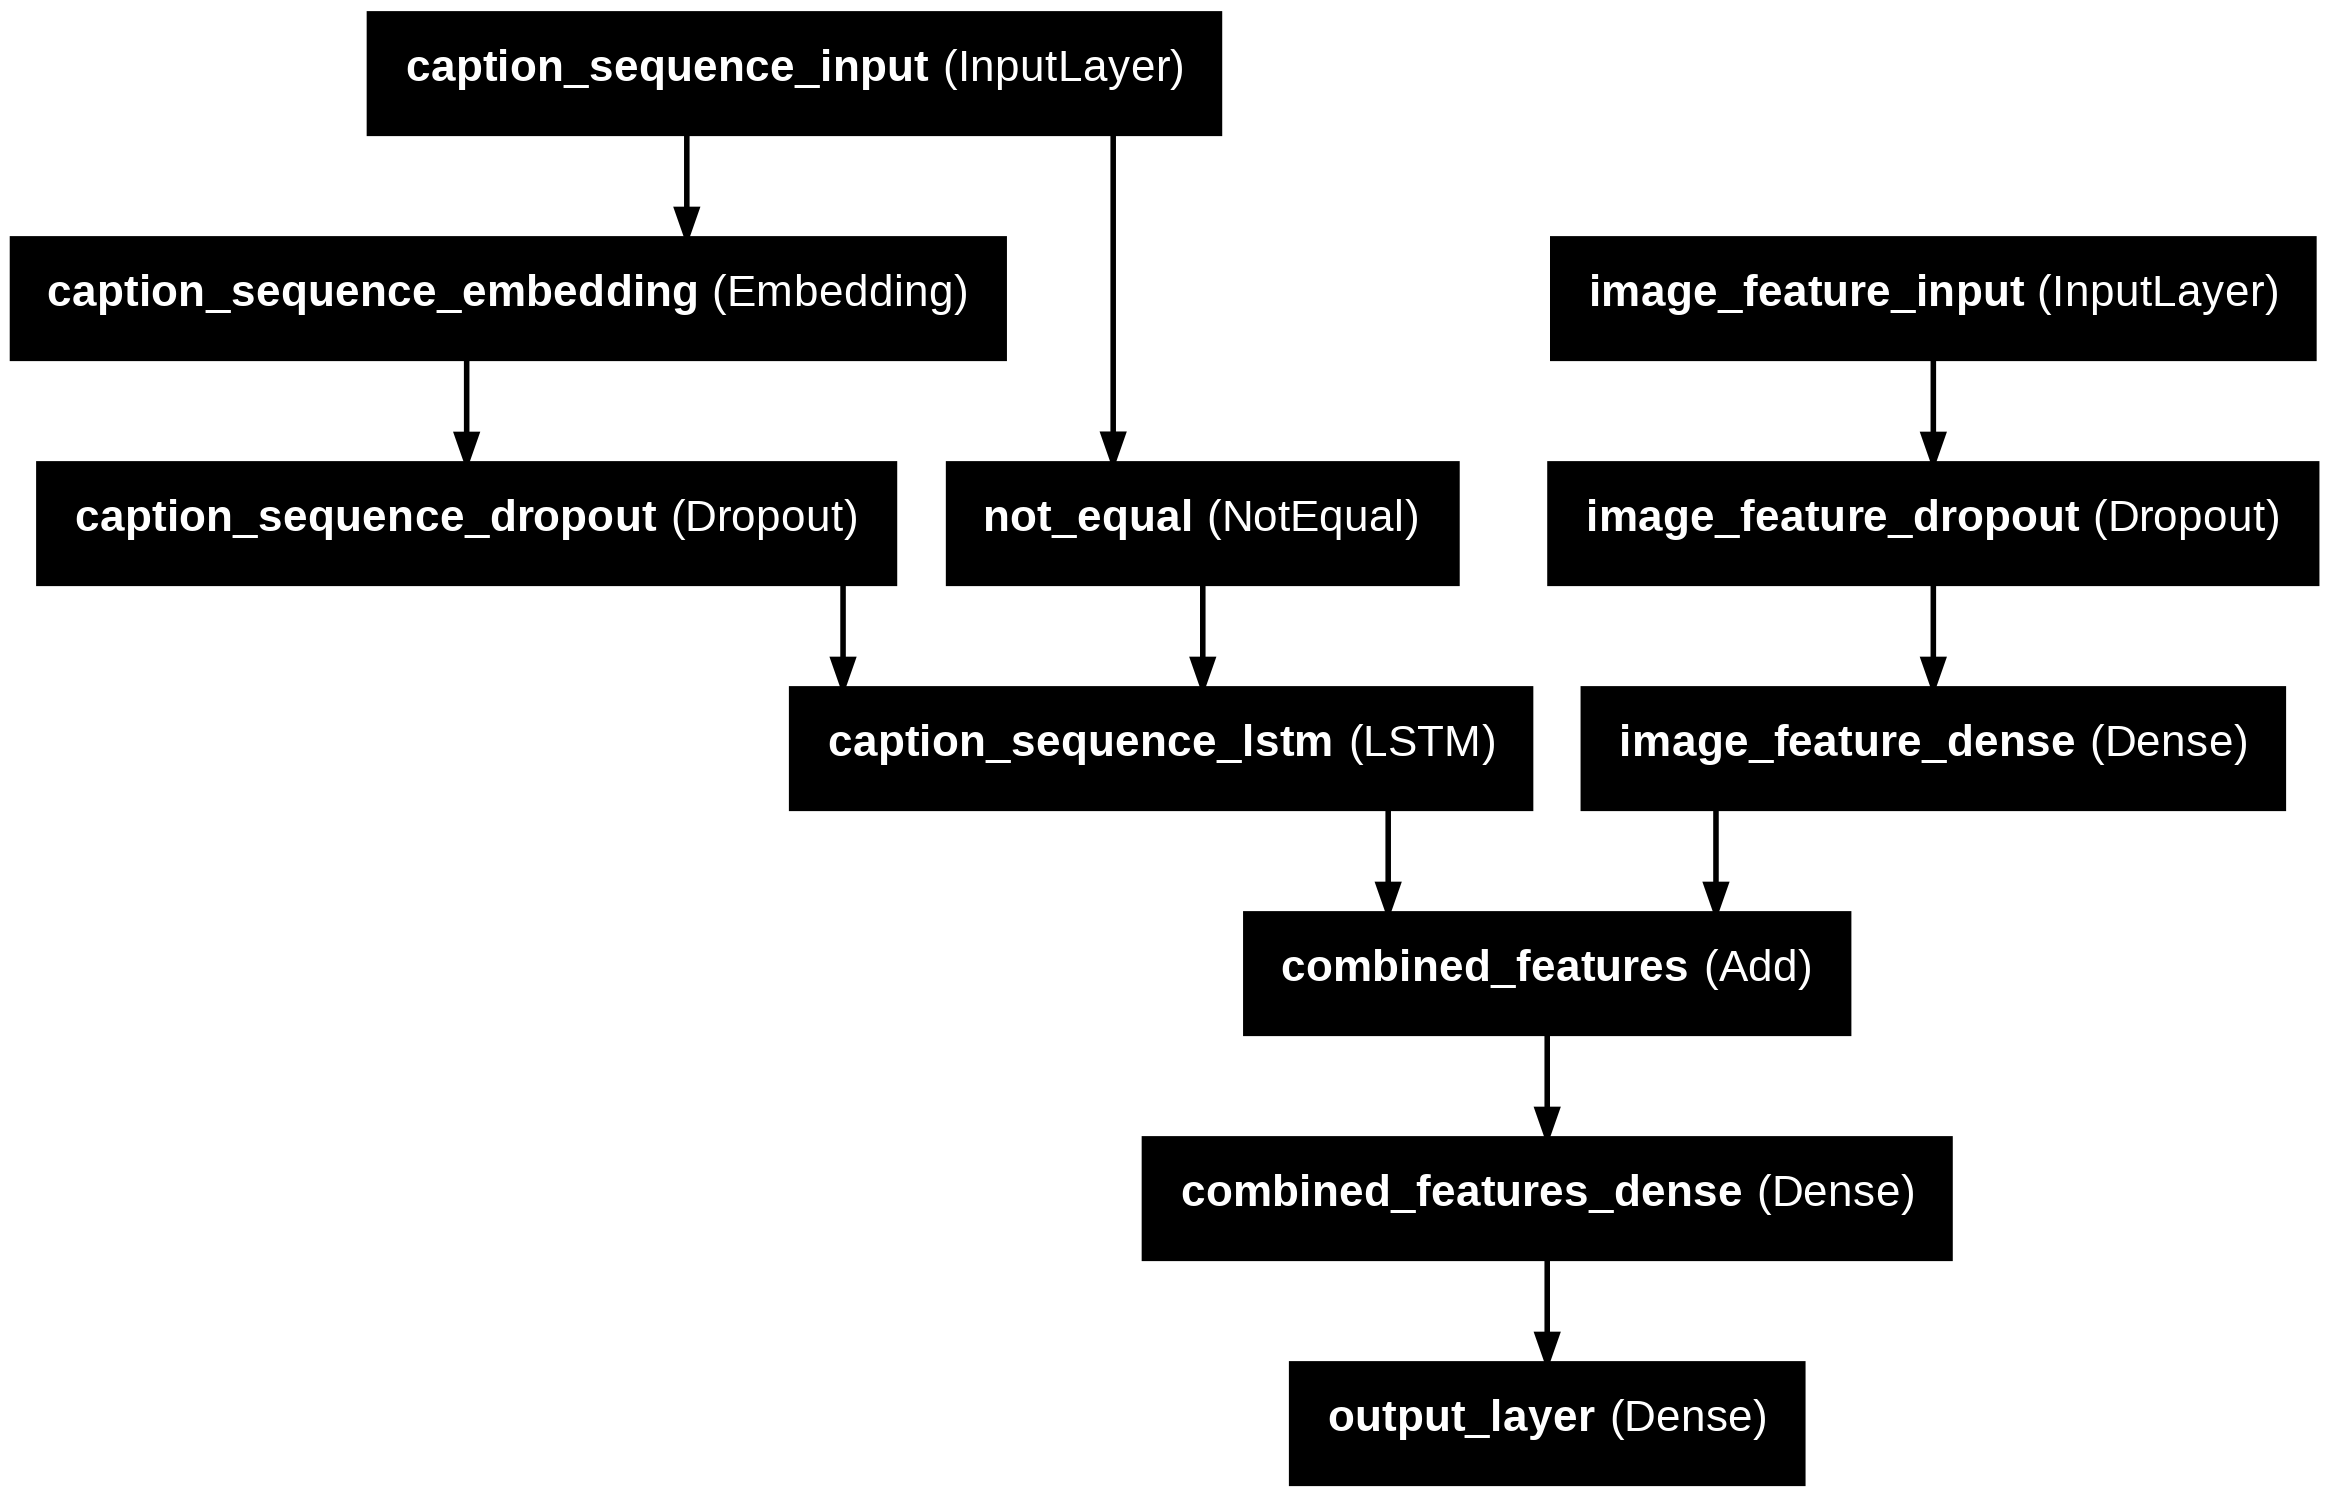

In [34]:
plot_model(resnet_lstm_model, to_file='resnet_lstm_model.png', show_layer_names=True)

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2773 - loss: 5.9498
Epoch 1: val_loss improved from inf to 4.74918, saving model to models/resnet_lstm/best_model.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2775 - loss: 5.9458 - val_accuracy: 0.3615 - val_loss: 4.7492
Epoch 2/10
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3638 - loss: 4.3428
Epoch 2: val_loss improved from 4.74918 to 3.96621, saving model to models/resnet_lstm/best_model.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3640 - loss: 4.3412 - val_accuracy: 0.4084 - val_loss: 3.9662
Epoch 3/10
249/252 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4190 - loss: 3.8742
Epoch 3: val_loss improved from 3.96621 to 3.74479, saving model to models/resnet_lstm/best_model.keras
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.4189 - loss: 3.8734 - val_accuracy: 0.4231 - val_loss: 3.7448
Epoch 4/10
251/252 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4262 - lo

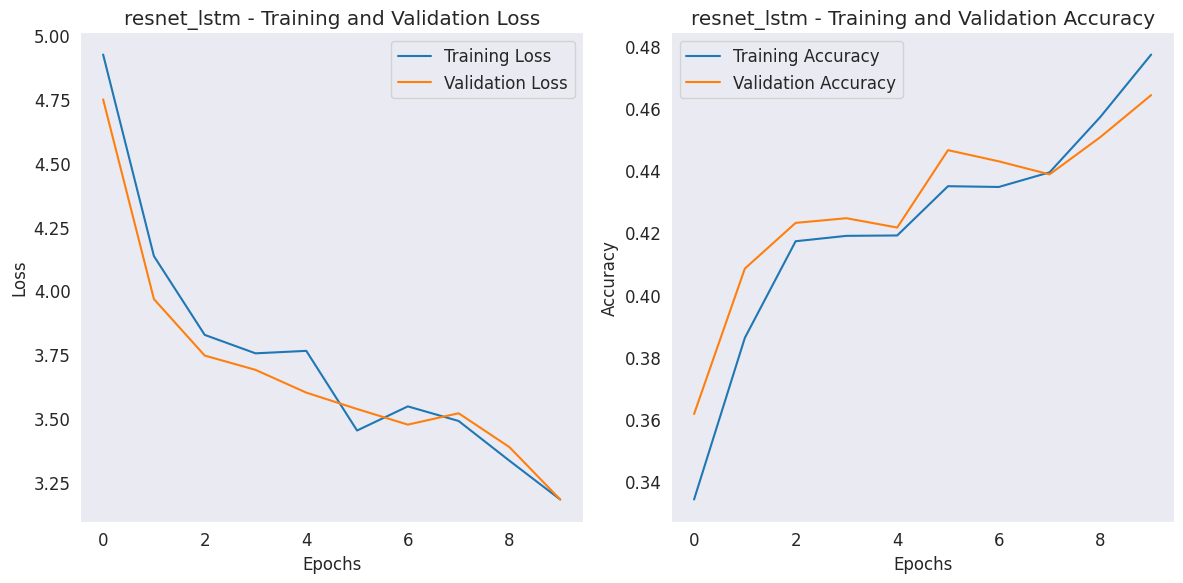

<Functional name=resnet_lstm_model, built=True>

In [35]:
train_model(resnet_lstm_model,"resnet_lstm",train_generator, valid_generator,
            train_encoded_captions, validation_encoded_captions)

In [36]:
resnet_lstm_best_model = load_model('models/resnet_lstm/best_model.keras')

In [40]:
# import smoothing function
from nltk.translate.bleu_score import SmoothingFunction
def evaluate_model(test_features, test_captions, model, select_pics, words_to_indices, indices_to_words, max_length=15, n=10):
    smoothing_function = SmoothingFunction().method1
    bleu_scores = []
    i = 0

    for img_id in test_features:
        if img_id not in select_pics:
            continue  # Only evaluate on selected images

        i += 1
        # Get the features for the image
        photo = test_features[img_id]

        # Read and display the image
        img = cv2.imread(os.path.join(image_path, img_id))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Prepare reference captions by removing start and end tokens
        reference = []
        for caps in test_captions[img_id]:
            list_caps = caps.split(" ")
            list_caps = list_caps[1:-1]  # Remove 'startseq' and 'endseq'
            reference.append(list_caps)

        # Generate caption using the model
        print(f"\nGenerating caption for image: {img_id}")
        candidate = greedy_search(photo, model, words_to_indices, indices_to_words, max_length)
        candidate = candidate.split()  # Convert generated caption to list of words

        # Compute BLEU score using smoothing
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothing_function)
        bleu_scores.append(bleu_score)

        # Display results
        print("Reference Captions:")
        for ref in reference:
            print(" ".join(ref))

        print("\nGenerated Caption:")
        print(" ".join(candidate))

        print("\nBLEU Score:", bleu_score)

        # Stop after displaying 'n' examples
        if i == n:
            break

    # Compute and return the average BLEU score
    average_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0
    return average_bleu

In [41]:
def greedy_search(image, model, words_to_indices, indices_to_words, max_length=15):
    # Reshape the image feature
    image = image.reshape(1, 2048)

    # Start the caption with 'startseq'
    in_text = 'startseq'

    # Generate the caption word by word
    for i in range(max_length):
        # Convert current text to sequence indices
        sequence = [words_to_indices.get(word, 0) for word in in_text.split()]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')

        # Predict the next word
        y_pred = model.predict([image, sequence], verbose=0)
        y_pred_index = np.argmax(y_pred[0])  # Index of the word with the highest probability

        # Convert index to word
        word = indices_to_words.get(y_pred_index, '')

        # Append word to the input sequence
        in_text += ' ' + word

        # Stop if 'endseq' is generated
        if word == 'endseq':
            break

    # Remove startseq and endseq tokens from final caption
    final_caption = in_text.split()[1:-1]
    return ' '.join(final_caption)

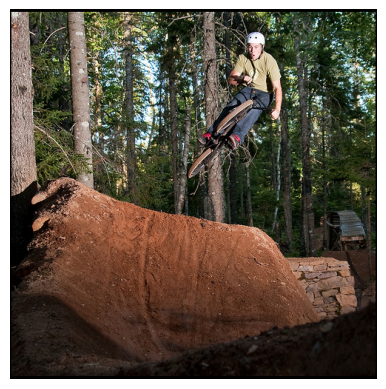


Generating caption for image: 3640422448_a0f42e4559.jpg
Reference Captions:
man on bike is jumping off dirt ramp
man wearing light brown shirt is riding dirt bike in the woods

Generated Caption:
two people in the shirt is in the water

BLEU Score: 0.07171781507224269


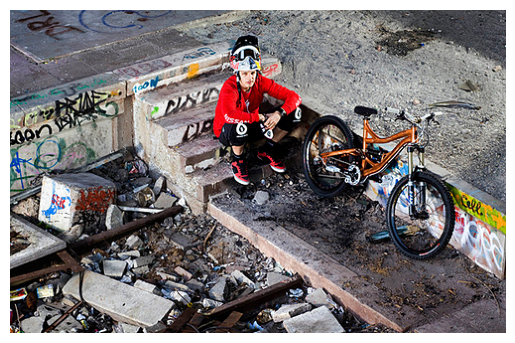


Generating caption for image: 3613424631_3ae537624f.jpg
Reference Captions:
man sits on the stairs next to his bike
man with his bike amid demolished building
cyclist sits on some steps with his bike

Generated Caption:
two people in the shirt is in the water

BLEU Score: 0.023980296761827107


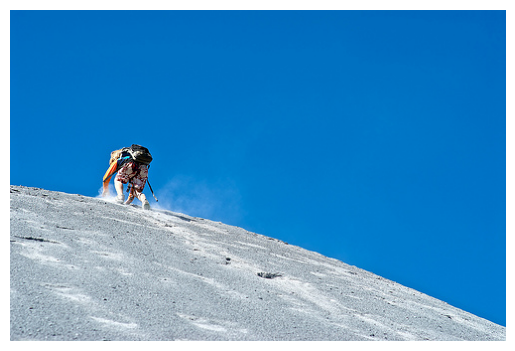


Generating caption for image: 3745451546_fc8ec70cbd.jpg
Reference Captions:
the person is wearing shorts and climbing gray sand hill under blue sky

Generated Caption:
two people in the shirt is in the water

BLEU Score: 0.018284887072297418


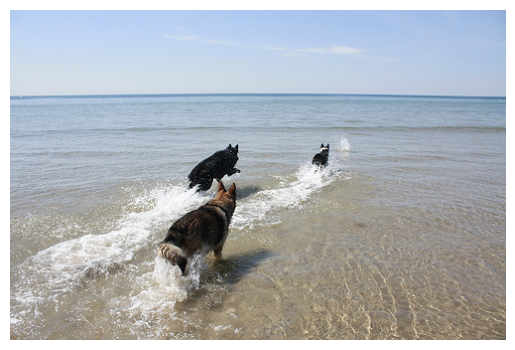


Generating caption for image: 3630641436_8f9ac5b9b2.jpg
Reference Captions:
three dogs rush to chase ball thrown into the surf

Generated Caption:
two dogs is running in the water

BLEU Score: 0.02558948059670209
Average BLEU Score: 0.03489311987576732


In [43]:
select_pics = [
    '3640422448_a0f42e4559.jpg',
    '3613424631_3ae537624f.jpg',
    '3630641436_8f9ac5b9b2.jpg',
    '3745451546_fc8ec70cbd.jpg'
]

# Call evaluate_model on the test dataset using selected images
average_bleu = evaluate_model(test_features, test_captions, resnet_lstm_best_model, select_pics, words_to_indices, indices_to_words)
print(f"Average BLEU Score: {average_bleu}")

Using beam search with k=3

In [44]:
def beam_search(image, model, k=3):
    """
    Perform beam search to generate captions for an image.

    Args:
        image (numpy.ndarray): Extracted features of the image.
        model (keras.Model): Trained ResNet-LSTM model.
        k (int): Beam width, number of candidates to maintain at each step.

    Returns:
        str: The generated caption.
    """
    # Initialize the beam with the start token
    start_seq = [words_to_indices['startseq']]
    beam = [(start_seq, 0)]  # (sequence, cumulative probability)

    # Iterate until reaching the maximum caption length
    for _ in range(max_length):
        # Temporary list to store all possible extensions of the beam
        all_candidates = []

        for seq, score in beam:
            # Stop if end token is generated
            if seq[-1] == words_to_indices['endseq']:
                all_candidates.append((seq, score))
                continue

            # Prepare the input for the model
            padded_seq = pad_sequences([seq], maxlen=max_length, padding='post')
            y_pred = model.predict([image.reshape(1, 2048), padded_seq], verbose=0)

            # Get top k predictions
            top_k_indices = np.argsort(y_pred[0])[-k:]  # Top k indices
            for idx in top_k_indices:
                # Add the new word index to the sequence and calculate the new score
                candidate_seq = seq + [idx]
                candidate_score = score + np.log(y_pred[0][idx])  # Use log probabilities for numerical stability
                all_candidates.append((candidate_seq, candidate_score))

        # Sort candidates by score and keep the top k
        beam = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:k]

    # Select the sequence with the highest score
    final_seq = beam[0][0]

    # Convert indices to words and remove startseq and endseq tokens
    final_caption = [indices_to_words.get(idx, '') for idx in final_seq]
    return ' '.join(final_caption[1:-1])

In [45]:
def evaluate_with_beam_search(test_features, test_captions, model, select_pics, k=3):

    smooth_fn = SmoothingFunction().method1  # Smoothing for BLEU calculation

    for img_id in select_pics:
        # Display the image
        img_path = os.path.join(image_path, img_id)
        img = cv2.imread(img_path)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Get features for the image
        if img_id not in test_features:
            print(f"Features for image {img_id} not found!")
            continue
        photo = test_features[img_id]

        # Prepare reference captions by removing 'startseq' and 'endseq'
        reference = []
        for caps in test_captions[img_id]:
            list_caps = caps.split(" ")
            list_caps = list_caps[1:-1]  # Remove 'startseq' and 'endseq'
            reference.append(list_caps)

        # Generate caption using beam search
        print(f"\nGenerating caption for image: {img_id}")
        candidate = beam_search(photo, model, k=k)
        candidate = candidate.split()  # Convert generated caption to list of words

        # Compute BLEU score
        score = sentence_bleu(reference, candidate, smoothing_function=smooth_fn)

        # Display results
        print("Reference Captions:")
        for ref in reference:
            print(" ".join(ref))

        print("\nGenerated Caption:")
        print(" ".join(candidate))

        print("\nBLEU Score:", score)
        print("-" * 50)

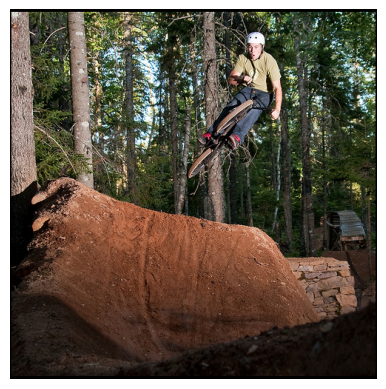


Generating caption for image: 3640422448_a0f42e4559.jpg
Reference Captions:
man on bike is jumping off dirt ramp
man wearing light brown shirt is riding dirt bike in the woods

Generated Caption:
two people is in the water

BLEU Score: 0.06846046760764757
--------------------------------------------------


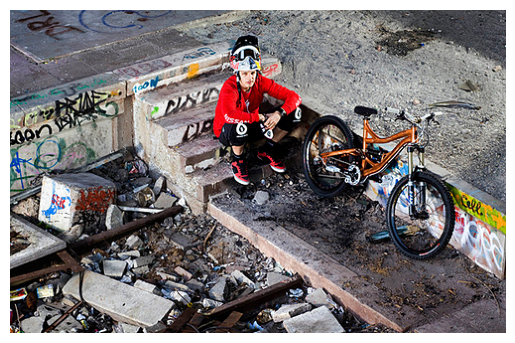


Generating caption for image: 3613424631_3ae537624f.jpg
Reference Captions:
man sits on the stairs next to his bike
man with his bike amid demolished building
cyclist sits on some steps with his bike

Generated Caption:
man in red shirt in the water

BLEU Score: 0.039281465090051315
--------------------------------------------------


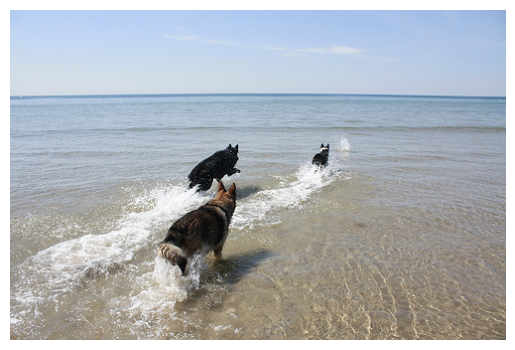


Generating caption for image: 3630641436_8f9ac5b9b2.jpg
Reference Captions:
three dogs rush to chase ball thrown into the surf

Generated Caption:
the dog is in the water

BLEU Score: 0.020960166113993737
--------------------------------------------------


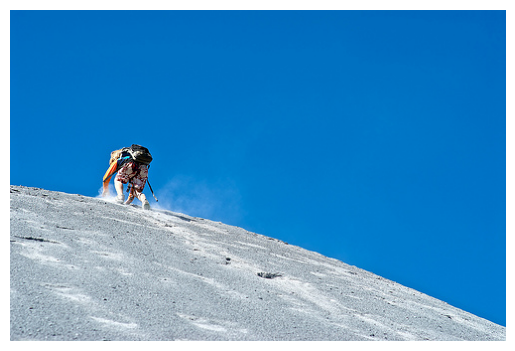


Generating caption for image: 3745451546_fc8ec70cbd.jpg
Reference Captions:
the person is wearing shorts and climbing gray sand hill under blue sky

Generated Caption:
two people is in the water

BLEU Score: 0.015118370289367042
--------------------------------------------------


In [46]:
# Call the evaluation function for selected images
select_pics = [
    '3640422448_a0f42e4559.jpg',
    '3613424631_3ae537624f.jpg',
    '3630641436_8f9ac5b9b2.jpg',
    '3745451546_fc8ec70cbd.jpg'
]

evaluate_with_beam_search(test_features, test_captions, resnet_lstm_best_model, select_pics, k=3)
